## Prepare

In [ ]:
# ! wget -O dacapo-bench.jar https://downloads.sourceforge.net/project/dacapobench/9.12-bach-MR1/dacapo-9.12-MR1-bach.jar?ts=gAAAAABk1grVPN66UoxuyfsRPvuzhgnmeEB0y0aRIsA3TRrksaUWqajBjQ-E21zbKyJzhrCcIYFh6YpJanCBPWJlAoXzemk3Rg%3D%3D&r=https%3A%2F%2Fsourceforge.net%2Fprojects%2Fdacapobench%2Ffiles%2F9.12-bach-MR1%2Fdacapo-9.12-MR1-bach.jar
# ! wget -O jdk.tar.gz https://download.bell-sw.com/java/11.0.20+8/bellsoft-jdk11.0.20+8-linux-amd64.tar.gz
# MACOS
! wget -O jdk.tar.gz https://download.bell-sw.com/java/11.0.20.1+1/bellsoft-jdk11.0.20.1+1-macos-amd64.tar.gz
! tar xzf jdk.tar.gz && rm -fv jdk.tar.gz
! java -version

In [17]:
! ./jdk-11.0.20.1.jdk/bin/java -jar dacapo-bench.jar -l

avrora batik eclipse fop h2 jython luindex lusearch lusearch-fix pmd sunflow tomcat tradebeans tradesoap xalan


In [ ]:
! BM=batik & ./jdk-11.0.20/bin/java -XX:+UseParallelGC -XX:MaxHeapSize=42983227392 -cp dacapo-bench.jar \
-Xlog:gc=debug:file=gc-{BM}.txt -Dvmstat.enable_jfr=yes \
-Dvmstat.csv=yes Harness -v -n 5 {BM}

In [ ]:
# ! pip install gym
# ! mkdir /home/ellkrauze/tmp
# ! export TMPDIR=/home/ellkrauze/tmp && pip install tensorflow
# ! export TMPDIR=/home/ellkrauze/tmp && pip install protobuf==3.20.*
# ! export TMPDIR=/home/ellkrauze/tmp && pip  install --force-reinstall -U tensorflow==2.3.0 keras keras-rl2 h5py==2.10.*


### GCViewer

In [ ]:
# Download jar from http://sourceforge.net/projects/gcviewer/files/gcviewer-1.36.jar/download
# java -cp gcviewer-1.36.jar com.tagtraum.perf.gcviewer.GCViewer gc-xalan.txt summary.csv -t SUMMARY

## Main

In [2]:
! python -V

Python 3.8.17


In [1]:
! export PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python

import requests
import json
import logging
import warnings
import numpy as np
from typing import List
from gym.spaces import Discrete, Box
import JVMEnv, JVMEnvTest
from tqdm import tqdm 

warnings.filterwarnings(action="ignore")

# GCEasy API Key
API_KEY = "af176fbc-7be2-4fc5-8b31-5624956845c6"

# JDK used for benchmarking
TEST_JDK_PATH = "/home/ellkrauze/projects/gc-ml/jdk-11.0.20"

# DaCapo benchmark name
BM = "batik"

BM_PATH = "dacapo-bench.jar"

# Number of benchmark's iterations in total
NUM_ITER = 5

# Name of the output file (Garbage Collector logs)
GC_LOG_FILE = f"gc-{BM}.txt"

# JVM option to perform action to (increase, leave, decrease)
JVM_OPT_NAME = "MaxHeapSize"
# Maximum heap size array (from 256m to 4G)
JVM_OPT_RANGE = [np.array([268435456]), np.array([4294967296])]

"""
What to optimize: our goal in performance tuning.
This is a JSON field which is extracted from GC log file
using GCEasy API (https://blog.gceasy.io/2016/06/18/garbage-collection-log-analysis-api/).
"""
# GOAL = "throughputPercentage"
GOAL = "fullGCMaxTime"


In [1]:
# env = JVMEnv.JVMEnv(
#     jdk = TEST_JDK_PATH, 
#     bm_path = BM_PATH,
#     jvm_opt_name = JVM_OPT_NAME,
#     jvm_opt_range = JVM_OPT_RANGE,
#     bm = BM,
#     n = NUM_ITER,
#     goal = GOAL,
#     api_key = API_KEY
# )

## Plot Xmx

In [ ]:

fullgc_values = []
minorgc_values = []
heap_values = []

for Xmx in tqdm(range(268435456, 4294967296, 100 * (2**10) * (2**10))):
    env._run(
        jvm_opts = [f"-XX:MaxHeapSize={Xmx}"], 
        gc_log_file = GC_LOG_FILE, 
        bm = BM, 
        bm_path = BM_PATH, 
        n = NUM_ITER
    )
    
    fullgc_value = env._get_goal_value(
        goal_name = "fullGCMaxTime", 
        gc_log_file = GC_LOG_FILE, 
        api_key = API_KEY
    )

    minorgc_value = env._get_goal_value(
        goal_name = "minorGCMaxTime", 
        gc_log_file = GC_LOG_FILE, 
        api_key = API_KEY
    )

    fullgc_values.append(fullgc_value)
    minorgc_values.append(minorgc_value)
    heap_values.append(Xmx)

100%|██████████| 39/39 [06:48<00:00, 10.47s/it]


100%|██████████| 39/39 [01:50<00:00,  2.83s/it]


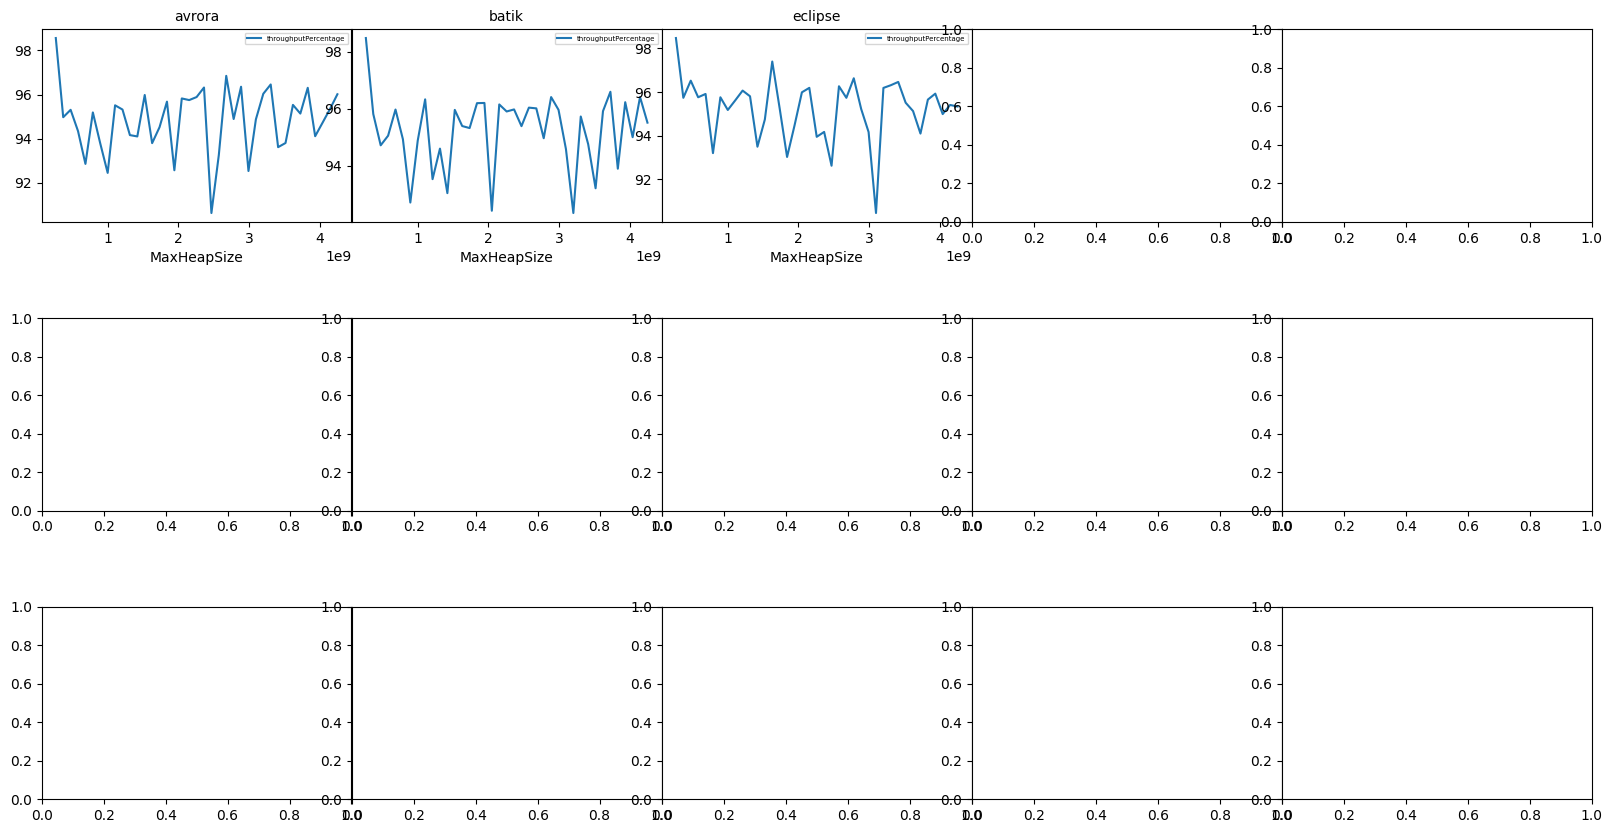

In [ ]:
def get_goal_value(goal_name: str, gc_log_file: str, api_key: str, verbose: bool=False):

    gceasy_url = f"https://api.gceasy.io/analyzeGC?apiKey={api_key}&normalizeUnits=true"
    gc_logfile = {"upload_file": open(gc_log_file, 'rb')}
    headers = {"Content-Type": "text"}

    response = requests.post(gceasy_url, files=gc_logfile, headers=headers)
    gc_info = json.loads(response.text)
    goal_value = gc_info[goal_name]

    if verbose: logging.debug(f"{goal_name} = {goal_value}")

    return float(goal_value)

bms = ["avrora","batik","eclipse", "fop", "h2", "jython", "luindex", "lusearch", "lusearch-fix", "pmd", "sunflow", "tomcat", "tradebeans", "tradesoap", "xalan"]

fig, axs = plt.subplots(3, 5, figsize=(20, 10))
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

# for i in range(len(bms)):
for i in range(3):

    # Measurements
    gc_values = []
    heap_values = []

    for Xmx in tqdm(range(268435456, 4294967296, 100 * (2**10) * (2**10))):
        env._run(
            jvm_opts = [f"-XX:MaxHeapSize={Xmx}"], 
            gc_log_file = GC_LOG_FILE, 
            bm = BM, 
            bm_path = BM_PATH, 
            n = 3
        )
        
        gc_value = get_goal_value(
            goal_name = "throughputPercentage", 
            gc_log_file = GC_LOG_FILE, 
            api_key = API_KEY
        )

        gc_values.append(gc_value)
        heap_values.append(Xmx)
    
    # Plots
    axs[i].plot(heap_values, gc_values, label='throughputPercentage')
    axs[i].legend(fontsize = 5)
    axs[i].set_xlabel(JVM_OPT_NAME, fontsize = 10)
    axs[i].set_title(bms[i], fontsize = 10)

# plt.plot(heap_values, fullgc_values, label='minorGCMaxTime')
# plt.plot(heap_values, minorgc_values, label='fullGCMaxTime')
# plt.legend()
# plt.xlabel(JVM_OPT_NAME)
# plt.title(BM)
# plt.show()

# Deep Learning Model

In [ ]:
env = JVMEnvTest.JVMEnvTest()

states = env.observation_space.shape
actions = env.action_space.n

print(states)
print(actions)

model = build_model(states, actions)
model.summary()

In [ ]:
# episodes = 3
# for episode in tqdm(range(1, episodes+1)):
#     state = env.reset()
#     done = False
#     score = 0

#     while not done:
#         env.render(mode="human")
#         action = env.action_space.sample()
#         n_state, reward, done, info = env.step(action)
#         score+=reward
#     #     print(info)
#     #     print(f"Score: {score}")
#     # print('Episode:{} Score:{}'.format(episode, score))

# Tensorflow DQN

In [1]:
import tensorflow as tf
from tqdm import tqdm
import imageio

from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import categorical_q_network, sequential
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.specs import tensor_spec

# env_name = "CartPole-v1" # @param {type:"string"}
num_iterations = 15000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_capacity = 100000  # @param {type:"integer"}

fc_layer_params = (100,)

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
gamma = 0.99
log_interval = 200  # @param {type:"integer"}

num_atoms = 51  # @param {type:"integer"}
min_q_value = -20  # @param {type:"integer"}
max_q_value = 20  # @param {type:"integer"}
n_step_update = 2  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

# JDK used for benchmarking
TEST_JDK_PATH = "/home/ellkrauze/projects/gc-ml/jdk-11.0.20"
# DaCapo benchmark name
BM = "batik"
BM_PATH = "dacapo-bench.jar"


In [2]:
# from PyEnvironments import CurveEnv, CurveMultipleEnv, JVMEnv

from PyEnvironments import JVMEnv

# env = CurveEnv(verbose=False)
# env = CurveMultipleEnv()
env = JVMEnv(jdk=TEST_JDK_PATH, bm_path=BM_PATH, bm="xalan", verbose=True)

train_env = tf_py_environment.TFPyEnvironment(env)
eval_env = tf_py_environment.TFPyEnvironment(env)

In [3]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

def dense_layer(num_units):
    """
    Define a helper function to create Dense layers configured with the right
    activation and kernel initializer.
    """
    return tf.keras.layers.Dense(
        num_units,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.VarianceScaling(
            scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

We also need an `optimizer` to train the network we just created, and a `train_step_counter` variable to keep track of how many times the network was updated.

Note that one other significant difference from vanilla `DqnAgent` is that we now need to specify `min_q_value` and `max_q_value` as arguments. These specify the most extreme values of the support (in other words, the most extreme of the 51 atoms on either side). Make sure to choose these appropriately for your particular environment. Here we use -20 and 20.

In [4]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    n_step_update=n_step_update,
    td_errors_loss_fn=common.element_wise_squared_loss,
    epsilon_greedy=0.1, # a probability of choosing a random action
    gamma=gamma,
    train_step_counter=train_step_counter)
    
agent.initialize()

## Metrics and Evaluation

The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode, and we usually average this over a few episodes. We can compute the average return metric as follows.


In [5]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in tqdm(range(num_episodes)):
    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
      # print(time_step)
      print(f"{_}: {time_step.observation}, {time_step.reward}")
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

random_policy = random_tf_policy.RandomTFPolicy(
  train_env.time_step_spec(),
  train_env.action_spec()
)

# compute_avg_return(eval_env, random_policy, num_eval_episodes)

# compute_avg_return(eval_env, agent.policy, num_eval_episodes)

# https://github.com/tensorflow/agents/blob/master/tf_agents/metrics/py_metrics.py

## Data Collection

In order to keep track of the data collected from the environment, we will use a replay buffer. It stores experience data when we collect trajectories and is consumed during training.

This replay buffer is constructed using specs describing the tensors that are to be stored, which can be obtained from the agent using agent.collect_data_spec.

Set up the replay buffer and the initial data collection with the random policy.

In [6]:
#@test {"skip": true}
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

def collect_step(environment, policy):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  replay_buffer.add_batch(traj)

for _ in tqdm(range(initial_collect_steps)):
  collect_step(train_env, random_policy)

# This loop is so common in RL, that we provide standard implementations of
# these. For more details see the drivers module.

# Dataset generates trajectories with shape [BxTx...] where
# T = n_step_update + 1.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size,
    num_steps=n_step_update + 1).prefetch(3)

iterator = iter(dataset)

  0%|          | 0/1000 [00:00<?, ?it/s]

openjdk version "11.0.11" 2021-04-20 LTS
OpenJDK Runtime Environment (build 11.0.11+10-LTS)
OpenJDK 64-Bit Server VM (build 11.0.11+10-LTS, mixed mode)
openjdk version "11.0.11" 2021-04-20 LTS
OpenJDK Runtime Environment (build 11.0.11+10-LTS)
OpenJDK 64-Bit Server VM (build 11.0.11+10-LTS, mixed mode)
  0%|          | 1/1000 [00:25<7:11:56, 25.94s/it]

[STEP] state: [list([2147483648.0, 239075328.0]) 0.08205], current_goal_value: 0.08205, reward: 0.47997835497835484


  0%|          | 2/1000 [00:38<5:01:50, 18.15s/it]

[STEP] state: [list([2147483648.0, 134217728.0]) 0.05366], current_goal_value: 0.05366, reward: 0.34600853138330284


  0%|          | 3/1000 [00:48<3:54:58, 14.14s/it]

[STEP] state: [list([2252341248.0, 134217728.0]) 0.05437], current_goal_value: 0.05437, reward: 0.01323145732389121


  0%|          | 4/1000 [00:56<3:19:47, 12.04s/it]

[STEP] state: [list([2252341248.0, 239075328.0]) 0.0616], current_goal_value: 0.0616, reward: 0.13297774508000737


  0%|          | 5/1000 [01:07<3:11:15, 11.53s/it]

[STEP] state: [list([2147483648.0, 239075328.0]) 0.09256], current_goal_value: 0.09256, reward: 0.5025974025974026


  1%|          | 6/1000 [01:16<2:56:36, 10.66s/it]

[STEP] state: [list([2147483648.0, 134217728.0]) 0.05901], current_goal_value: 0.05901, reward: 0.3624675885911841


  1%|          | 7/1000 [01:25<2:46:06, 10.04s/it]

[STEP] state: [list([2147483648.0, 125000000.0]) 0.05155], current_goal_value: 0.05155, reward: 0.12641925097441115


  1%|          | 8/1000 [01:34<2:44:21,  9.94s/it]

[STEP] state: [list([2042626048.0, 125000000.0]) 0.04754], current_goal_value: 0.04754, reward: 0.07778855480116391


  1%|          | 9/1000 [01:42<2:34:16,  9.34s/it]

[STEP] state: [list([1937768448.0, 125000000.0]) 0.05906], current_goal_value: 0.05906, reward: 0.24232225494320578


  1%|          | 10/1000 [01:51<2:30:27,  9.12s/it]

[STEP] state: [list([2042626048.0, 125000000.0]) 0.04866], current_goal_value: 0.04866, reward: 0.17609210971892988


  1%|          | 11/1000 [02:00<2:28:14,  8.99s/it]

[STEP] state: [list([2042626048.0, 125000000.0]) 0.04435], current_goal_value: 0.04435, reward: 0.08857377722975752


  1%|          | 12/1000 [02:07<2:20:33,  8.54s/it]

[STEP] state: [list([2042626048.0, 229857600.0]) 0.05315], current_goal_value: 0.05315, reward: 0.19842164599774526


  1%|▏         | 13/1000 [02:16<2:19:02,  8.45s/it]

[STEP] state: [list([2042626048.0, 125000000.0]) 0.04884], current_goal_value: 0.04884, reward: 0.08109125117591724


  1%|▏         | 14/1000 [02:24<2:17:59,  8.40s/it]

[STEP] state: [list([2042626048.0, 125000000.0]) 0.0491], current_goal_value: 0.0491, reward: 0.005323505323505249


  2%|▏         | 15/1000 [02:32<2:16:15,  8.30s/it]

[STEP] state: [list([2147483648.0, 125000000.0]) 0.04919], current_goal_value: 0.04919, reward: 0.0018329938900203627


  2%|▏         | 16/1000 [02:41<2:21:32,  8.63s/it]

[STEP] state: [list([2147483648.0, 125000000.0]) 0.04833], current_goal_value: 0.04833, reward: 0.017483228298434635


  2%|▏         | 17/1000 [02:50<2:23:40,  8.77s/it]

[STEP] state: [list([2147483648.0, 125000000.0]) 0.06517], current_goal_value: 0.06517, reward: 0.34843782329815864


  2%|▏         | 18/1000 [02:59<2:21:55,  8.67s/it]

[STEP] state: [list([2147483648.0, 125000000.0]) 0.04588], current_goal_value: 0.04588, reward: 0.2959950897652295


  2%|▏         | 19/1000 [03:07<2:17:52,  8.43s/it]

[STEP] state: [list([2252341248.0, 125000000.0]) 0.05145], current_goal_value: 0.05145, reward: 0.12140366172624249


  2%|▏         | 20/1000 [03:15<2:19:25,  8.54s/it]

[STEP] state: [list([2252341248.0, 125000000.0]) 0.04613], current_goal_value: 0.04613, reward: 0.10340136054421778


  2%|▏         | 21/1000 [03:23<2:16:29,  8.37s/it]

[STEP] state: [list([2252341248.0, 125000000.0]) 0.06616], current_goal_value: 0.06616, reward: 0.43420767396488186


  2%|▏         | 22/1000 [03:31<2:14:24,  8.25s/it]

[STEP] state: [list([2357198848.0, 125000000.0]) 0.0507], current_goal_value: 0.0507, reward: 0.2336759371221281


  2%|▏         | 23/1000 [03:41<2:19:40,  8.58s/it]

[STEP] state: [list([2357198848.0, 125000000.0]) 0.05028], current_goal_value: 0.05028, reward: 0.008284023668639126


  2%|▏         | 24/1000 [03:49<2:17:19,  8.44s/it]

[STEP] state: [list([2357198848.0, 125000000.0]) 0.05005], current_goal_value: 0.05005, reward: 0.004574383452665096


  2%|▎         | 25/1000 [03:56<2:12:31,  8.16s/it]

[STEP] state: [list([2357198848.0, 229857600.0]) 0.04502], current_goal_value: 0.04502, reward: 0.1004995004995005


  3%|▎         | 26/1000 [04:05<2:13:20,  8.21s/it]

[STEP] state: [list([2462056448.0, 229857600.0]) 0.04918], current_goal_value: 0.04918, reward: 0.09240337627721022


  3%|▎         | 27/1000 [04:13<2:15:46,  8.37s/it]

[STEP] state: [list([2566914048.0, 229857600.0]) 0.05986], current_goal_value: 0.05986, reward: 0.21716144774298485


  3%|▎         | 28/1000 [04:21<2:13:17,  8.23s/it]

[STEP] state: [list([2671771648.0, 229857600.0]) 0.06087], current_goal_value: 0.06087, reward: 0.016872702973605144


  3%|▎         | 29/1000 [04:30<2:14:47,  8.33s/it]

[STEP] state: [list([2776629248.0, 229857600.0]) 0.05834], current_goal_value: 0.05834, reward: 0.041563988828651185


  3%|▎         | 30/1000 [04:39<2:16:52,  8.47s/it]

[STEP] state: [list([2881486848.0, 229857600.0]) 0.05343], current_goal_value: 0.05343, reward: 0.08416181007884821


  3%|▎         | 31/1000 [04:47<2:15:57,  8.42s/it]

[STEP] state: [list([2881486848.0, 250000000.0]) 0.04917], current_goal_value: 0.04917, reward: 0.07973048848961257


  3%|▎         | 32/1000 [04:55<2:13:42,  8.29s/it]

[STEP] state: [list([2881486848.0, 145142400.0]) 0.05779], current_goal_value: 0.05779, reward: 0.17531014846451093


  3%|▎         | 33/1000 [05:03<2:14:20,  8.34s/it]

[STEP] state: [list([2776629248.0, 145142400.0]) 0.04865], current_goal_value: 0.04865, reward: 0.1581588510122859


  3%|▎         | 34/1000 [05:11<2:11:28,  8.17s/it]

[STEP] state: [list([2671771648.0, 145142400.0]) 0.05383], current_goal_value: 0.05383, reward: 0.10647482014388497


  4%|▎         | 35/1000 [05:19<2:09:24,  8.05s/it]

[STEP] state: [list([2671771648.0, 125000000.0]) 0.05109], current_goal_value: 0.05109, reward: 0.0509009845810886


  4%|▎         | 36/1000 [05:27<2:11:02,  8.16s/it]

[STEP] state: [list([2671771648.0, 125000000.0]) 0.05191], current_goal_value: 0.05191, reward: 0.016050107653160978


  4%|▎         | 37/1000 [05:36<2:14:12,  8.36s/it]

[STEP] state: [list([2566914048.0, 125000000.0]) 0.05431], current_goal_value: 0.05431, reward: 0.04623386630706992


  4%|▍         | 38/1000 [05:45<2:15:08,  8.43s/it]

[STEP] state: [list([2566914048.0, 229857600.0]) 0.05248], current_goal_value: 0.05248, reward: 0.03369545203461606


  4%|▍         | 39/1000 [05:54<2:18:36,  8.65s/it]

[STEP] state: [list([2566914048.0, 250000000.0]) 0.04876], current_goal_value: 0.04876, reward: 0.07088414634146344


  4%|▍         | 40/1000 [06:03<2:19:22,  8.71s/it]

[STEP] state: [list([2566914048.0, 145142400.0]) 0.05228], current_goal_value: 0.05228, reward: 0.07219031993437248


  4%|▍         | 41/1000 [06:11<2:19:03,  8.70s/it]

[STEP] state: [list([2462056448.0, 145142400.0]) 0.07242], current_goal_value: 0.07242, reward: 0.38523335883703136


  4%|▍         | 42/1000 [06:20<2:17:40,  8.62s/it]

[STEP] state: [list([2462056448.0, 125000000.0]) 0.06312], current_goal_value: 0.06312, reward: 0.12841756420878214


  4%|▍         | 43/1000 [06:28<2:16:18,  8.55s/it]

[STEP] state: [list([2462056448.0, 125000000.0]) 0.0429], current_goal_value: 0.0429, reward: 0.32034220532319385


  4%|▍         | 44/1000 [06:36<2:13:15,  8.36s/it]

[STEP] state: [list([2462056448.0, 125000000.0]) 0.05146], current_goal_value: 0.05146, reward: 0.1995337995337995


  4%|▍         | 45/1000 [06:45<2:12:42,  8.34s/it]

[STEP] state: [list([2462056448.0, 125000000.0]) 0.04741], current_goal_value: 0.04741, reward: 0.07870190439176056


  5%|▍         | 46/1000 [06:54<2:17:27,  8.64s/it]

[STEP] state: [list([2462056448.0, 229857600.0]) 0.04927], current_goal_value: 0.04927, reward: 0.039232229487449914


  5%|▍         | 47/1000 [07:02<2:12:51,  8.36s/it]

[STEP] state: [list([2357198848.0, 229857600.0]) 0.05219], current_goal_value: 0.05219, reward: 0.05926527298558958


  5%|▍         | 48/1000 [07:10<2:10:48,  8.24s/it]

[STEP] state: [list([2357198848.0, 250000000.0]) 0.0519], current_goal_value: 0.0519, reward: 0.0055566200421536425


  5%|▍         | 49/1000 [07:18<2:13:53,  8.45s/it]

[STEP] state: [list([2462056448.0, 250000000.0]) 0.06656], current_goal_value: 0.06656, reward: 0.2824662813102118


  5%|▌         | 50/1000 [07:26<2:11:12,  8.29s/it]

[STEP] state: [list([2566914048.0, 250000000.0]) 0.05002], current_goal_value: 0.05002, reward: 0.24849759615384606


  5%|▌         | 51/1000 [07:35<2:13:10,  8.42s/it]

[STEP] state: [list([2462056448.0, 250000000.0]) 0.0548], current_goal_value: 0.0548, reward: 0.09556177528988404


  5%|▌         | 52/1000 [07:45<2:22:02,  8.99s/it]

[STEP] state: [list([2462056448.0, 145142400.0]) 0.04868], current_goal_value: 0.04868, reward: 0.11167883211678832


  5%|▌         | 53/1000 [07:53<2:16:54,  8.67s/it]

[STEP] state: [list([2462056448.0, 125000000.0]) 0.05247], current_goal_value: 0.05247, reward: 0.07785538208709945


  5%|▌         | 54/1000 [08:02<2:15:52,  8.62s/it]

[STEP] state: [list([2566914048.0, 125000000.0]) 0.05417], current_goal_value: 0.05417, reward: 0.032399466361730515


  6%|▌         | 55/1000 [08:10<2:11:51,  8.37s/it]

[STEP] state: [list([2566914048.0, 125000000.0]) 0.05177], current_goal_value: 0.05177, reward: 0.044304965848255606


  6%|▌         | 56/1000 [08:18<2:10:18,  8.28s/it]

[STEP] state: [list([2671771648.0, 125000000.0]) 0.0516], current_goal_value: 0.0516, reward: 0.0032837550705040863


  6%|▌         | 57/1000 [08:26<2:11:29,  8.37s/it]

[STEP] state: [list([2671771648.0, 125000000.0]) 0.04851], current_goal_value: 0.04851, reward: 0.05988372093023261


  6%|▌         | 58/1000 [08:37<2:23:31,  9.14s/it]

[STEP] state: [list([2566914048.0, 125000000.0]) 0.05126], current_goal_value: 0.05126, reward: 0.05668934240362817


  6%|▌         | 59/1000 [08:46<2:20:41,  8.97s/it]

[STEP] state: [list([2462056448.0, 125000000.0]) 0.05018], current_goal_value: 0.05018, reward: 0.021069059695669093


  6%|▌         | 60/1000 [08:54<2:17:22,  8.77s/it]

[STEP] state: [list([2357198848.0, 125000000.0]) 0.05352], current_goal_value: 0.05352, reward: 0.0665603826225587


  6%|▌         | 61/1000 [09:04<2:22:48,  9.12s/it]

[STEP] state: [list([2357198848.0, 125000000.0]) 0.05631], current_goal_value: 0.05631, reward: 0.052130044843049346


  6%|▌         | 62/1000 [09:12<2:19:03,  8.89s/it]

[STEP] state: [list([2357198848.0, 125000000.0]) 0.05526], current_goal_value: 0.05526, reward: 0.018646776771443836


  6%|▋         | 63/1000 [09:21<2:16:33,  8.74s/it]

[STEP] state: [list([2462056448.0, 125000000.0]) 0.05053], current_goal_value: 0.05053, reward: 0.08559536735432498


  6%|▋         | 64/1000 [09:29<2:15:39,  8.70s/it]

[STEP] state: [list([2357198848.0, 125000000.0]) 0.04856], current_goal_value: 0.04856, reward: 0.03898674055016821


  6%|▋         | 65/1000 [09:38<2:12:48,  8.52s/it]

[STEP] state: [list([2357198848.0, 229857600.0]) 0.05214], current_goal_value: 0.05214, reward: 0.07372322899505766


  7%|▋         | 66/1000 [09:45<2:09:21,  8.31s/it]

[STEP] state: [list([2462056448.0, 229857600.0]) 0.05306], current_goal_value: 0.05306, reward: 0.017644802454929116


  7%|▋         | 67/1000 [09:54<2:09:02,  8.30s/it]

[STEP] state: [list([2357198848.0, 229857600.0]) 0.05104], current_goal_value: 0.05104, reward: 0.038070109310214865


  7%|▋         | 68/1000 [10:02<2:09:03,  8.31s/it]

[STEP] state: [list([2462056448.0, 229857600.0]) 0.05625], current_goal_value: 0.05625, reward: 0.10207680250783698


  7%|▋         | 69/1000 [10:12<2:15:57,  8.76s/it]

[STEP] state: [list([2357198848.0, 229857600.0]) 0.0449], current_goal_value: 0.0449, reward: 0.20177777777777775


  7%|▋         | 70/1000 [10:21<2:16:09,  8.78s/it]

[STEP] state: [list([2252341248.0, 229857600.0]) 0.04755], current_goal_value: 0.04755, reward: 0.05902004454342983


  7%|▋         | 71/1000 [10:30<2:17:05,  8.85s/it]

[STEP] state: [list([2357198848.0, 229857600.0]) 0.04448], current_goal_value: 0.04448, reward: 0.06456361724500533


  7%|▋         | 72/1000 [10:37<2:12:24,  8.56s/it]

[STEP] state: [list([2357198848.0, 250000000.0]) 0.0531], current_goal_value: 0.0531, reward: 0.19379496402877705


  7%|▋         | 73/1000 [10:46<2:11:34,  8.52s/it]

[STEP] state: [list([2462056448.0, 250000000.0]) 0.0521], current_goal_value: 0.0521, reward: 0.018832391713747662


  7%|▋         | 74/1000 [10:54<2:10:03,  8.43s/it]

[STEP] state: [list([2566914048.0, 250000000.0]) 0.05829], current_goal_value: 0.05829, reward: 0.11880998080614205


  8%|▊         | 75/1000 [11:03<2:12:14,  8.58s/it]

[STEP] state: [list([2671771648.0, 250000000.0]) 0.04871], current_goal_value: 0.04871, reward: 0.16435066049065017


  8%|▊         | 76/1000 [11:13<2:19:07,  9.03s/it]

[STEP] state: [list([2671771648.0, 250000000.0]) 0.04883], current_goal_value: 0.04883, reward: 0.0024635598439744426


  8%|▊         | 77/1000 [11:22<2:16:41,  8.89s/it]

[STEP] state: [list([2671771648.0, 250000000.0]) 0.04579], current_goal_value: 0.04579, reward: 0.06225680933852142


  8%|▊         | 78/1000 [11:29<2:09:20,  8.42s/it]

[STEP] state: [list([2671771648.0, 145142400.0]) 0.0517], current_goal_value: 0.0517, reward: 0.12906748198296583


  8%|▊         | 79/1000 [11:37<2:08:38,  8.38s/it]

[STEP] state: [list([2671771648.0, 125000000.0]) 0.05302], current_goal_value: 0.05302, reward: 0.02553191489361692


  8%|▊         | 80/1000 [11:46<2:10:25,  8.51s/it]

[STEP] state: [list([2671771648.0, 125000000.0]) 0.04673], current_goal_value: 0.04673, reward: 0.11863447755563933


  8%|▊         | 81/1000 [11:54<2:07:28,  8.32s/it]

[STEP] state: [list([2671771648.0, 125000000.0]) 0.05199], current_goal_value: 0.05199, reward: 0.1125615236464798


  8%|▊         | 82/1000 [12:02<2:08:05,  8.37s/it]

[STEP] state: [list([2776629248.0, 125000000.0]) 0.05444], current_goal_value: 0.05444, reward: 0.04712444700904021


  8%|▊         | 83/1000 [12:11<2:10:32,  8.54s/it]

[STEP] state: [list([2881486848.0, 125000000.0]) 0.05344], current_goal_value: 0.05344, reward: 0.018368846436443806


  8%|▊         | 84/1000 [12:20<2:09:40,  8.49s/it]

[STEP] state: [list([2881486848.0, 229857600.0]) 0.04828], current_goal_value: 0.04828, reward: 0.09655688622754487


  8%|▊         | 85/1000 [12:28<2:07:27,  8.36s/it]

[STEP] state: [list([2881486848.0, 125000000.0]) 0.05022], current_goal_value: 0.05022, reward: 0.04018227009113499


  9%|▊         | 86/1000 [12:36<2:06:07,  8.28s/it]

[STEP] state: [list([2986344448.0, 125000000.0]) 0.04754], current_goal_value: 0.04754, reward: 0.05336519315013942


  9%|▊         | 87/1000 [12:45<2:09:53,  8.54s/it]

[STEP] state: [list([2986344448.0, 125000000.0]) 0.04984], current_goal_value: 0.04984, reward: 0.04838031131678594


  9%|▉         | 88/1000 [12:54<2:10:29,  8.58s/it]

[STEP] state: [list([3091202048.0, 125000000.0]) 0.05099], current_goal_value: 0.05099, reward: 0.02307383627608343


  9%|▉         | 89/1000 [13:02<2:09:41,  8.54s/it]

[STEP] state: [list([3091202048.0, 229857600.0]) 0.05215], current_goal_value: 0.05215, reward: 0.02274955873700728


  9%|▉         | 90/1000 [13:11<2:11:56,  8.70s/it]

[STEP] state: [list([3091202048.0, 250000000.0]) 0.05467], current_goal_value: 0.05467, reward: 0.04832214765100674


  9%|▉         | 91/1000 [13:19<2:07:27,  8.41s/it]

[STEP] state: [list([3091202048.0, 250000000.0]) 0.05452], current_goal_value: 0.05452, reward: 0.0027437351381014137


  9%|▉         | 92/1000 [13:28<2:10:06,  8.60s/it]

[STEP] state: [list([2986344448.0, 250000000.0]) 0.04947], current_goal_value: 0.04947, reward: 0.09262655906089506


  9%|▉         | 93/1000 [13:37<2:11:28,  8.70s/it]

[STEP] state: [list([2986344448.0, 250000000.0]) 0.04622], current_goal_value: 0.04622, reward: 0.06569638164544174


  9%|▉         | 94/1000 [13:46<2:11:54,  8.74s/it]

[STEP] state: [list([3091202048.0, 250000000.0]) 0.04786], current_goal_value: 0.04786, reward: 0.035482475118996167


 10%|▉         | 95/1000 [13:53<2:06:49,  8.41s/it]

[STEP] state: [list([2986344448.0, 250000000.0]) 0.05089], current_goal_value: 0.05089, reward: 0.06330965315503548


 10%|▉         | 96/1000 [14:02<2:07:42,  8.48s/it]

[STEP] state: [list([2986344448.0, 250000000.0]) 0.04817], current_goal_value: 0.04817, reward: 0.05344861465906858


 10%|▉         | 97/1000 [14:11<2:09:34,  8.61s/it]

[STEP] state: [list([2986344448.0, 145142400.0]) 0.04555], current_goal_value: 0.04555, reward: 0.05439069960556358


 10%|▉         | 98/1000 [14:19<2:07:45,  8.50s/it]

[STEP] state: [list([2986344448.0, 125000000.0]) 0.0604], current_goal_value: 0.0604, reward: 0.32601536772777173


 10%|▉         | 99/1000 [14:29<2:14:19,  8.95s/it]

[STEP] state: [list([3091202048.0, 125000000.0]) 0.04537], current_goal_value: 0.04537, reward: 0.24884105960264902


 10%|█         | 100/1000 [14:38<2:11:24,  8.76s/it]

[STEP] state: [list([3091202048.0, 229857600.0]) 0.06556], current_goal_value: 0.06556, reward: 0.4450077143486884


 10%|█         | 101/1000 [14:46<2:10:36,  8.72s/it]

[STEP] state: [list([2986344448.0, 229857600.0]) 0.05408], current_goal_value: 0.05408, reward: 0.17510677242220854


 10%|█         | 102/1000 [14:54<2:07:30,  8.52s/it]

[STEP] state: [list([2986344448.0, 125000000.0]) 0.0521], current_goal_value: 0.0521, reward: 0.03661242603550301


 10%|█         | 103/1000 [15:03<2:09:29,  8.66s/it]

[STEP] state: [list([2986344448.0, 125000000.0]) 0.04909], current_goal_value: 0.04909, reward: 0.057773512476007656


 10%|█         | 104/1000 [15:11<2:06:07,  8.45s/it]

[STEP] state: [list([2986344448.0, 229857600.0]) 0.04742], current_goal_value: 0.04742, reward: 0.034019148502750146


 10%|█         | 105/1000 [15:19<2:04:29,  8.35s/it]

[STEP] state: [list([2986344448.0, 125000000.0]) 0.081], current_goal_value: 0.081, reward: 0.7081400253057784


 11%|█         | 106/1000 [15:28<2:06:29,  8.49s/it]

[STEP] state: [list([2986344448.0, 125000000.0]) 0.06395], current_goal_value: 0.06395, reward: 0.21049382716049378


 11%|█         | 107/1000 [15:38<2:12:38,  8.91s/it]

[STEP] state: [list([2986344448.0, 125000000.0]) 0.06939], current_goal_value: 0.06939, reward: 0.08506645817044545


 11%|█         | 108/1000 [15:46<2:09:09,  8.69s/it]

[STEP] state: [list([2881486848.0, 125000000.0]) 0.06432], current_goal_value: 0.06432, reward: 0.07306528318201458


 11%|█         | 109/1000 [15:55<2:10:43,  8.80s/it]

[STEP] state: [list([2881486848.0, 229857600.0]) 0.04916], current_goal_value: 0.04916, reward: 0.23569651741293532


 11%|█         | 110/1000 [16:05<2:14:57,  9.10s/it]

[STEP] state: [list([2776629248.0, 229857600.0]) 0.05686], current_goal_value: 0.05686, reward: 0.15663140764849467


 11%|█         | 111/1000 [16:15<2:20:40,  9.49s/it]

[STEP] state: [list([2881486848.0, 229857600.0]) 0.05303], current_goal_value: 0.05303, reward: 0.06735842419978895


 11%|█         | 112/1000 [16:26<2:24:20,  9.75s/it]

[STEP] state: [list([2881486848.0, 125000000.0]) 0.05376], current_goal_value: 0.05376, reward: 0.013765792947388299


 11%|█▏        | 113/1000 [16:35<2:20:51,  9.53s/it]

[STEP] state: [list([2776629248.0, 125000000.0]) 0.05284], current_goal_value: 0.05284, reward: 0.017113095238095316


 11%|█▏        | 114/1000 [16:44<2:19:53,  9.47s/it]

[STEP] state: [list([2671771648.0, 125000000.0]) 0.05967], current_goal_value: 0.05967, reward: 0.1292581377744134


 12%|█▏        | 115/1000 [16:53<2:15:19,  9.18s/it]

[STEP] state: [list([2776629248.0, 125000000.0]) 0.05754], current_goal_value: 0.05754, reward: 0.03569632981397687


 12%|█▏        | 116/1000 [17:02<2:17:49,  9.35s/it]

[STEP] state: [list([2881486848.0, 125000000.0]) 0.05063], current_goal_value: 0.05063, reward: 0.12009037191518943


 12%|█▏        | 117/1000 [17:12<2:16:33,  9.28s/it]

[STEP] state: [list([2986344448.0, 125000000.0]) 0.05191], current_goal_value: 0.05191, reward: 0.025281453683586735


 12%|█▏        | 118/1000 [17:20<2:14:20,  9.14s/it]

[STEP] state: [list([2881486848.0, 125000000.0]) 0.05581], current_goal_value: 0.05581, reward: 0.07513003274898865


 12%|█▏        | 119/1000 [17:30<2:15:06,  9.20s/it]

[STEP] state: [list([2881486848.0, 125000000.0]) 0.05678], current_goal_value: 0.05678, reward: 0.01738039777817593


 12%|█▏        | 120/1000 [17:38<2:10:09,  8.87s/it]

[STEP] state: [list([2881486848.0, 229857600.0]) 0.05072], current_goal_value: 0.05072, reward: 0.1067277210285311


 12%|█▏        | 121/1000 [17:46<2:06:07,  8.61s/it]

[STEP] state: [list([2776629248.0, 229857600.0]) 0.04863], current_goal_value: 0.04863, reward: 0.04120662460567826


 12%|█▏        | 122/1000 [17:54<2:06:15,  8.63s/it]

[STEP] state: [list([2776629248.0, 125000000.0]) 0.04972], current_goal_value: 0.04972, reward: 0.02241414764548634


 12%|█▏        | 123/1000 [18:02<2:03:05,  8.42s/it]

[STEP] state: [list([2776629248.0, 229857600.0]) 0.04835], current_goal_value: 0.04835, reward: 0.027554304102976733


 12%|█▏        | 124/1000 [18:11<2:03:56,  8.49s/it]

[STEP] state: [list([2881486848.0, 229857600.0]) 0.05371], current_goal_value: 0.05371, reward: 0.11085832471561538


 12%|█▎        | 125/1000 [18:20<2:05:02,  8.57s/it]

[STEP] state: [list([2986344448.0, 229857600.0]) 0.06271], current_goal_value: 0.06271, reward: 0.16756656116179483


 13%|█▎        | 126/1000 [18:30<2:10:37,  8.97s/it]

[STEP] state: [list([2986344448.0, 125000000.0]) 0.04933], current_goal_value: 0.04933, reward: 0.21336309998405362


 13%|█▎        | 127/1000 [18:39<2:11:02,  9.01s/it]

[STEP] state: [list([3091202048.0, 125000000.0]) 0.06411], current_goal_value: 0.06411, reward: 0.29961483884046225


 13%|█▎        | 128/1000 [18:49<2:15:38,  9.33s/it]

[STEP] state: [list([3091202048.0, 229857600.0]) 0.04556], current_goal_value: 0.04556, reward: 0.2893464358134456


 13%|█▎        | 129/1000 [18:57<2:10:18,  8.98s/it]

[STEP] state: [list([3091202048.0, 250000000.0]) 0.05993], current_goal_value: 0.05993, reward: 0.31540825285338


 13%|█▎        | 130/1000 [19:06<2:08:39,  8.87s/it]

[STEP] state: [list([3091202048.0, 250000000.0]) 0.0618], current_goal_value: 0.0618, reward: 0.031203070248623455


 13%|█▎        | 131/1000 [19:14<2:05:00,  8.63s/it]

[STEP] state: [list([2986344448.0, 250000000.0]) 0.0468], current_goal_value: 0.0468, reward: 0.24271844660194172


 13%|█▎        | 132/1000 [19:21<2:00:51,  8.35s/it]

[STEP] state: [list([2986344448.0, 250000000.0]) 0.05115], current_goal_value: 0.05115, reward: 0.09294871794871794


 13%|█▎        | 133/1000 [19:29<1:56:35,  8.07s/it]

[STEP] state: [list([2986344448.0, 250000000.0]) 0.04938], current_goal_value: 0.04938, reward: 0.034604105571847524


 13%|█▎        | 134/1000 [19:37<1:55:28,  8.00s/it]

[STEP] state: [list([2881486848.0, 250000000.0]) 0.05142], current_goal_value: 0.05142, reward: 0.041312272174969626


 14%|█▎        | 135/1000 [19:45<1:55:52,  8.04s/it]

[STEP] state: [list([2776629248.0, 250000000.0]) 0.05594], current_goal_value: 0.05594, reward: 0.08790353947880195


 14%|█▎        | 136/1000 [19:54<1:58:43,  8.24s/it]

[STEP] state: [list([2671771648.0, 250000000.0]) 0.05287], current_goal_value: 0.05287, reward: 0.05488022881658914


 14%|█▎        | 137/1000 [20:03<2:04:22,  8.65s/it]

[STEP] state: [list([2671771648.0, 145142400.0]) 0.04561], current_goal_value: 0.04561, reward: 0.1373179496879138


 14%|█▍        | 138/1000 [20:11<2:03:04,  8.57s/it]

[STEP] state: [list([2566914048.0, 145142400.0]) 0.06351], current_goal_value: 0.06351, reward: 0.39245779434334577


 14%|█▍        | 139/1000 [20:19<1:58:27,  8.26s/it]

[STEP] state: [list([2566914048.0, 250000000.0]) 0.04949], current_goal_value: 0.04949, reward: 0.22075263737994014


 14%|█▍        | 140/1000 [20:27<1:58:36,  8.27s/it]

[STEP] state: [list([2566914048.0, 250000000.0]) 0.05014], current_goal_value: 0.05014, reward: 0.013133966457870233


 14%|█▍        | 141/1000 [20:35<1:57:24,  8.20s/it]

[STEP] state: [list([2566914048.0, 145142400.0]) 0.05252], current_goal_value: 0.05252, reward: 0.0474670921420024


 14%|█▍        | 142/1000 [20:44<1:59:44,  8.37s/it]

[STEP] state: [list([2566914048.0, 250000000.0]) 0.0502], current_goal_value: 0.0502, reward: 0.04417364813404409


 14%|█▍        | 143/1000 [20:52<1:58:38,  8.31s/it]

[STEP] state: [list([2566914048.0, 250000000.0]) 0.05611], current_goal_value: 0.05611, reward: 0.11772908366533862


 14%|█▍        | 144/1000 [21:01<2:00:00,  8.41s/it]

[STEP] state: [list([2671771648.0, 250000000.0]) 0.06033], current_goal_value: 0.06033, reward: 0.07520941008732848


 14%|█▍        | 145/1000 [21:10<2:01:49,  8.55s/it]

[STEP] state: [list([2566914048.0, 250000000.0]) 0.04947], current_goal_value: 0.04947, reward: 0.18000994530084538


 15%|█▍        | 146/1000 [21:18<1:58:37,  8.33s/it]

[STEP] state: [list([2462056448.0, 250000000.0]) 0.04993], current_goal_value: 0.04993, reward: 0.00929856478673948


 15%|█▍        | 147/1000 [21:26<2:00:35,  8.48s/it]

[STEP] state: [list([2357198848.0, 250000000.0]) 0.05403], current_goal_value: 0.05403, reward: 0.08211496094532345


 15%|█▍        | 148/1000 [21:34<1:57:15,  8.26s/it]

[STEP] state: [list([2252341248.0, 250000000.0]) 0.05386], current_goal_value: 0.05386, reward: 0.0031464001480659537


 15%|█▍        | 149/1000 [21:42<1:55:49,  8.17s/it]

[STEP] state: [list([2357198848.0, 250000000.0]) 0.05025], current_goal_value: 0.05025, reward: 0.06702562198291859


 15%|█▌        | 150/1000 [21:51<1:57:27,  8.29s/it]

[STEP] state: [list([2252341248.0, 250000000.0]) 0.05002], current_goal_value: 0.05002, reward: 0.004577114427860717


 15%|█▌        | 151/1000 [22:00<1:59:47,  8.47s/it]

[STEP] state: [list([2357198848.0, 250000000.0]) 0.06588], current_goal_value: 0.06588, reward: 0.31707317073170715


 15%|█▌        | 152/1000 [22:08<2:00:26,  8.52s/it]

[STEP] state: [list([2357198848.0, 250000000.0]) 0.04776], current_goal_value: 0.04776, reward: 0.2750455373406193


 15%|█▌        | 153/1000 [22:17<2:01:12,  8.59s/it]

[STEP] state: [list([2252341248.0, 250000000.0]) 0.06079], current_goal_value: 0.06079, reward: 0.27282244556113905


 15%|█▌        | 154/1000 [22:25<1:58:38,  8.41s/it]

[STEP] state: [list([2357198848.0, 250000000.0]) 0.05133], current_goal_value: 0.05133, reward: 0.15561770027965122


 16%|█▌        | 155/1000 [22:33<1:57:05,  8.31s/it]

[STEP] state: [list([2357198848.0, 250000000.0]) 0.05161], current_goal_value: 0.05161, reward: 0.005454899668809711


 16%|█▌        | 156/1000 [22:42<1:58:55,  8.45s/it]

[STEP] state: [list([2357198848.0, 145142400.0]) 0.04885], current_goal_value: 0.04885, reward: 0.05347800813795786


 16%|█▌        | 157/1000 [22:51<2:00:31,  8.58s/it]

[STEP] state: [list([2252341248.0, 145142400.0]) 0.05546], current_goal_value: 0.05546, reward: 0.1353121801432959


 16%|█▌        | 158/1000 [22:59<1:59:41,  8.53s/it]

[STEP] state: [list([2252341248.0, 125000000.0]) 0.05106], current_goal_value: 0.05106, reward: 0.07933645870897946


 16%|█▌        | 159/1000 [23:08<2:02:24,  8.73s/it]

[STEP] state: [list([2252341248.0, 229857600.0]) 0.05235], current_goal_value: 0.05235, reward: 0.02526439482961221


 16%|█▌        | 160/1000 [23:17<2:03:15,  8.80s/it]

[STEP] state: [list([2147483648.0, 229857600.0]) 0.04606], current_goal_value: 0.04606, reward: 0.12015281757402109


 16%|█▌        | 161/1000 [23:27<2:05:18,  8.96s/it]

[STEP] state: [list([2147483648.0, 250000000.0]) 0.04388], current_goal_value: 0.04388, reward: 0.04732957012592259


 16%|█▌        | 162/1000 [23:35<2:01:19,  8.69s/it]

[STEP] state: [list([2042626048.0, 250000000.0]) 0.05158], current_goal_value: 0.05158, reward: 0.17547857793983587


 16%|█▋        | 163/1000 [23:45<2:06:00,  9.03s/it]

[STEP] state: [list([1937768448.0, 250000000.0]) 0.04224], current_goal_value: 0.04224, reward: 0.18107793718495543


 16%|█▋        | 164/1000 [23:53<2:03:36,  8.87s/it]

[STEP] state: [list([1832910848.0, 250000000.0]) 0.0509], current_goal_value: 0.0509, reward: 0.20501893939393942


 16%|█▋        | 165/1000 [24:01<2:00:53,  8.69s/it]

[STEP] state: [list([1728053248.0, 250000000.0]) 0.05076], current_goal_value: 0.05076, reward: 0.002750491159135584


 17%|█▋        | 166/1000 [24:10<2:02:11,  8.79s/it]

[STEP] state: [list([1832910848.0, 250000000.0]) 0.04654], current_goal_value: 0.04654, reward: 0.08313632781717892


 17%|█▋        | 167/1000 [24:19<2:00:27,  8.68s/it]

[STEP] state: [list([1728053248.0, 250000000.0]) 0.05141], current_goal_value: 0.05141, reward: 0.10464116888697893


 17%|█▋        | 168/1000 [24:28<2:03:40,  8.92s/it]

[STEP] state: [list([1728053248.0, 145142400.0]) 0.04945], current_goal_value: 0.04945, reward: 0.03812487842832127


 17%|█▋        | 169/1000 [24:37<2:02:29,  8.84s/it]

[STEP] state: [list([1832910848.0, 145142400.0]) 0.04827], current_goal_value: 0.04827, reward: 0.023862487360970686


 17%|█▋        | 170/1000 [24:46<2:02:16,  8.84s/it]

[STEP] state: [list([1937768448.0, 145142400.0]) 0.05158], current_goal_value: 0.05158, reward: 0.0685726123886472


 17%|█▋        | 171/1000 [24:54<1:58:45,  8.60s/it]

[STEP] state: [list([1937768448.0, 125000000.0]) 0.05076], current_goal_value: 0.05076, reward: 0.015897634742148142


 17%|█▋        | 172/1000 [25:02<1:55:13,  8.35s/it]

[STEP] state: [list([1937768448.0, 125000000.0]) 0.05043], current_goal_value: 0.05043, reward: 0.006501182033096867


 17%|█▋        | 173/1000 [25:10<1:57:00,  8.49s/it]

[STEP] state: [list([2042626048.0, 125000000.0]) 0.05712], current_goal_value: 0.05712, reward: 0.13265913146936337


 17%|█▋        | 174/1000 [25:18<1:54:42,  8.33s/it]

[STEP] state: [list([1937768448.0, 125000000.0]) 0.07397], current_goal_value: 0.07397, reward: 0.2949929971988795


 18%|█▊        | 175/1000 [25:28<2:01:03,  8.80s/it]

[STEP] state: [list([1832910848.0, 125000000.0]) 0.08435], current_goal_value: 0.08435, reward: 0.14032715965932135


 18%|█▊        | 176/1000 [25:37<2:00:21,  8.76s/it]

[STEP] state: [list([1832910848.0, 229857600.0]) 0.05532], current_goal_value: 0.05532, reward: 0.3441612329579134


 18%|█▊        | 177/1000 [25:45<1:56:45,  8.51s/it]

[STEP] state: [list([1832910848.0, 125000000.0]) 0.0504], current_goal_value: 0.0504, reward: 0.08893709327548809


 18%|█▊        | 178/1000 [25:50<1:42:42,  7.50s/it]

[STEP] state: [list([1832910848.0, 229857600.0]) 0.03762], current_goal_value: 0.03762, reward: 0.25357142857142856


 18%|█▊        | 179/1000 [25:55<1:34:04,  6.87s/it]

[STEP] state: [list([1832910848.0, 125000000.0]) 0.033], current_goal_value: 0.033, reward: 0.12280701754385963


 18%|█▊        | 180/1000 [26:01<1:28:49,  6.50s/it]

[STEP] state: [list([1937768448.0, 125000000.0]) 0.02595], current_goal_value: 0.02595, reward: 0.21363636363636365


 18%|█▊        | 181/1000 [26:06<1:23:12,  6.10s/it]

[STEP] state: [list([1832910848.0, 125000000.0]) 0.03927], current_goal_value: 0.03927, reward: 0.5132947976878612


 18%|█▊        | 182/1000 [26:11<1:16:31,  5.61s/it]

[STEP] state: [list([1832910848.0, 229857600.0]) 0.02504], current_goal_value: 0.02504, reward: 0.3623631270690094


 18%|█▊        | 183/1000 [26:16<1:13:22,  5.39s/it]

[STEP] state: [list([1832910848.0, 250000000.0]) 0.03469], current_goal_value: 0.03469, reward: 0.3853833865814696


 18%|█▊        | 184/1000 [26:22<1:15:51,  5.58s/it]

[STEP] state: [list([1728053248.0, 250000000.0]) 0.02446], current_goal_value: 0.02446, reward: 0.29489766503315074


 18%|█▊        | 185/1000 [26:27<1:16:20,  5.62s/it]

[STEP] state: [list([1728053248.0, 250000000.0]) 0.02408], current_goal_value: 0.02408, reward: 0.015535568274734195


 19%|█▊        | 186/1000 [26:32<1:12:18,  5.33s/it]

[STEP] state: [list([1728053248.0, 250000000.0]) 0.02386], current_goal_value: 0.02386, reward: 0.009136212624584777


 19%|█▊        | 187/1000 [26:37<1:09:17,  5.11s/it]

[STEP] state: [list([1832910848.0, 250000000.0]) 0.02506], current_goal_value: 0.02506, reward: 0.05029337803855825


 19%|█▉        | 188/1000 [26:42<1:09:57,  5.17s/it]

[STEP] state: [list([1937768448.0, 250000000.0]) 0.02346], current_goal_value: 0.02346, reward: 0.06384676775738217


 19%|█▉        | 189/1000 [26:48<1:14:31,  5.51s/it]

[STEP] state: [list([1937768448.0, 145142400.0]) 0.02685], current_goal_value: 0.02685, reward: 0.1445012787723784


 19%|█▉        | 190/1000 [26:54<1:13:57,  5.48s/it]

[STEP] state: [list([1937768448.0, 125000000.0]) 0.02372], current_goal_value: 0.02372, reward: 0.11657355679702039


 19%|█▉        | 191/1000 [26:58<1:10:20,  5.22s/it]

[STEP] state: [list([1937768448.0, 229857600.0]) 0.0229], current_goal_value: 0.0229, reward: 0.034569983136593645


 19%|█▉        | 192/1000 [27:03<1:10:06,  5.21s/it]

[STEP] state: [list([2042626048.0, 229857600.0]) 0.03229], current_goal_value: 0.03229, reward: 0.4100436681222707


 19%|█▉        | 193/1000 [27:08<1:08:13,  5.07s/it]

[STEP] state: [list([2042626048.0, 125000000.0]) 0.03756], current_goal_value: 0.03756, reward: 0.16320842366057614


 19%|█▉        | 194/1000 [27:13<1:07:09,  5.00s/it]

[STEP] state: [list([2042626048.0, 125000000.0]) 0.02752], current_goal_value: 0.02752, reward: 0.2673056443024495


 20%|█▉        | 195/1000 [27:18<1:05:29,  4.88s/it]

[STEP] state: [list([2147483648.0, 125000000.0]) 0.02659], current_goal_value: 0.02659, reward: 0.0337936046511628


 20%|█▉        | 196/1000 [27:23<1:07:12,  5.02s/it]

[STEP] state: [list([2042626048.0, 125000000.0]) 0.03578], current_goal_value: 0.03578, reward: 0.3456186536291839


 20%|█▉        | 197/1000 [27:28<1:06:16,  4.95s/it]

[STEP] state: [list([1937768448.0, 125000000.0]) 0.02352], current_goal_value: 0.02352, reward: 0.34264952487423145


 20%|█▉        | 198/1000 [27:33<1:08:15,  5.11s/it]

[STEP] state: [list([2042626048.0, 125000000.0]) 0.03647], current_goal_value: 0.03647, reward: 0.5505952380952382


 20%|█▉        | 199/1000 [27:38<1:08:07,  5.10s/it]

[STEP] state: [list([2042626048.0, 125000000.0]) 0.02468], current_goal_value: 0.02468, reward: 0.3232794077323828


 20%|██        | 200/1000 [27:43<1:07:31,  5.06s/it]

[STEP] state: [list([2147483648.0, 125000000.0]) 0.0278], current_goal_value: 0.0278, reward: 0.12641815235008094


 20%|██        | 201/1000 [27:48<1:07:33,  5.07s/it]

[STEP] state: [list([2042626048.0, 125000000.0]) 0.02333], current_goal_value: 0.02333, reward: 0.16079136690647478


 20%|██        | 202/1000 [27:53<1:05:43,  4.94s/it]

[STEP] state: [list([2042626048.0, 229857600.0]) 0.02406], current_goal_value: 0.02406, reward: 0.03129018431204464


 20%|██        | 203/1000 [27:58<1:07:29,  5.08s/it]

[STEP] state: [list([1937768448.0, 229857600.0]) 0.02748], current_goal_value: 0.02748, reward: 0.14214463840399


 20%|██        | 204/1000 [28:04<1:09:57,  5.27s/it]

[STEP] state: [list([1937768448.0, 250000000.0]) 0.03071], current_goal_value: 0.03071, reward: 0.11754002911208151


 20%|██        | 205/1000 [28:10<1:10:53,  5.35s/it]

[STEP] state: [list([1937768448.0, 250000000.0]) 0.02334], current_goal_value: 0.02334, reward: 0.23998697492673401


 21%|██        | 206/1000 [28:15<1:10:45,  5.35s/it]

[STEP] state: [list([1832910848.0, 250000000.0]) 0.0263], current_goal_value: 0.0263, reward: 0.12682090831191092


 21%|██        | 207/1000 [28:20<1:09:26,  5.25s/it]

[STEP] state: [list([1832910848.0, 250000000.0]) 0.02595], current_goal_value: 0.02595, reward: 0.01330798479087451


 21%|██        | 208/1000 [28:26<1:13:26,  5.56s/it]

[STEP] state: [list([1728053248.0, 250000000.0]) 0.02383], current_goal_value: 0.02383, reward: 0.08169556840077072


 21%|██        | 209/1000 [28:32<1:13:10,  5.55s/it]

[STEP] state: [list([1728053248.0, 250000000.0]) 0.02388], current_goal_value: 0.02388, reward: 0.0020981955518253447


 21%|██        | 210/1000 [28:37<1:11:22,  5.42s/it]

[STEP] state: [list([1728053248.0, 145142400.0]) 0.03485], current_goal_value: 0.03485, reward: 0.4593802345058627


 21%|██        | 211/1000 [28:42<1:09:16,  5.27s/it]

[STEP] state: [list([1623195648.0, 145142400.0]) 0.02479], current_goal_value: 0.02479, reward: 0.2886657101865136


 21%|██        | 212/1000 [28:47<1:09:36,  5.30s/it]

[STEP] state: [list([1623195648.0, 250000000.0]) 0.03126], current_goal_value: 0.03126, reward: 0.26099233561920143


 21%|██▏       | 213/1000 [28:54<1:15:38,  5.77s/it]

[STEP] state: [list([1623195648.0, 250000000.0]) 0.02411], current_goal_value: 0.02411, reward: 0.22872680742162518


 21%|██▏       | 214/1000 [29:00<1:15:15,  5.74s/it]

[STEP] state: [list([1518338048.0, 250000000.0]) 0.02848], current_goal_value: 0.02848, reward: 0.18125259228535873


 22%|██▏       | 215/1000 [29:05<1:11:39,  5.48s/it]

[STEP] state: [list([1518338048.0, 250000000.0]) 0.02796], current_goal_value: 0.02796, reward: 0.018258426966292124


 22%|██▏       | 216/1000 [29:11<1:15:30,  5.78s/it]

[STEP] state: [list([1518338048.0, 250000000.0]) 0.02564], current_goal_value: 0.02564, reward: 0.08297567954220313


 22%|██▏       | 217/1000 [29:17<1:16:45,  5.88s/it]

[STEP] state: [list([1518338048.0, 145142400.0]) 0.02415], current_goal_value: 0.02415, reward: 0.05811232449297965


 22%|██▏       | 218/1000 [29:23<1:14:58,  5.75s/it]

[STEP] state: [list([1623195648.0, 145142400.0]) 0.02628], current_goal_value: 0.02628, reward: 0.08819875776397515


 22%|██▏       | 219/1000 [29:28<1:11:51,  5.52s/it]

[STEP] state: [list([1518338048.0, 145142400.0]) 0.02767], current_goal_value: 0.02767, reward: 0.052891933028919286


 22%|██▏       | 220/1000 [29:32<1:08:55,  5.30s/it]

[STEP] state: [list([1518338048.0, 125000000.0]) 0.02608], current_goal_value: 0.02608, reward: 0.057462956270328915


 22%|██▏       | 221/1000 [29:38<1:09:14,  5.33s/it]

[STEP] state: [list([1518338048.0, 125000000.0]) 0.03016], current_goal_value: 0.03016, reward: 0.15644171779141106


 22%|██▏       | 222/1000 [29:44<1:11:54,  5.55s/it]

[STEP] state: [list([1623195648.0, 125000000.0]) 0.02666], current_goal_value: 0.02666, reward: 0.11604774535809018


 22%|██▏       | 223/1000 [29:49<1:11:03,  5.49s/it]

[STEP] state: [list([1518338048.0, 125000000.0]) 0.02691], current_goal_value: 0.02691, reward: 0.00937734433608403


 22%|██▏       | 224/1000 [29:56<1:15:34,  5.84s/it]

[STEP] state: [list([1518338048.0, 125000000.0]) 0.02515], current_goal_value: 0.02515, reward: 0.06540319583797849


 22%|██▎       | 225/1000 [30:02<1:17:40,  6.01s/it]

[STEP] state: [list([1518338048.0, 229857600.0]) 0.02454], current_goal_value: 0.02454, reward: 0.024254473161033775


 23%|██▎       | 226/1000 [30:11<1:26:44,  6.72s/it]

[STEP] state: [list([1518338048.0, 250000000.0]) 0.02286], current_goal_value: 0.02286, reward: 0.06845965770171153


 23%|██▎       | 227/1000 [30:19<1:31:31,  7.10s/it]

[STEP] state: [list([1518338048.0, 145142400.0]) 0.02488], current_goal_value: 0.02488, reward: 0.08836395450568683


 23%|██▎       | 228/1000 [30:26<1:31:24,  7.10s/it]

[STEP] state: [list([1623195648.0, 145142400.0]) 0.02612], current_goal_value: 0.02612, reward: 0.04983922829582


 23%|██▎       | 229/1000 [30:31<1:24:50,  6.60s/it]

[STEP] state: [list([1623195648.0, 250000000.0]) 0.02547], current_goal_value: 0.02547, reward: 0.024885145482389022


 23%|██▎       | 230/1000 [30:40<1:34:41,  7.38s/it]

[STEP] state: [list([1623195648.0, 145142400.0]) 0.04003], current_goal_value: 0.04003, reward: 0.5716529250098156


 23%|██▎       | 231/1000 [30:46<1:28:31,  6.91s/it]

[STEP] state: [list([1623195648.0, 125000000.0]) 0.02734], current_goal_value: 0.02734, reward: 0.3170122408193855


 23%|██▎       | 232/1000 [30:52<1:23:21,  6.51s/it]

[STEP] state: [list([1623195648.0, 229857600.0]) 0.02419], current_goal_value: 0.02419, reward: 0.11521580102414046


 23%|██▎       | 233/1000 [30:59<1:26:47,  6.79s/it]

[STEP] state: [list([1623195648.0, 250000000.0]) 0.02728], current_goal_value: 0.02728, reward: 0.12773873501446875


 23%|██▎       | 234/1000 [31:04<1:19:52,  6.26s/it]

[STEP] state: [list([1518338048.0, 250000000.0]) 0.02561], current_goal_value: 0.02561, reward: 0.061217008797653884


 24%|██▎       | 235/1000 [31:09<1:15:04,  5.89s/it]

[STEP] state: [list([1518338048.0, 250000000.0]) 0.02332], current_goal_value: 0.02332, reward: 0.0894181960171808


 24%|██▎       | 236/1000 [31:14<1:11:46,  5.64s/it]

[STEP] state: [list([1413480448.0, 250000000.0]) 0.02668], current_goal_value: 0.02668, reward: 0.14408233276157797


 24%|██▎       | 237/1000 [31:19<1:08:28,  5.39s/it]

[STEP] state: [list([1413480448.0, 250000000.0]) 0.0271], current_goal_value: 0.0271, reward: 0.015742128935532243


 24%|██▍       | 238/1000 [31:24<1:07:58,  5.35s/it]

[STEP] state: [list([1518338048.0, 250000000.0]) 0.03049], current_goal_value: 0.03049, reward: 0.12509225092250925


 24%|██▍       | 239/1000 [31:31<1:11:50,  5.66s/it]

[STEP] state: [list([1518338048.0, 145142400.0]) 0.02541], current_goal_value: 0.02541, reward: 0.16661200393571668


 24%|██▍       | 240/1000 [31:39<1:20:12,  6.33s/it]

[STEP] state: [list([1413480448.0, 145142400.0]) 0.02407], current_goal_value: 0.02407, reward: 0.052735143644234456


 24%|██▍       | 241/1000 [31:44<1:16:32,  6.05s/it]

[STEP] state: [list([1308622848.0, 145142400.0]) 0.02934], current_goal_value: 0.02934, reward: 0.21894474449522228


 24%|██▍       | 242/1000 [31:51<1:19:28,  6.29s/it]

[STEP] state: [list([1308622848.0, 125000000.0]) 0.02721], current_goal_value: 0.02721, reward: 0.07259713701431492


 24%|██▍       | 243/1000 [31:59<1:24:56,  6.73s/it]

[STEP] state: [list([1413480448.0, 125000000.0]) 0.02337], current_goal_value: 0.02337, reward: 0.14112458654906296


 24%|██▍       | 244/1000 [32:04<1:17:42,  6.17s/it]

[STEP] state: [list([1413480448.0, 125000000.0]) 0.03249], current_goal_value: 0.03249, reward: 0.3902439024390244


 24%|██▍       | 245/1000 [32:09<1:16:05,  6.05s/it]

[STEP] state: [list([1518338048.0, 125000000.0]) 0.02783], current_goal_value: 0.02783, reward: 0.14342874730686359


 25%|██▍       | 246/1000 [32:17<1:21:53,  6.52s/it]

[STEP] state: [list([1518338048.0, 229857600.0]) 0.0293], current_goal_value: 0.0293, reward: 0.052820697089471756


 25%|██▍       | 247/1000 [32:26<1:29:59,  7.17s/it]

[STEP] state: [list([1518338048.0, 125000000.0]) 0.02438], current_goal_value: 0.02438, reward: 0.1679180887372014


 25%|██▍       | 248/1000 [32:31<1:22:43,  6.60s/it]

[STEP] state: [list([1623195648.0, 125000000.0]) 0.02598], current_goal_value: 0.02598, reward: 0.06562756357670224


 25%|██▍       | 249/1000 [32:37<1:20:45,  6.45s/it]

[STEP] state: [list([1623195648.0, 229857600.0]) 0.0263], current_goal_value: 0.0263, reward: 0.01231716705157817


 25%|██▌       | 250/1000 [32:45<1:27:40,  7.01s/it]

[STEP] state: [list([1623195648.0, 250000000.0]) 0.02236], current_goal_value: 0.02236, reward: 0.1498098859315589


 25%|██▌       | 251/1000 [32:52<1:27:48,  7.03s/it]

[STEP] state: [list([1623195648.0, 250000000.0]) 0.02313], current_goal_value: 0.02313, reward: 0.03443649373881931


 25%|██▌       | 252/1000 [32:58<1:23:56,  6.73s/it]

[STEP] state: [list([1728053248.0, 250000000.0]) 0.0251], current_goal_value: 0.0251, reward: 0.08517077388672717


 25%|██▌       | 253/1000 [33:05<1:22:29,  6.63s/it]

[STEP] state: [list([1623195648.0, 250000000.0]) 0.02902], current_goal_value: 0.02902, reward: 0.15617529880478087


 25%|██▌       | 254/1000 [33:10<1:17:05,  6.20s/it]

[STEP] state: [list([1623195648.0, 145142400.0]) 0.02574], current_goal_value: 0.02574, reward: 0.11302549965541012


 26%|██▌       | 255/1000 [33:15<1:13:24,  5.91s/it]

[STEP] state: [list([1518338048.0, 145142400.0]) 0.02569], current_goal_value: 0.02569, reward: 0.0019425019425018634


 26%|██▌       | 256/1000 [33:21<1:14:16,  5.99s/it]

[STEP] state: [list([1413480448.0, 145142400.0]) 0.02455], current_goal_value: 0.02455, reward: 0.04437524328532511


 26%|██▌       | 257/1000 [33:26<1:10:47,  5.72s/it]

[STEP] state: [list([1413480448.0, 250000000.0]) 0.02496], current_goal_value: 0.02496, reward: 0.016700610997963366


 26%|██▌       | 258/1000 [33:31<1:07:09,  5.43s/it]

[STEP] state: [list([1308622848.0, 250000000.0]) 0.02802], current_goal_value: 0.02802, reward: 0.12259615384615385


 26%|██▌       | 259/1000 [33:37<1:09:13,  5.61s/it]

[STEP] state: [list([1308622848.0, 250000000.0]) 0.02438], current_goal_value: 0.02438, reward: 0.12990720913633122


 26%|██▌       | 260/1000 [33:42<1:06:24,  5.38s/it]

[STEP] state: [list([1308622848.0, 250000000.0]) 0.02523], current_goal_value: 0.02523, reward: 0.034864643150123054


 26%|██▌       | 261/1000 [33:48<1:07:48,  5.51s/it]

[STEP] state: [list([1203765248.0, 250000000.0]) 0.02674], current_goal_value: 0.02674, reward: 0.059849385652001624


 26%|██▌       | 262/1000 [33:54<1:09:50,  5.68s/it]

[STEP] state: [list([1203765248.0, 250000000.0]) 0.02366], current_goal_value: 0.02366, reward: 0.11518324607329841


 26%|██▋       | 263/1000 [33:59<1:06:02,  5.38s/it]

[STEP] state: [list([1098907648.0, 250000000.0]) 0.02355], current_goal_value: 0.02355, reward: 0.004649196956889222


 26%|██▋       | 264/1000 [34:05<1:08:14,  5.56s/it]

[STEP] state: [list([1098907648.0, 145142400.0]) 0.02945], current_goal_value: 0.02945, reward: 0.25053078556263264


 26%|██▋       | 265/1000 [34:11<1:09:28,  5.67s/it]

[STEP] state: [list([1098907648.0, 125000000.0]) 0.02476], current_goal_value: 0.02476, reward: 0.1592529711375212


 27%|██▋       | 266/1000 [34:16<1:08:45,  5.62s/it]

[STEP] state: [list([1098907648.0, 229857600.0]) 0.02545], current_goal_value: 0.02545, reward: 0.027867528271405477


 27%|██▋       | 267/1000 [34:22<1:09:51,  5.72s/it]

[STEP] state: [list([1203765248.0, 229857600.0]) 0.02527], current_goal_value: 0.02527, reward: 0.007072691552062853


 27%|██▋       | 268/1000 [34:28<1:09:32,  5.70s/it]

[STEP] state: [list([1098907648.0, 229857600.0]) 0.02451], current_goal_value: 0.02451, reward: 0.03007518796992482


 27%|██▋       | 269/1000 [34:36<1:18:14,  6.42s/it]

[STEP] state: [list([1098907648.0, 125000000.0]) 0.03042], current_goal_value: 0.03042, reward: 0.24112607099143202


 27%|██▋       | 270/1000 [34:41<1:13:17,  6.02s/it]

[STEP] state: [list([1098907648.0, 125000000.0]) 0.02434], current_goal_value: 0.02434, reward: 0.1998685075608152


 27%|██▋       | 271/1000 [34:46<1:09:44,  5.74s/it]

[STEP] state: [list([1203765248.0, 125000000.0]) 0.02904], current_goal_value: 0.02904, reward: 0.19309778142974524


 27%|██▋       | 272/1000 [34:54<1:17:33,  6.39s/it]

[STEP] state: [list([1308622848.0, 125000000.0]) 0.02354], current_goal_value: 0.02354, reward: 0.18939393939393945


 27%|██▋       | 273/1000 [34:59<1:11:25,  5.90s/it]

[STEP] state: [list([1203765248.0, 125000000.0]) 0.02605], current_goal_value: 0.02605, reward: 0.10662701784197119


 27%|██▋       | 274/1000 [35:04<1:07:40,  5.59s/it]

[STEP] state: [list([1098907648.0, 125000000.0]) 0.03558], current_goal_value: 0.03558, reward: 0.36583493282149715


 28%|██▊       | 275/1000 [35:10<1:12:29,  6.00s/it]

[STEP] state: [list([1098907648.0, 229857600.0]) 0.02472], current_goal_value: 0.02472, reward: 0.3052276559865093


 28%|██▊       | 276/1000 [35:17<1:13:28,  6.09s/it]

[STEP] state: [list([1098907648.0, 250000000.0]) 0.02546], current_goal_value: 0.02546, reward: 0.029935275080906192


 28%|██▊       | 277/1000 [35:22<1:09:25,  5.76s/it]

[STEP] state: [list([1203765248.0, 250000000.0]) 0.04498], current_goal_value: 0.04498, reward: 0.7666928515318145


 28%|██▊       | 278/1000 [35:30<1:16:32,  6.36s/it]

[STEP] state: [list([1203765248.0, 145142400.0]) 0.02388], current_goal_value: 0.02388, reward: 0.4690973766118275


 28%|██▊       | 279/1000 [35:35<1:15:03,  6.25s/it]

[STEP] state: [list([1203765248.0, 125000000.0]) 0.02734], current_goal_value: 0.02734, reward: 0.144891122278057


 28%|██▊       | 280/1000 [35:40<1:10:09,  5.85s/it]

[STEP] state: [list([1098907648.0, 125000000.0]) 0.02891], current_goal_value: 0.02891, reward: 0.057425018288222454


 28%|██▊       | 281/1000 [35:47<1:12:22,  6.04s/it]

[STEP] state: [list([1098907648.0, 125000000.0]) 0.02547], current_goal_value: 0.02547, reward: 0.11898996886890356


 28%|██▊       | 282/1000 [35:53<1:12:35,  6.07s/it]

[STEP] state: [list([1203765248.0, 125000000.0]) 0.02454], current_goal_value: 0.02454, reward: 0.03651354534746762


 28%|██▊       | 283/1000 [35:58<1:08:41,  5.75s/it]

[STEP] state: [list([1203765248.0, 229857600.0]) 0.02752], current_goal_value: 0.02752, reward: 0.12143439282803586


 28%|██▊       | 284/1000 [36:04<1:08:23,  5.73s/it]

[STEP] state: [list([1203765248.0, 250000000.0]) 0.03152], current_goal_value: 0.03152, reward: 0.14534883720930233


 28%|██▊       | 285/1000 [36:10<1:09:24,  5.82s/it]

[STEP] state: [list([1308622848.0, 250000000.0]) 0.02371], current_goal_value: 0.02371, reward: 0.2477791878172589


 29%|██▊       | 286/1000 [36:14<1:05:21,  5.49s/it]

[STEP] state: [list([1308622848.0, 250000000.0]) 0.02439], current_goal_value: 0.02439, reward: 0.028679881906368623


 29%|██▊       | 287/1000 [36:19<1:02:58,  5.30s/it]

[STEP] state: [list([1203765248.0, 250000000.0]) 0.02687], current_goal_value: 0.02687, reward: 0.10168101681016824


 29%|██▉       | 288/1000 [36:25<1:03:14,  5.33s/it]

[STEP] state: [list([1203765248.0, 250000000.0]) 0.02639], current_goal_value: 0.02639, reward: 0.017863788611834807


 29%|██▉       | 289/1000 [36:32<1:08:45,  5.80s/it]

[STEP] state: [list([1203765248.0, 250000000.0]) 0.0272], current_goal_value: 0.0272, reward: 0.030693444486547868


 29%|██▉       | 290/1000 [36:37<1:08:34,  5.80s/it]

[STEP] state: [list([1203765248.0, 145142400.0]) 0.02734], current_goal_value: 0.02734, reward: 0.005147058823529458


 29%|██▉       | 291/1000 [36:45<1:15:09,  6.36s/it]

[STEP] state: [list([1308622848.0, 145142400.0]) 0.0248], current_goal_value: 0.0248, reward: 0.09290416971470375


 29%|██▉       | 292/1000 [36:51<1:12:38,  6.16s/it]

[STEP] state: [list([1308622848.0, 250000000.0]) 0.02626], current_goal_value: 0.02626, reward: 0.05887096774193547


 29%|██▉       | 293/1000 [36:56<1:07:43,  5.75s/it]

[STEP] state: [list([1203765248.0, 250000000.0]) 0.02525], current_goal_value: 0.02525, reward: 0.03846153846153835


 29%|██▉       | 294/1000 [37:03<1:11:57,  6.12s/it]

[STEP] state: [list([1308622848.0, 250000000.0]) 0.02542], current_goal_value: 0.02542, reward: 0.006732673267326733


 30%|██▉       | 295/1000 [37:09<1:12:00,  6.13s/it]

[STEP] state: [list([1308622848.0, 145142400.0]) 0.02406], current_goal_value: 0.02406, reward: 0.05350118017309206


 30%|██▉       | 296/1000 [37:15<1:13:45,  6.29s/it]

[STEP] state: [list([1413480448.0, 145142400.0]) 0.02621], current_goal_value: 0.02621, reward: 0.08935993349958433


 30%|██▉       | 297/1000 [37:21<1:13:00,  6.23s/it]

[STEP] state: [list([1518338048.0, 145142400.0]) 0.02486], current_goal_value: 0.02486, reward: 0.051507058374666174


 30%|██▉       | 298/1000 [37:28<1:12:18,  6.18s/it]

[STEP] state: [list([1518338048.0, 125000000.0]) 0.02558], current_goal_value: 0.02558, reward: 0.02896218825422359


 30%|██▉       | 299/1000 [37:33<1:08:06,  5.83s/it]

[STEP] state: [list([1413480448.0, 125000000.0]) 0.02563], current_goal_value: 0.02563, reward: 0.0019546520719312525


 30%|███       | 300/1000 [37:38<1:05:12,  5.59s/it]

[STEP] state: [list([1413480448.0, 125000000.0]) 0.03082], current_goal_value: 0.03082, reward: 0.20249707374170894


 30%|███       | 301/1000 [37:45<1:11:29,  6.14s/it]

[STEP] state: [list([1308622848.0, 125000000.0]) 0.02285], current_goal_value: 0.02285, reward: 0.2585983127839066


 30%|███       | 302/1000 [37:50<1:07:02,  5.76s/it]

[STEP] state: [list([1413480448.0, 125000000.0]) 0.02533], current_goal_value: 0.02533, reward: 0.10853391684901531


 30%|███       | 303/1000 [37:55<1:06:12,  5.70s/it]

[STEP] state: [list([1308622848.0, 125000000.0]) 0.02352], current_goal_value: 0.02352, reward: 0.07145677062771415


 30%|███       | 304/1000 [38:01<1:06:32,  5.74s/it]

[STEP] state: [list([1308622848.0, 125000000.0]) 0.02436], current_goal_value: 0.02436, reward: 0.03571428571428573


 30%|███       | 305/1000 [38:06<1:03:09,  5.45s/it]

[STEP] state: [list([1308622848.0, 229857600.0]) 0.0254], current_goal_value: 0.0254, reward: 0.04269293924466335


 31%|███       | 306/1000 [38:11<1:02:09,  5.37s/it]

[STEP] state: [list([1308622848.0, 250000000.0]) 0.02551], current_goal_value: 0.02551, reward: 0.00433070866141742


 31%|███       | 307/1000 [38:16<59:30,  5.15s/it]  

[STEP] state: [list([1308622848.0, 145142400.0]) 0.02578], current_goal_value: 0.02578, reward: 0.010584084672677357


 31%|███       | 308/1000 [38:22<1:03:58,  5.55s/it]

[STEP] state: [list([1308622848.0, 125000000.0]) 0.03008], current_goal_value: 0.03008, reward: 0.16679596586501155


 31%|███       | 309/1000 [38:29<1:06:58,  5.82s/it]

[STEP] state: [list([1413480448.0, 125000000.0]) 0.03327], current_goal_value: 0.03327, reward: 0.10605053191489368


 31%|███       | 310/1000 [38:34<1:04:41,  5.63s/it]

[STEP] state: [list([1413480448.0, 125000000.0]) 0.02818], current_goal_value: 0.02818, reward: 0.15299068229636312


 31%|███       | 311/1000 [38:40<1:04:35,  5.62s/it]

[STEP] state: [list([1413480448.0, 229857600.0]) 0.02783], current_goal_value: 0.02783, reward: 0.012420156139105736


 31%|███       | 312/1000 [38:46<1:06:38,  5.81s/it]

[STEP] state: [list([1413480448.0, 250000000.0]) 0.02361], current_goal_value: 0.02361, reward: 0.1516349263384837


 31%|███▏      | 313/1000 [38:52<1:07:08,  5.86s/it]

[STEP] state: [list([1413480448.0, 250000000.0]) 0.02521], current_goal_value: 0.02521, reward: 0.06776789495976285


 31%|███▏      | 314/1000 [38:57<1:03:14,  5.53s/it]

[STEP] state: [list([1413480448.0, 250000000.0]) 0.02474], current_goal_value: 0.02474, reward: 0.018643395477984857


 32%|███▏      | 315/1000 [39:02<1:04:13,  5.63s/it]

[STEP] state: [list([1518338048.0, 250000000.0]) 0.02559], current_goal_value: 0.02559, reward: 0.03435731608730801


 32%|███▏      | 316/1000 [39:08<1:03:32,  5.57s/it]

[STEP] state: [list([1623195648.0, 250000000.0]) 0.02626], current_goal_value: 0.02626, reward: 0.02618210238374353


 32%|███▏      | 317/1000 [39:13<1:00:28,  5.31s/it]

[STEP] state: [list([1518338048.0, 250000000.0]) 0.02762], current_goal_value: 0.02762, reward: 0.051789794364051796


 32%|███▏      | 318/1000 [39:18<1:00:44,  5.34s/it]

[STEP] state: [list([1413480448.0, 250000000.0]) 0.02662], current_goal_value: 0.02662, reward: 0.03620564808110056


 32%|███▏      | 319/1000 [39:23<1:00:00,  5.29s/it]

[STEP] state: [list([1413480448.0, 145142400.0]) 0.02628], current_goal_value: 0.02628, reward: 0.012772351615326822


 32%|███▏      | 320/1000 [39:30<1:06:30,  5.87s/it]

[STEP] state: [list([1518338048.0, 145142400.0]) 0.02364], current_goal_value: 0.02364, reward: 0.1004566210045662


 32%|███▏      | 321/1000 [39:35<1:03:16,  5.59s/it]

[STEP] state: [list([1518338048.0, 125000000.0]) 0.02467], current_goal_value: 0.02467, reward: 0.043570219966159035


 32%|███▏      | 322/1000 [39:41<1:03:00,  5.58s/it]

[STEP] state: [list([1518338048.0, 229857600.0]) 0.02492], current_goal_value: 0.02492, reward: 0.010133765707336855


 32%|███▏      | 323/1000 [39:47<1:03:27,  5.62s/it]

[STEP] state: [list([1518338048.0, 250000000.0]) 0.02336], current_goal_value: 0.02336, reward: 0.06260032102728741


 32%|███▏      | 324/1000 [39:52<1:04:21,  5.71s/it]

[STEP] state: [list([1518338048.0, 250000000.0]) 0.02439], current_goal_value: 0.02439, reward: 0.044092465753424646


 32%|███▎      | 325/1000 [39:59<1:07:04,  5.96s/it]

[STEP] state: [list([1623195648.0, 250000000.0]) 0.0264], current_goal_value: 0.0264, reward: 0.08241082410824115


 33%|███▎      | 326/1000 [40:05<1:07:29,  6.01s/it]

[STEP] state: [list([1728053248.0, 250000000.0]) 0.02449], current_goal_value: 0.02449, reward: 0.07234848484848479


 33%|███▎      | 327/1000 [40:11<1:06:38,  5.94s/it]

[STEP] state: [list([1832910848.0, 250000000.0]) 0.02531], current_goal_value: 0.02531, reward: 0.03348305430788068


 33%|███▎      | 328/1000 [40:17<1:06:33,  5.94s/it]

[STEP] state: [list([1937768448.0, 250000000.0]) 0.02569], current_goal_value: 0.02569, reward: 0.015013828526274274


 33%|███▎      | 329/1000 [40:22<1:03:43,  5.70s/it]

[STEP] state: [list([1937768448.0, 250000000.0]) 0.02684], current_goal_value: 0.02684, reward: 0.04476449980537167


 33%|███▎      | 330/1000 [40:28<1:04:20,  5.76s/it]

[STEP] state: [list([1832910848.0, 250000000.0]) 0.0262], current_goal_value: 0.0262, reward: 0.023845007451564763


 33%|███▎      | 331/1000 [40:34<1:05:10,  5.85s/it]

[STEP] state: [list([1832910848.0, 145142400.0]) 0.02614], current_goal_value: 0.02614, reward: 0.0022900763358779017


 33%|███▎      | 332/1000 [40:39<1:03:14,  5.68s/it]

[STEP] state: [list([1937768448.0, 145142400.0]) 0.02679], current_goal_value: 0.02679, reward: 0.024866105585309918


 33%|███▎      | 333/1000 [40:46<1:06:43,  6.00s/it]

[STEP] state: [list([1937768448.0, 250000000.0]) 0.02932], current_goal_value: 0.02932, reward: 0.09443822321761841


 33%|███▎      | 334/1000 [40:51<1:02:36,  5.64s/it]

[STEP] state: [list([1937768448.0, 250000000.0]) 0.02809], current_goal_value: 0.02809, reward: 0.04195088676671209


 34%|███▎      | 335/1000 [40:56<1:01:19,  5.53s/it]

[STEP] state: [list([1832910848.0, 250000000.0]) 0.02565], current_goal_value: 0.02565, reward: 0.08686365254538986


 34%|███▎      | 336/1000 [41:01<58:41,  5.30s/it]  

[STEP] state: [list([1728053248.0, 250000000.0]) 0.02697], current_goal_value: 0.02697, reward: 0.05146198830409364


 34%|███▎      | 337/1000 [41:06<59:39,  5.40s/it]

[STEP] state: [list([1623195648.0, 250000000.0]) 0.02741], current_goal_value: 0.02741, reward: 0.016314423433444546


 34%|███▍      | 338/1000 [41:14<1:05:22,  5.93s/it]

[STEP] state: [list([1728053248.0, 250000000.0]) 0.02392], current_goal_value: 0.02392, reward: 0.1273257935060197


 34%|███▍      | 339/1000 [41:20<1:05:58,  5.99s/it]

[STEP] state: [list([1728053248.0, 145142400.0]) 0.02464], current_goal_value: 0.02464, reward: 0.03010033444816047


 34%|███▍      | 340/1000 [41:26<1:07:04,  6.10s/it]

[STEP] state: [list([1623195648.0, 145142400.0]) 0.03027], current_goal_value: 0.03027, reward: 0.22849025974025974


 34%|███▍      | 341/1000 [41:32<1:05:28,  5.96s/it]

[STEP] state: [list([1623195648.0, 250000000.0]) 0.03516], current_goal_value: 0.03516, reward: 0.1615460852329038


 34%|███▍      | 342/1000 [41:38<1:06:51,  6.10s/it]

[STEP] state: [list([1623195648.0, 145142400.0]) 0.03526], current_goal_value: 0.03526, reward: 0.002844141069397124


 34%|███▍      | 343/1000 [41:43<1:03:38,  5.81s/it]

[STEP] state: [list([1623195648.0, 250000000.0]) 0.02576], current_goal_value: 0.02576, reward: 0.26942711287577986


 34%|███▍      | 344/1000 [41:49<1:04:00,  5.85s/it]

[STEP] state: [list([1518338048.0, 250000000.0]) 0.02527], current_goal_value: 0.02527, reward: 0.019021739130434815


 34%|███▍      | 345/1000 [41:55<1:04:24,  5.90s/it]

[STEP] state: [list([1413480448.0, 250000000.0]) 0.02653], current_goal_value: 0.02653, reward: 0.04986149584487537


 35%|███▍      | 346/1000 [42:00<1:01:01,  5.60s/it]

[STEP] state: [list([1413480448.0, 250000000.0]) 0.0309], current_goal_value: 0.0309, reward: 0.1647191858273652


 35%|███▍      | 347/1000 [42:06<1:03:06,  5.80s/it]

[STEP] state: [list([1413480448.0, 145142400.0]) 0.02625], current_goal_value: 0.02625, reward: 0.15048543689320393


 35%|███▍      | 348/1000 [42:12<1:03:47,  5.87s/it]

[STEP] state: [list([1413480448.0, 125000000.0]) 0.02558], current_goal_value: 0.02558, reward: 0.025523809523809542


 35%|███▍      | 349/1000 [42:17<59:57,  5.53s/it]  

[STEP] state: [list([1308622848.0, 125000000.0]) 0.02567], current_goal_value: 0.02567, reward: 0.0035183737294761457


 35%|███▌      | 350/1000 [42:26<1:09:36,  6.43s/it]

[STEP] state: [list([1203765248.0, 125000000.0]) 0.02758], current_goal_value: 0.02758, reward: 0.074405921308921


 35%|███▌      | 351/1000 [42:31<1:04:41,  5.98s/it]

[STEP] state: [list([1098907648.0, 125000000.0]) 0.02701], current_goal_value: 0.02701, reward: 0.020667150108774512


 35%|███▌      | 352/1000 [42:36<1:01:34,  5.70s/it]

[STEP] state: [list([1098907648.0, 229857600.0]) 0.02969], current_goal_value: 0.02969, reward: 0.09922251018141436


 35%|███▌      | 353/1000 [42:41<1:01:23,  5.69s/it]

[STEP] state: [list([1098907648.0, 125000000.0]) 0.03377], current_goal_value: 0.03377, reward: 0.13742000673627486


 35%|███▌      | 354/1000 [42:48<1:03:50,  5.93s/it]

[STEP] state: [list([994050048.0, 125000000.0]) 0.02548], current_goal_value: 0.02548, reward: 0.24548415753627487


 36%|███▌      | 355/1000 [42:56<1:10:03,  6.52s/it]

[STEP] state: [list([889192448.0, 125000000.0]) 0.0245], current_goal_value: 0.0245, reward: 0.038461538461538394


 36%|███▌      | 356/1000 [43:04<1:16:43,  7.15s/it]

[STEP] state: [list([994050048.0, 125000000.0]) 0.02438], current_goal_value: 0.02438, reward: 0.004897959183673553


 36%|███▌      | 357/1000 [43:10<1:13:05,  6.82s/it]

[STEP] state: [list([994050048.0, 125000000.0]) 0.0245], current_goal_value: 0.0245, reward: 0.00492206726825275


 36%|███▌      | 358/1000 [43:17<1:10:53,  6.63s/it]

[STEP] state: [list([1098907648.0, 125000000.0]) 0.0262], current_goal_value: 0.0262, reward: 0.06938775510204082


 36%|███▌      | 359/1000 [43:22<1:07:36,  6.33s/it]

[STEP] state: [list([1098907648.0, 125000000.0]) 0.02604], current_goal_value: 0.02604, reward: 0.006106870229007649


 36%|███▌      | 360/1000 [43:30<1:13:33,  6.90s/it]

[STEP] state: [list([1098907648.0, 229857600.0]) 0.02437], current_goal_value: 0.02437, reward: 0.06413210445468515


 36%|███▌      | 361/1000 [43:37<1:10:42,  6.64s/it]

[STEP] state: [list([1098907648.0, 125000000.0]) 0.02869], current_goal_value: 0.02869, reward: 0.1772671317193271


 36%|███▌      | 362/1000 [43:43<1:11:40,  6.74s/it]

[STEP] state: [list([994050048.0, 125000000.0]) 0.02563], current_goal_value: 0.02563, reward: 0.10665737190658767


 36%|███▋      | 363/1000 [43:51<1:13:24,  6.91s/it]

[STEP] state: [list([994050048.0, 125000000.0]) 0.02498], current_goal_value: 0.02498, reward: 0.02536090518923142


 36%|███▋      | 364/1000 [43:56<1:07:04,  6.33s/it]

[STEP] state: [list([994050048.0, 125000000.0]) 0.02642], current_goal_value: 0.02642, reward: 0.05764611689351483


 36%|███▋      | 365/1000 [44:02<1:05:58,  6.23s/it]

[STEP] state: [list([994050048.0, 125000000.0]) 0.02879], current_goal_value: 0.02879, reward: 0.08970476911430737


 37%|███▋      | 366/1000 [44:08<1:04:47,  6.13s/it]

[STEP] state: [list([889192448.0, 125000000.0]) 0.02971], current_goal_value: 0.02971, reward: 0.031955540118096586


 37%|███▋      | 367/1000 [44:14<1:04:07,  6.08s/it]

[STEP] state: [list([994050048.0, 125000000.0]) 0.02511], current_goal_value: 0.02511, reward: 0.15483002356109055


 37%|███▋      | 368/1000 [44:20<1:04:06,  6.09s/it]

[STEP] state: [list([994050048.0, 229857600.0]) 0.02839], current_goal_value: 0.02839, reward: 0.13062524890481872


 37%|███▋      | 369/1000 [44:25<59:59,  5.70s/it]  

[STEP] state: [list([994050048.0, 125000000.0]) 0.02703], current_goal_value: 0.02703, reward: 0.04790419161676647


 37%|███▋      | 370/1000 [44:31<1:02:36,  5.96s/it]

[STEP] state: [list([994050048.0, 229857600.0]) 0.02897], current_goal_value: 0.02897, reward: 0.0717721050684425


 37%|███▋      | 371/1000 [44:37<1:03:14,  6.03s/it]

[STEP] state: [list([1098907648.0, 229857600.0]) 0.02908], current_goal_value: 0.02908, reward: 0.0037970314118054007


 37%|███▋      | 372/1000 [44:43<1:03:11,  6.04s/it]

[STEP] state: [list([1098907648.0, 250000000.0]) 0.02496], current_goal_value: 0.02496, reward: 0.141678129298487


 37%|███▋      | 373/1000 [44:48<59:34,  5.70s/it]  

[STEP] state: [list([1203765248.0, 250000000.0]) 0.02612], current_goal_value: 0.02612, reward: 0.046474358974359024


 37%|███▋      | 374/1000 [44:55<1:02:19,  5.97s/it]

[STEP] state: [list([1308622848.0, 250000000.0]) 0.03348], current_goal_value: 0.03348, reward: 0.2817764165390506


 38%|███▊      | 375/1000 [45:04<1:10:37,  6.78s/it]

[STEP] state: [list([1203765248.0, 250000000.0]) 0.03281], current_goal_value: 0.03281, reward: 0.020011947431302385


 38%|███▊      | 376/1000 [45:11<1:11:55,  6.92s/it]

[STEP] state: [list([1203765248.0, 145142400.0]) 0.03794], current_goal_value: 0.03794, reward: 0.1563547698872296


 38%|███▊      | 377/1000 [45:16<1:05:19,  6.29s/it]

[STEP] state: [list([1203765248.0, 125000000.0]) 0.02606], current_goal_value: 0.02606, reward: 0.3131259884027412


 38%|███▊      | 378/1000 [45:22<1:04:08,  6.19s/it]

[STEP] state: [list([1203765248.0, 229857600.0]) 0.02496], current_goal_value: 0.02496, reward: 0.042210283960092104


 38%|███▊      | 379/1000 [45:28<1:03:24,  6.13s/it]

[STEP] state: [list([1203765248.0, 125000000.0]) 0.02557], current_goal_value: 0.02557, reward: 0.024439102564102543


 38%|███▊      | 380/1000 [45:33<1:02:33,  6.05s/it]

[STEP] state: [list([1203765248.0, 125000000.0]) 0.03327], current_goal_value: 0.03327, reward: 0.30113414157215496


 38%|███▊      | 381/1000 [45:40<1:03:25,  6.15s/it]

[STEP] state: [list([1098907648.0, 125000000.0]) 0.02643], current_goal_value: 0.02643, reward: 0.20559062218214613


 38%|███▊      | 382/1000 [45:48<1:10:13,  6.82s/it]

[STEP] state: [list([994050048.0, 125000000.0]) 0.02838], current_goal_value: 0.02838, reward: 0.07377979568671965


 38%|███▊      | 383/1000 [45:56<1:13:04,  7.11s/it]

[STEP] state: [list([889192448.0, 125000000.0]) 0.03285], current_goal_value: 0.03285, reward: 0.1575052854122621


 38%|███▊      | 384/1000 [46:02<1:09:46,  6.80s/it]

[STEP] state: [list([889192448.0, 125000000.0]) 0.0258], current_goal_value: 0.0258, reward: 0.21461187214611865


 38%|███▊      | 385/1000 [46:08<1:07:47,  6.61s/it]

[STEP] state: [list([889192448.0, 125000000.0]) 0.02552], current_goal_value: 0.02552, reward: 0.010852713178294535


 39%|███▊      | 386/1000 [46:13<1:03:08,  6.17s/it]

[STEP] state: [list([889192448.0, 125000000.0]) 0.04497], current_goal_value: 0.04497, reward: 0.7621473354231976


 39%|███▊      | 387/1000 [46:22<1:09:50,  6.84s/it]

[STEP] state: [list([889192448.0, 229857600.0]) 0.02758], current_goal_value: 0.02758, reward: 0.38670224594173896


 39%|███▉      | 388/1000 [46:29<1:10:03,  6.87s/it]

[STEP] state: [list([889192448.0, 250000000.0]) 0.0323], current_goal_value: 0.0323, reward: 0.17113850616388696


 39%|███▉      | 389/1000 [46:35<1:06:54,  6.57s/it]

[STEP] state: [list([784334848.0, 250000000.0]) 0.037], current_goal_value: 0.037, reward: 0.14551083591331254


 39%|███▉      | 390/1000 [46:43<1:11:53,  7.07s/it]

[STEP] state: [list([889192448.0, 250000000.0]) 0.04273], current_goal_value: 0.04273, reward: 0.15486486486486484


 39%|███▉      | 391/1000 [46:51<1:14:05,  7.30s/it]

[STEP] state: [list([784334848.0, 250000000.0]) 0.02934], current_goal_value: 0.02934, reward: 0.313362976831266


 39%|███▉      | 392/1000 [46:56<1:08:42,  6.78s/it]

[STEP] state: [list([889192448.0, 250000000.0]) 0.03061], current_goal_value: 0.03061, reward: 0.043285616905248694


 39%|███▉      | 393/1000 [47:05<1:16:05,  7.52s/it]

[STEP] state: [list([889192448.0, 145142400.0]) 0.03027], current_goal_value: 0.03027, reward: 0.011107481215289122


 39%|███▉      | 394/1000 [47:10<1:08:25,  6.77s/it]

[STEP] state: [list([784334848.0, 145142400.0]) 0.02985], current_goal_value: 0.02985, reward: 0.013875123885034582


 40%|███▉      | 395/1000 [47:17<1:06:20,  6.58s/it]

[STEP] state: [list([784334848.0, 250000000.0]) 0.02941], current_goal_value: 0.02941, reward: 0.014740368509212827


 40%|███▉      | 396/1000 [47:22<1:01:30,  6.11s/it]

[STEP] state: [list([679477248.0, 250000000.0]) 0.03109], current_goal_value: 0.03109, reward: 0.05712342740564437


 40%|███▉      | 397/1000 [47:28<1:00:53,  6.06s/it]

[STEP] state: [list([679477248.0, 250000000.0]) 0.028], current_goal_value: 0.028, reward: 0.09938887101962042


 40%|███▉      | 398/1000 [47:35<1:05:53,  6.57s/it]

[STEP] state: [list([679477248.0, 145142400.0]) 0.03219], current_goal_value: 0.03219, reward: 0.14964285714285724


 40%|███▉      | 399/1000 [47:45<1:13:45,  7.36s/it]

[STEP] state: [list([679477248.0, 250000000.0]) 0.02556], current_goal_value: 0.02556, reward: 0.2059645852749302


 40%|████      | 400/1000 [47:52<1:14:48,  7.48s/it]

[STEP] state: [list([679477248.0, 250000000.0]) 0.03365], current_goal_value: 0.03365, reward: 0.316510172143975


 40%|████      | 401/1000 [48:01<1:17:50,  7.80s/it]

[STEP] state: [list([574619648.0, 250000000.0]) 0.02422], current_goal_value: 0.02422, reward: 0.2802377414561665


 40%|████      | 402/1000 [48:08<1:16:36,  7.69s/it]

[STEP] state: [list([469762048.0, 250000000.0]) 0.02605], current_goal_value: 0.02605, reward: 0.07555739058629239


 40%|████      | 403/1000 [48:16<1:15:18,  7.57s/it]

[STEP] state: [list([469762048.0, 145142400.0]) 0.02886], current_goal_value: 0.02886, reward: 0.10786948176583493


 40%|████      | 404/1000 [48:21<1:08:23,  6.89s/it]

[STEP] state: [list([469762048.0, 250000000.0]) 0.02618], current_goal_value: 0.02618, reward: 0.09286209286209292


 40%|████      | 405/1000 [48:26<1:03:30,  6.40s/it]

[STEP] state: [list([364904448.0, 250000000.0]) 0.04175], current_goal_value: 0.04175, reward: 0.5947288006111537


 41%|████      | 406/1000 [48:34<1:08:36,  6.93s/it]

[STEP] state: [list([364904448.0, 145142400.0]) 0.02903], current_goal_value: 0.02903, reward: 0.30467065868263477


 41%|████      | 407/1000 [48:41<1:09:01,  6.98s/it]

[STEP] state: [list([268000000.0, 145142400.0]) 0.02427], current_goal_value: 0.02427, reward: 0.16396830864622805


 41%|████      | 408/1000 [48:47<1:04:11,  6.51s/it]

[STEP] state: [list([268000000.0, 125000000.0]) 0.03055], current_goal_value: 0.03055, reward: 0.25875566543057277


 41%|████      | 409/1000 [48:52<1:01:44,  6.27s/it]

[STEP] state: [list([268000000.0, 229857600.0]) 0.02741], current_goal_value: 0.02741, reward: 0.10278232405891982


 41%|████      | 410/1000 [48:58<59:25,  6.04s/it]  

[STEP] state: [list([268000000.0, 229857600.0]) 0.031], current_goal_value: 0.031, reward: 0.13097409704487412


 41%|████      | 411/1000 [49:05<1:03:10,  6.43s/it]

[STEP] state: [list([268000000.0, 250000000.0]) 0.02511], current_goal_value: 0.02511, reward: 0.18999999999999997


 41%|████      | 412/1000 [49:11<1:00:29,  6.17s/it]

[STEP] state: [list([372857600.0, 250000000.0]) 0.03038], current_goal_value: 0.03038, reward: 0.20987654320987656


 41%|████▏     | 413/1000 [49:19<1:05:27,  6.69s/it]

[STEP] state: [list([372857600.0, 250000000.0]) 0.0287], current_goal_value: 0.0287, reward: 0.055299539170506944


 41%|████▏     | 414/1000 [49:24<1:02:11,  6.37s/it]

[STEP] state: [list([268000000.0, 250000000.0]) 0.02629], current_goal_value: 0.02629, reward: 0.08397212543554003


 42%|████▏     | 415/1000 [49:33<1:07:30,  6.92s/it]

[STEP] state: [list([268000000.0, 145142400.0]) 0.02533], current_goal_value: 0.02533, reward: 0.03651578546976046


 42%|████▏     | 416/1000 [49:41<1:10:48,  7.27s/it]

[STEP] state: [list([268000000.0, 250000000.0]) 0.04737], current_goal_value: 0.04737, reward: 0.8701144887485197


 42%|████▏     | 417/1000 [49:46<1:05:36,  6.75s/it]

[STEP] state: [list([268000000.0, 250000000.0]) 0.02767], current_goal_value: 0.02767, reward: 0.41587502638800933


 42%|████▏     | 418/1000 [49:54<1:06:57,  6.90s/it]

[STEP] state: [list([268000000.0, 145142400.0]) 0.02573], current_goal_value: 0.02573, reward: 0.07011203469461513


 42%|████▏     | 419/1000 [50:02<1:10:25,  7.27s/it]

[STEP] state: [list([372857600.0, 145142400.0]) 0.02877], current_goal_value: 0.02877, reward: 0.11815001943256903


 42%|████▏     | 420/1000 [50:09<1:11:38,  7.41s/it]

[STEP] state: [list([268000000.0, 145142400.0]) 0.02536], current_goal_value: 0.02536, reward: 0.11852624261383385


 42%|████▏     | 421/1000 [50:15<1:06:18,  6.87s/it]

[STEP] state: [list([268000000.0, 250000000.0]) 0.02554], current_goal_value: 0.02554, reward: 0.00709779179810724


 42%|████▏     | 422/1000 [50:21<1:02:17,  6.47s/it]

[STEP] state: [list([268000000.0, 250000000.0]) 0.02672], current_goal_value: 0.02672, reward: 0.04620203602192641


 42%|████▏     | 423/1000 [50:28<1:06:15,  6.89s/it]

[STEP] state: [list([268000000.0, 250000000.0]) 0.02644], current_goal_value: 0.02644, reward: 0.010479041916167628


 42%|████▏     | 424/1000 [50:37<1:10:06,  7.30s/it]

[STEP] state: [list([268000000.0, 250000000.0]) 0.02515], current_goal_value: 0.02515, reward: 0.04878971255673233


 42%|████▎     | 425/1000 [50:45<1:12:22,  7.55s/it]

[STEP] state: [list([372857600.0, 250000000.0]) 0.03227], current_goal_value: 0.03227, reward: 0.28310139165009945


 43%|████▎     | 426/1000 [50:53<1:13:38,  7.70s/it]

[STEP] state: [list([372857600.0, 145142400.0]) 0.02639], current_goal_value: 0.02639, reward: 0.18221258134490237


 43%|████▎     | 427/1000 [51:00<1:12:33,  7.60s/it]

[STEP] state: [list([477715200.0, 145142400.0]) 0.02432], current_goal_value: 0.02432, reward: 0.07843880257673357


 43%|████▎     | 428/1000 [51:07<1:10:03,  7.35s/it]

[STEP] state: [list([372857600.0, 145142400.0]) 0.02514], current_goal_value: 0.02514, reward: 0.033717105263157805


 43%|████▎     | 429/1000 [51:15<1:12:08,  7.58s/it]

[STEP] state: [list([477715200.0, 145142400.0]) 0.02475], current_goal_value: 0.02475, reward: 0.015513126491646698


 43%|████▎     | 430/1000 [51:21<1:06:24,  6.99s/it]

[STEP] state: [list([372857600.0, 145142400.0]) 0.02519], current_goal_value: 0.02519, reward: 0.017777777777777753


 43%|████▎     | 431/1000 [51:28<1:07:00,  7.07s/it]

[STEP] state: [list([372857600.0, 250000000.0]) 0.0238], current_goal_value: 0.0238, reward: 0.05518062723302893


 43%|████▎     | 432/1000 [51:33<1:02:09,  6.57s/it]

[STEP] state: [list([372857600.0, 145142400.0]) 0.02475], current_goal_value: 0.02475, reward: 0.0399159663865546


 43%|████▎     | 433/1000 [51:41<1:05:26,  6.93s/it]

[STEP] state: [list([372857600.0, 250000000.0]) 0.02467], current_goal_value: 0.02467, reward: 0.0032323232323232406


 43%|████▎     | 434/1000 [51:46<1:00:48,  6.45s/it]

[STEP] state: [list([372857600.0, 145142400.0]) 0.02744], current_goal_value: 0.02744, reward: 0.11228212403729218


 44%|████▎     | 435/1000 [51:53<1:01:38,  6.55s/it]

[STEP] state: [list([477715200.0, 145142400.0]) 0.02558], current_goal_value: 0.02558, reward: 0.06778425655976679


 44%|████▎     | 436/1000 [51:58<57:16,  6.09s/it]  

[STEP] state: [list([582572800.0, 145142400.0]) 0.02722], current_goal_value: 0.02722, reward: 0.06411258795934334


 44%|████▎     | 437/1000 [52:06<1:01:03,  6.51s/it]

[STEP] state: [list([582572800.0, 250000000.0]) 0.02835], current_goal_value: 0.02835, reward: 0.041513592946362934


 44%|████▍     | 438/1000 [52:12<1:01:32,  6.57s/it]

[STEP] state: [list([582572800.0, 145142400.0]) 0.02616], current_goal_value: 0.02616, reward: 0.07724867724867729


 44%|████▍     | 439/1000 [52:18<57:31,  6.15s/it]  

[STEP] state: [list([582572800.0, 250000000.0]) 0.02488], current_goal_value: 0.02488, reward: 0.04892966360856269


 44%|████▍     | 440/1000 [52:23<54:59,  5.89s/it]

[STEP] state: [list([582572800.0, 145142400.0]) 0.02692], current_goal_value: 0.02692, reward: 0.08199356913183281


 44%|████▍     | 441/1000 [52:28<53:14,  5.72s/it]

[STEP] state: [list([687430400.0, 145142400.0]) 0.02657], current_goal_value: 0.02657, reward: 0.013001485884101027


 44%|████▍     | 442/1000 [52:35<55:31,  5.97s/it]

[STEP] state: [list([687430400.0, 125000000.0]) 0.03606], current_goal_value: 0.03606, reward: 0.3571697403086188


 44%|████▍     | 443/1000 [52:42<58:54,  6.35s/it]

[STEP] state: [list([792288000.0, 125000000.0]) 0.03793], current_goal_value: 0.03793, reward: 0.05185801442041033


 44%|████▍     | 444/1000 [52:47<56:02,  6.05s/it]

[STEP] state: [list([792288000.0, 125000000.0]) 0.02798], current_goal_value: 0.02798, reward: 0.26232533614553116


 44%|████▍     | 445/1000 [52:53<56:03,  6.06s/it]

[STEP] state: [list([792288000.0, 125000000.0]) 0.02939], current_goal_value: 0.02939, reward: 0.05039313795568256


 45%|████▍     | 446/1000 [52:59<55:08,  5.97s/it]

[STEP] state: [list([792288000.0, 125000000.0]) 0.03423], current_goal_value: 0.03423, reward: 0.16468186457978895


 45%|████▍     | 447/1000 [53:08<1:01:58,  6.72s/it]

[STEP] state: [list([897145600.0, 125000000.0]) 0.02549], current_goal_value: 0.02549, reward: 0.2553315804849547


 45%|████▍     | 448/1000 [53:13<56:46,  6.17s/it]  

[STEP] state: [list([897145600.0, 125000000.0]) 0.02617], current_goal_value: 0.02617, reward: 0.0266771282856022


 45%|████▍     | 449/1000 [53:18<55:50,  6.08s/it]

[STEP] state: [list([897145600.0, 125000000.0]) 0.02418], current_goal_value: 0.02418, reward: 0.07604126862820018


 45%|████▌     | 450/1000 [53:24<53:51,  5.87s/it]

[STEP] state: [list([1002003200.0, 125000000.0]) 0.02629], current_goal_value: 0.02629, reward: 0.087262200165426


 45%|████▌     | 451/1000 [53:31<57:35,  6.29s/it]

[STEP] state: [list([897145600.0, 125000000.0]) 0.02598], current_goal_value: 0.02598, reward: 0.011791555724610166


 45%|████▌     | 452/1000 [53:40<1:03:19,  6.93s/it]

[STEP] state: [list([897145600.0, 125000000.0]) 0.02558], current_goal_value: 0.02558, reward: 0.015396458814472712


 45%|████▌     | 453/1000 [53:45<1:00:12,  6.61s/it]

[STEP] state: [list([897145600.0, 125000000.0]) 0.02648], current_goal_value: 0.02648, reward: 0.03518373729476159


 45%|████▌     | 454/1000 [53:53<1:02:33,  6.87s/it]

[STEP] state: [list([897145600.0, 125000000.0]) 0.03352], current_goal_value: 0.03352, reward: 0.2658610271903324


 46%|████▌     | 455/1000 [54:01<1:05:30,  7.21s/it]

[STEP] state: [list([792288000.0, 125000000.0]) 0.02534], current_goal_value: 0.02534, reward: 0.24403341288782815


 46%|████▌     | 456/1000 [54:08<1:04:44,  7.14s/it]

[STEP] state: [list([687430400.0, 125000000.0]) 0.02965], current_goal_value: 0.02965, reward: 0.17008681925808988


 46%|████▌     | 457/1000 [54:15<1:05:26,  7.23s/it]

[STEP] state: [list([687430400.0, 229857600.0]) 0.02464], current_goal_value: 0.02464, reward: 0.16897133220910626


 46%|████▌     | 458/1000 [54:23<1:05:28,  7.25s/it]

[STEP] state: [list([792288000.0, 229857600.0]) 0.02704], current_goal_value: 0.02704, reward: 0.09740259740259752


 46%|████▌     | 459/1000 [54:30<1:06:30,  7.38s/it]

[STEP] state: [list([792288000.0, 250000000.0]) 0.02615], current_goal_value: 0.02615, reward: 0.032914201183432024


 46%|████▌     | 460/1000 [54:36<1:02:12,  6.91s/it]

[STEP] state: [list([897145600.0, 250000000.0]) 0.03125], current_goal_value: 0.03125, reward: 0.19502868068833654


 46%|████▌     | 461/1000 [54:43<1:03:22,  7.05s/it]

[STEP] state: [list([897145600.0, 250000000.0]) 0.02916], current_goal_value: 0.02916, reward: 0.06688000000000005


 46%|████▌     | 462/1000 [54:51<1:04:09,  7.16s/it]

[STEP] state: [list([1002003200.0, 250000000.0]) 0.02624], current_goal_value: 0.02624, reward: 0.10013717421124825


 46%|████▋     | 463/1000 [54:56<58:13,  6.51s/it]  

[STEP] state: [list([1002003200.0, 145142400.0]) 0.03085], current_goal_value: 0.03085, reward: 0.17568597560975607


 46%|████▋     | 464/1000 [55:01<53:57,  6.04s/it]

[STEP] state: [list([897145600.0, 145142400.0]) 0.02706], current_goal_value: 0.02706, reward: 0.12285251215559152


 46%|████▋     | 465/1000 [55:09<58:58,  6.61s/it]

[STEP] state: [list([1002003200.0, 145142400.0]) 0.02671], current_goal_value: 0.02671, reward: 0.012934220251293408


 47%|████▋     | 466/1000 [55:14<55:26,  6.23s/it]

[STEP] state: [list([897145600.0, 145142400.0]) 0.03004], current_goal_value: 0.03004, reward: 0.12467240733807561


 47%|████▋     | 467/1000 [55:21<56:23,  6.35s/it]

[STEP] state: [list([792288000.0, 145142400.0]) 0.03634], current_goal_value: 0.03634, reward: 0.20972037283621825


 47%|████▋     | 468/1000 [55:27<56:02,  6.32s/it]

[STEP] state: [list([792288000.0, 250000000.0]) 0.0273], current_goal_value: 0.0273, reward: 0.2487616951018161


 47%|████▋     | 469/1000 [55:35<1:00:41,  6.86s/it]

[STEP] state: [list([687430400.0, 250000000.0]) 0.02657], current_goal_value: 0.02657, reward: 0.026739926739926794


 47%|████▋     | 470/1000 [55:42<1:00:44,  6.88s/it]

[STEP] state: [list([792288000.0, 250000000.0]) 0.02771], current_goal_value: 0.02771, reward: 0.04290553255551369


 47%|████▋     | 471/1000 [55:49<1:01:41,  7.00s/it]

[STEP] state: [list([792288000.0, 145142400.0]) 0.0254], current_goal_value: 0.0254, reward: 0.08336340671237819


 47%|████▋     | 472/1000 [55:58<1:05:58,  7.50s/it]

[STEP] state: [list([792288000.0, 250000000.0]) 0.03136], current_goal_value: 0.03136, reward: 0.2346456692913386


 47%|████▋     | 473/1000 [56:03<59:57,  6.83s/it]  

[STEP] state: [list([792288000.0, 250000000.0]) 0.02526], current_goal_value: 0.02526, reward: 0.1945153061224489


 47%|████▋     | 474/1000 [56:09<55:59,  6.39s/it]

[STEP] state: [list([792288000.0, 145142400.0]) 0.02801], current_goal_value: 0.02801, reward: 0.10886777513855894


 48%|████▊     | 475/1000 [56:14<53:12,  6.08s/it]

[STEP] state: [list([792288000.0, 250000000.0]) 0.02677], current_goal_value: 0.02677, reward: 0.04426990360585511


 48%|████▊     | 476/1000 [56:22<57:40,  6.60s/it]

[STEP] state: [list([687430400.0, 250000000.0]) 0.02554], current_goal_value: 0.02554, reward: 0.04594695554725434


 48%|████▊     | 477/1000 [56:27<54:10,  6.21s/it]

[STEP] state: [list([687430400.0, 250000000.0]) 0.02743], current_goal_value: 0.02743, reward: 0.07400156617071257


 48%|████▊     | 478/1000 [56:33<52:41,  6.06s/it]

[STEP] state: [list([792288000.0, 250000000.0]) 0.03263], current_goal_value: 0.03263, reward: 0.1895734597156398


 48%|████▊     | 479/1000 [56:41<57:12,  6.59s/it]

[STEP] state: [list([897145600.0, 250000000.0]) 0.02513], current_goal_value: 0.02513, reward: 0.22984983144345694


 48%|████▊     | 480/1000 [56:49<1:01:57,  7.15s/it]

[STEP] state: [list([897145600.0, 145142400.0]) 0.02667], current_goal_value: 0.02667, reward: 0.06128133704735375


 48%|████▊     | 481/1000 [56:54<56:54,  6.58s/it]  

[STEP] state: [list([1002003200.0, 145142400.0]) 0.0232], current_goal_value: 0.0232, reward: 0.13010873640794904


 48%|████▊     | 482/1000 [57:02<59:15,  6.86s/it]

[STEP] state: [list([897145600.0, 145142400.0]) 0.02473], current_goal_value: 0.02473, reward: 0.06594827586206897


 48%|████▊     | 483/1000 [57:08<57:31,  6.68s/it]

[STEP] state: [list([897145600.0, 250000000.0]) 0.02627], current_goal_value: 0.02627, reward: 0.062272543469470414


 48%|████▊     | 484/1000 [57:15<58:59,  6.86s/it]

[STEP] state: [list([1002003200.0, 250000000.0]) 0.03051], current_goal_value: 0.03051, reward: 0.16140083745717537


 48%|████▊     | 485/1000 [57:24<1:02:38,  7.30s/it]

[STEP] state: [list([1002003200.0, 145142400.0]) 0.02869], current_goal_value: 0.02869, reward: 0.05965257292690917


 49%|████▊     | 486/1000 [57:30<59:09,  6.91s/it]  

[STEP] state: [list([897145600.0, 145142400.0]) 0.04538], current_goal_value: 0.04538, reward: 0.5817357964447541


 49%|████▊     | 487/1000 [57:35<54:17,  6.35s/it]

[STEP] state: [list([792288000.0, 145142400.0]) 0.02679], current_goal_value: 0.02679, reward: 0.4096518289995592


 49%|████▉     | 488/1000 [57:41<53:40,  6.29s/it]

[STEP] state: [list([687430400.0, 145142400.0]) 0.02632], current_goal_value: 0.02632, reward: 0.01754385964912287


 49%|████▉     | 489/1000 [57:48<56:37,  6.65s/it]

[STEP] state: [list([792288000.0, 145142400.0]) 0.03206], current_goal_value: 0.03206, reward: 0.21808510638297868


 49%|████▉     | 490/1000 [57:56<58:03,  6.83s/it]

[STEP] state: [list([792288000.0, 250000000.0]) 0.02988], current_goal_value: 0.02988, reward: 0.06799750467872732


 49%|████▉     | 491/1000 [58:04<1:01:59,  7.31s/it]

[STEP] state: [list([792288000.0, 250000000.0]) 0.02736], current_goal_value: 0.02736, reward: 0.08433734939759041


 49%|████▉     | 492/1000 [58:13<1:06:02,  7.80s/it]

[STEP] state: [list([792288000.0, 145142400.0]) 0.03077], current_goal_value: 0.03077, reward: 0.12463450292397661


 49%|████▉     | 493/1000 [58:22<1:08:26,  8.10s/it]

[STEP] state: [list([792288000.0, 125000000.0]) 0.03139], current_goal_value: 0.03139, reward: 0.020149496262593516


 49%|████▉     | 494/1000 [58:28<1:04:09,  7.61s/it]

[STEP] state: [list([897145600.0, 125000000.0]) 0.06323], current_goal_value: 0.06323, reward: 1.0143357757247529


 50%|████▉     | 495/1000 [58:37<1:06:41,  7.92s/it]

[STEP] state: [list([897145600.0, 229857600.0]) 0.03221], current_goal_value: 0.03221, reward: 0.49058990985291784


 50%|████▉     | 496/1000 [58:42<59:44,  7.11s/it]  

[STEP] state: [list([1002003200.0, 229857600.0]) 0.02875], current_goal_value: 0.02875, reward: 0.1074200558832661


 50%|████▉     | 497/1000 [58:48<56:32,  6.75s/it]

[STEP] state: [list([897145600.0, 229857600.0]) 0.02649], current_goal_value: 0.02649, reward: 0.07860869565217396


 50%|████▉     | 498/1000 [58:53<53:09,  6.35s/it]

[STEP] state: [list([792288000.0, 229857600.0]) 0.02883], current_goal_value: 0.02883, reward: 0.08833522083805216


 50%|████▉     | 499/1000 [59:01<54:58,  6.58s/it]

[STEP] state: [list([792288000.0, 125000000.0]) 0.0272], current_goal_value: 0.0272, reward: 0.0565383281304198


 50%|█████     | 500/1000 [59:07<54:54,  6.59s/it]

[STEP] state: [list([792288000.0, 125000000.0]) 0.02797], current_goal_value: 0.02797, reward: 0.02830882352941176


 50%|█████     | 501/1000 [59:16<59:13,  7.12s/it]

[STEP] state: [list([897145600.0, 125000000.0]) 0.02762], current_goal_value: 0.02762, reward: 0.012513407222023584


 50%|█████     | 502/1000 [59:21<54:35,  6.58s/it]

[STEP] state: [list([897145600.0, 229857600.0]) 0.03035], current_goal_value: 0.03035, reward: 0.09884141926140477


 50%|█████     | 503/1000 [59:27<52:57,  6.39s/it]

[STEP] state: [list([792288000.0, 229857600.0]) 0.02761], current_goal_value: 0.02761, reward: 0.09028006589785831


 50%|█████     | 504/1000 [59:32<49:54,  6.04s/it]

[STEP] state: [list([687430400.0, 229857600.0]) 0.02908], current_goal_value: 0.02908, reward: 0.05324157913799357


 50%|█████     | 505/1000 [59:40<55:27,  6.72s/it]

[STEP] state: [list([687430400.0, 125000000.0]) 0.02461], current_goal_value: 0.02461, reward: 0.1537138927097662


 51%|█████     | 506/1000 [59:49<1:00:30,  7.35s/it]

[STEP] state: [list([687430400.0, 229857600.0]) 0.02596], current_goal_value: 0.02596, reward: 0.054855749695245856


 51%|█████     | 507/1000 [59:56<59:58,  7.30s/it]  

[STEP] state: [list([792288000.0, 229857600.0]) 0.02595], current_goal_value: 0.02595, reward: 0.0003852080123266407


 51%|█████     | 508/1000 [1:00:04<59:45,  7.29s/it]

[STEP] state: [list([792288000.0, 250000000.0]) 0.02807], current_goal_value: 0.02807, reward: 0.08169556840077072


 51%|█████     | 509/1000 [1:00:11<1:01:10,  7.47s/it]

[STEP] state: [list([897145600.0, 250000000.0]) 0.03391], current_goal_value: 0.03391, reward: 0.20805130032062705


 51%|█████     | 510/1000 [1:00:20<1:02:56,  7.71s/it]

[STEP] state: [list([897145600.0, 250000000.0]) 0.02418], current_goal_value: 0.02418, reward: 0.2869360070775583


 51%|█████     | 511/1000 [1:00:26<59:10,  7.26s/it]  

[STEP] state: [list([897145600.0, 145142400.0]) 0.02498], current_goal_value: 0.02498, reward: 0.0330851943755169


 51%|█████     | 512/1000 [1:00:34<1:01:01,  7.50s/it]

[STEP] state: [list([1002003200.0, 145142400.0]) 0.0305], current_goal_value: 0.0305, reward: 0.22097678142514016


 51%|█████▏    | 513/1000 [1:00:41<1:00:48,  7.49s/it]

[STEP] state: [list([1106860800.0, 145142400.0]) 0.02691], current_goal_value: 0.02691, reward: 0.11770491803278688


 51%|█████▏    | 514/1000 [1:00:49<1:01:39,  7.61s/it]

[STEP] state: [list([1106860800.0, 125000000.0]) 0.02665], current_goal_value: 0.02665, reward: 0.009661835748792263


 52%|█████▏    | 515/1000 [1:00:56<59:18,  7.34s/it]  

[STEP] state: [list([1211718400.0, 125000000.0]) 0.02959], current_goal_value: 0.02959, reward: 0.11031894934333965


 52%|█████▏    | 516/1000 [1:01:02<56:01,  6.95s/it]

[STEP] state: [list([1316576000.0, 125000000.0]) 0.03153], current_goal_value: 0.03153, reward: 0.06556269009800611


 52%|█████▏    | 517/1000 [1:01:07<51:12,  6.36s/it]

[STEP] state: [list([1316576000.0, 125000000.0]) 0.02614], current_goal_value: 0.02614, reward: 0.1709483032032985


 52%|█████▏    | 518/1000 [1:01:13<49:45,  6.19s/it]

[STEP] state: [list([1421433600.0, 125000000.0]) 0.02733], current_goal_value: 0.02733, reward: 0.045524100994644226


 52%|█████▏    | 519/1000 [1:01:19<50:13,  6.26s/it]

[STEP] state: [list([1421433600.0, 125000000.0]) 0.03464], current_goal_value: 0.03464, reward: 0.26747164288327835


 52%|█████▏    | 520/1000 [1:01:26<50:23,  6.30s/it]

[STEP] state: [list([1526291200.0, 125000000.0]) 0.04699], current_goal_value: 0.04699, reward: 0.35652424942263283


 52%|█████▏    | 521/1000 [1:01:31<47:16,  5.92s/it]

[STEP] state: [list([1526291200.0, 229857600.0]) 0.03749], current_goal_value: 0.03749, reward: 0.2021706746116194


 52%|█████▏    | 522/1000 [1:01:36<45:03,  5.65s/it]

[STEP] state: [list([1631148800.0, 229857600.0]) 0.03411], current_goal_value: 0.03411, reward: 0.09015737530008004


 52%|█████▏    | 523/1000 [1:01:42<45:23,  5.71s/it]

[STEP] state: [list([1631148800.0, 250000000.0]) 0.02798], current_goal_value: 0.02798, reward: 0.17971269422456757


 52%|█████▏    | 524/1000 [1:01:47<43:27,  5.48s/it]

[STEP] state: [list([1526291200.0, 250000000.0]) 0.03007], current_goal_value: 0.03007, reward: 0.07469621157969972


 52%|█████▎    | 525/1000 [1:01:51<41:52,  5.29s/it]

[STEP] state: [list([1526291200.0, 250000000.0]) 0.02674], current_goal_value: 0.02674, reward: 0.11074160292650481


 53%|█████▎    | 526/1000 [1:01:57<41:18,  5.23s/it]

[STEP] state: [list([1631148800.0, 250000000.0]) 0.02646], current_goal_value: 0.02646, reward: 0.010471204188481638


 53%|█████▎    | 527/1000 [1:02:01<40:25,  5.13s/it]

[STEP] state: [list([1631148800.0, 250000000.0]) 0.02601], current_goal_value: 0.02601, reward: 0.017006802721088527


 53%|█████▎    | 528/1000 [1:02:07<40:48,  5.19s/it]

[STEP] state: [list([1631148800.0, 145142400.0]) 0.0285], current_goal_value: 0.0285, reward: 0.09573241061130346


 53%|█████▎    | 529/1000 [1:02:15<48:47,  6.21s/it]

[STEP] state: [list([1631148800.0, 125000000.0]) 0.02715], current_goal_value: 0.02715, reward: 0.047368421052631594


 53%|█████▎    | 530/1000 [1:02:20<45:46,  5.84s/it]

[STEP] state: [list([1631148800.0, 125000000.0]) 0.02457], current_goal_value: 0.02457, reward: 0.09502762430939223


 53%|█████▎    | 531/1000 [1:02:26<45:07,  5.77s/it]

[STEP] state: [list([1631148800.0, 125000000.0]) 0.02523], current_goal_value: 0.02523, reward: 0.026862026862026753


 53%|█████▎    | 532/1000 [1:02:31<43:08,  5.53s/it]

[STEP] state: [list([1736006400.0, 125000000.0]) 0.02752], current_goal_value: 0.02752, reward: 0.09076496234641301


 53%|█████▎    | 533/1000 [1:02:36<41:28,  5.33s/it]

[STEP] state: [list([1736006400.0, 229857600.0]) 0.04334], current_goal_value: 0.04334, reward: 0.5748546511627907


 53%|█████▎    | 534/1000 [1:02:42<42:46,  5.51s/it]

[STEP] state: [list([1736006400.0, 125000000.0]) 0.0269], current_goal_value: 0.0269, reward: 0.3793262574988463


 54%|█████▎    | 535/1000 [1:02:47<41:13,  5.32s/it]

[STEP] state: [list([1840864000.0, 125000000.0]) 0.04316], current_goal_value: 0.04316, reward: 0.6044609665427508


 54%|█████▎    | 536/1000 [1:02:52<41:54,  5.42s/it]

[STEP] state: [list([1840864000.0, 125000000.0]) 0.04577], current_goal_value: 0.04577, reward: 0.060472659870250266


 54%|█████▎    | 537/1000 [1:02:58<42:13,  5.47s/it]

[STEP] state: [list([1945721600.0, 125000000.0]) 0.02938], current_goal_value: 0.02938, reward: 0.35809482193576575


 54%|█████▍    | 538/1000 [1:03:05<45:01,  5.85s/it]

[STEP] state: [list([1945721600.0, 229857600.0]) 0.0278], current_goal_value: 0.0278, reward: 0.05377808032675294


 54%|█████▍    | 539/1000 [1:03:11<45:34,  5.93s/it]

[STEP] state: [list([2050579200.0, 229857600.0]) 0.02502], current_goal_value: 0.02502, reward: 0.09999999999999992


 54%|█████▍    | 540/1000 [1:03:17<46:01,  6.00s/it]

[STEP] state: [list([2050579200.0, 125000000.0]) 0.02655], current_goal_value: 0.02655, reward: 0.06115107913669065


 54%|█████▍    | 541/1000 [1:03:23<45:48,  5.99s/it]

[STEP] state: [list([2155436800.0, 125000000.0]) 0.0276], current_goal_value: 0.0276, reward: 0.03954802259887001


 54%|█████▍    | 542/1000 [1:03:31<50:40,  6.64s/it]

[STEP] state: [list([2260294400.0, 125000000.0]) 0.025], current_goal_value: 0.025, reward: 0.09420289855072457


 54%|█████▍    | 543/1000 [1:03:38<51:39,  6.78s/it]

[STEP] state: [list([2260294400.0, 125000000.0]) 0.02829], current_goal_value: 0.02829, reward: 0.1315999999999999


 54%|█████▍    | 544/1000 [1:03:44<49:51,  6.56s/it]

[STEP] state: [list([2260294400.0, 229857600.0]) 0.0255], current_goal_value: 0.0255, reward: 0.0986214209968187


 55%|█████▍    | 545/1000 [1:03:50<47:42,  6.29s/it]

[STEP] state: [list([2260294400.0, 250000000.0]) 0.02967], current_goal_value: 0.02967, reward: 0.1635294117647059


 55%|█████▍    | 546/1000 [1:03:55<44:30,  5.88s/it]

[STEP] state: [list([2365152000.0, 250000000.0]) 0.03481], current_goal_value: 0.03481, reward: 0.17323896191439173


 55%|█████▍    | 547/1000 [1:04:01<44:30,  5.89s/it]

[STEP] state: [list([2365152000.0, 145142400.0]) 0.03085], current_goal_value: 0.03085, reward: 0.11376041367423159


 55%|█████▍    | 548/1000 [1:04:06<43:45,  5.81s/it]

[STEP] state: [list([2260294400.0, 145142400.0]) 0.03362], current_goal_value: 0.03362, reward: 0.08978930307941647


 55%|█████▍    | 549/1000 [1:04:12<43:46,  5.82s/it]

[STEP] state: [list([2365152000.0, 145142400.0]) 0.02966], current_goal_value: 0.02966, reward: 0.11778703152885184


 55%|█████▌    | 550/1000 [1:04:18<43:12,  5.76s/it]

[STEP] state: [list([2365152000.0, 250000000.0]) 0.03851], current_goal_value: 0.03851, reward: 0.2983816587997304


 55%|█████▌    | 551/1000 [1:04:23<42:36,  5.69s/it]

[STEP] state: [list([2365152000.0, 250000000.0]) 0.02778], current_goal_value: 0.02778, reward: 0.27862892755128543


 55%|█████▌    | 552/1000 [1:04:29<42:34,  5.70s/it]

[STEP] state: [list([2365152000.0, 250000000.0]) 0.0269], current_goal_value: 0.0269, reward: 0.03167746580273574


 55%|█████▌    | 553/1000 [1:04:34<41:03,  5.51s/it]

[STEP] state: [list([2365152000.0, 250000000.0]) 0.02669], current_goal_value: 0.02669, reward: 0.007806691449814195


 55%|█████▌    | 554/1000 [1:04:39<39:42,  5.34s/it]

[STEP] state: [list([2365152000.0, 250000000.0]) 0.02775], current_goal_value: 0.02775, reward: 0.03971524915698771


 56%|█████▌    | 555/1000 [1:04:45<40:07,  5.41s/it]

[STEP] state: [list([2470009600.0, 250000000.0]) 0.02809], current_goal_value: 0.02809, reward: 0.012252252252252254


 56%|█████▌    | 556/1000 [1:04:50<40:15,  5.44s/it]

[STEP] state: [list([2470009600.0, 250000000.0]) 0.02965], current_goal_value: 0.02965, reward: 0.055535777856888534


 56%|█████▌    | 557/1000 [1:04:55<38:54,  5.27s/it]

[STEP] state: [list([2470009600.0, 250000000.0]) 0.02651], current_goal_value: 0.02651, reward: 0.10590219224283307


 56%|█████▌    | 558/1000 [1:05:01<39:45,  5.40s/it]

[STEP] state: [list([2365152000.0, 250000000.0]) 0.02661], current_goal_value: 0.02661, reward: 0.0037721614485101045


 56%|█████▌    | 559/1000 [1:05:05<38:24,  5.22s/it]

[STEP] state: [list([2365152000.0, 250000000.0]) 0.0306], current_goal_value: 0.0306, reward: 0.14994363021420506


 56%|█████▌    | 560/1000 [1:05:10<37:48,  5.16s/it]

[STEP] state: [list([2470009600.0, 250000000.0]) 0.04077], current_goal_value: 0.04077, reward: 0.3323529411764707


 56%|█████▌    | 561/1000 [1:05:15<37:12,  5.09s/it]

[STEP] state: [list([2470009600.0, 145142400.0]) 0.02837], current_goal_value: 0.02837, reward: 0.3041452048074565


 56%|█████▌    | 562/1000 [1:05:21<37:58,  5.20s/it]

[STEP] state: [list([2470009600.0, 125000000.0]) 0.04046], current_goal_value: 0.04046, reward: 0.4261543884384915


 56%|█████▋    | 563/1000 [1:05:26<37:41,  5.17s/it]

[STEP] state: [list([2574867200.0, 125000000.0]) 0.02788], current_goal_value: 0.02788, reward: 0.3109243697478992


 56%|█████▋    | 564/1000 [1:05:31<37:00,  5.09s/it]

[STEP] state: [list([2470009600.0, 125000000.0]) 0.02771], current_goal_value: 0.02771, reward: 0.006097560975609757


 56%|█████▋    | 565/1000 [1:05:36<37:19,  5.15s/it]

[STEP] state: [list([2365152000.0, 125000000.0]) 0.02617], current_goal_value: 0.02617, reward: 0.05557560447491879


 57%|█████▋    | 566/1000 [1:05:41<37:36,  5.20s/it]

[STEP] state: [list([2365152000.0, 125000000.0]) 0.02806], current_goal_value: 0.02806, reward: 0.07222009935040133


 57%|█████▋    | 567/1000 [1:05:47<38:23,  5.32s/it]

[STEP] state: [list([2365152000.0, 125000000.0]) 0.02884], current_goal_value: 0.02884, reward: 0.02779757662152528


 57%|█████▋    | 568/1000 [1:05:52<38:05,  5.29s/it]

[STEP] state: [list([2365152000.0, 125000000.0]) 0.02689], current_goal_value: 0.02689, reward: 0.06761442441054093


 57%|█████▋    | 569/1000 [1:05:57<37:25,  5.21s/it]

[STEP] state: [list([2365152000.0, 125000000.0]) 0.0258], current_goal_value: 0.0258, reward: 0.040535515061361126


 57%|█████▋    | 570/1000 [1:06:02<37:03,  5.17s/it]

[STEP] state: [list([2365152000.0, 125000000.0]) 0.02741], current_goal_value: 0.02741, reward: 0.06240310077519381


 57%|█████▋    | 571/1000 [1:06:08<37:21,  5.22s/it]

[STEP] state: [list([2260294400.0, 125000000.0]) 0.03693], current_goal_value: 0.03693, reward: 0.3473184968989419


 57%|█████▋    | 572/1000 [1:06:13<37:38,  5.28s/it]

[STEP] state: [list([2155436800.0, 125000000.0]) 0.04304], current_goal_value: 0.04304, reward: 0.16544814513945313


 57%|█████▋    | 573/1000 [1:06:18<36:48,  5.17s/it]

[STEP] state: [list([2260294400.0, 125000000.0]) 0.02752], current_goal_value: 0.02752, reward: 0.3605947955390335


 57%|█████▋    | 574/1000 [1:06:24<38:07,  5.37s/it]

[STEP] state: [list([2260294400.0, 125000000.0]) 0.02818], current_goal_value: 0.02818, reward: 0.023982558139534916


 57%|█████▊    | 575/1000 [1:06:30<38:43,  5.47s/it]

[STEP] state: [list([2260294400.0, 229857600.0]) 0.02679], current_goal_value: 0.02679, reward: 0.049325762952448504


 58%|█████▊    | 576/1000 [1:06:35<37:56,  5.37s/it]

[STEP] state: [list([2260294400.0, 125000000.0]) 0.03819], current_goal_value: 0.03819, reward: 0.425531914893617


 58%|█████▊    | 577/1000 [1:06:40<37:03,  5.26s/it]

[STEP] state: [list([2260294400.0, 229857600.0]) 0.02831], current_goal_value: 0.02831, reward: 0.25870646766169164


 58%|█████▊    | 578/1000 [1:06:45<36:07,  5.14s/it]

[STEP] state: [list([2260294400.0, 125000000.0]) 0.03025], current_goal_value: 0.03025, reward: 0.06852702225362066


 58%|█████▊    | 579/1000 [1:06:49<35:22,  5.04s/it]

[STEP] state: [list([2365152000.0, 125000000.0]) 0.02846], current_goal_value: 0.02846, reward: 0.059173553719008266


 58%|█████▊    | 580/1000 [1:06:54<35:11,  5.03s/it]

[STEP] state: [list([2365152000.0, 229857600.0]) 0.02697], current_goal_value: 0.02697, reward: 0.052354181307097625


 58%|█████▊    | 581/1000 [1:07:00<35:53,  5.14s/it]

[STEP] state: [list([2260294400.0, 229857600.0]) 0.0276], current_goal_value: 0.0276, reward: 0.02335928809788649


 58%|█████▊    | 582/1000 [1:07:06<37:38,  5.40s/it]

[STEP] state: [list([2260294400.0, 250000000.0]) 0.02611], current_goal_value: 0.02611, reward: 0.05398550724637675


 58%|█████▊    | 583/1000 [1:07:11<36:48,  5.30s/it]

[STEP] state: [list([2260294400.0, 145142400.0]) 0.027], current_goal_value: 0.027, reward: 0.03408655687476057


 58%|█████▊    | 584/1000 [1:07:16<35:42,  5.15s/it]

[STEP] state: [list([2260294400.0, 125000000.0]) 0.02796], current_goal_value: 0.02796, reward: 0.03555555555555552


 58%|█████▊    | 585/1000 [1:07:21<36:23,  5.26s/it]

[STEP] state: [list([2365152000.0, 125000000.0]) 0.02702], current_goal_value: 0.02702, reward: 0.03361945636623748


 59%|█████▊    | 586/1000 [1:07:26<36:05,  5.23s/it]

[STEP] state: [list([2260294400.0, 125000000.0]) 0.02675], current_goal_value: 0.02675, reward: 0.009992598075499608


 59%|█████▊    | 587/1000 [1:07:32<36:56,  5.37s/it]

[STEP] state: [list([2365152000.0, 125000000.0]) 0.0395], current_goal_value: 0.0395, reward: 0.47663551401869164


 59%|█████▉    | 588/1000 [1:07:37<36:53,  5.37s/it]

[STEP] state: [list([2365152000.0, 229857600.0]) 0.0358], current_goal_value: 0.0358, reward: 0.09367088607594941


 59%|█████▉    | 589/1000 [1:07:43<36:56,  5.39s/it]

[STEP] state: [list([2365152000.0, 125000000.0]) 0.02821], current_goal_value: 0.02821, reward: 0.21201117318435753


 59%|█████▉    | 590/1000 [1:07:48<36:49,  5.39s/it]

[STEP] state: [list([2260294400.0, 125000000.0]) 0.03689], current_goal_value: 0.03689, reward: 0.3076923076923077


 59%|█████▉    | 591/1000 [1:07:54<37:24,  5.49s/it]

[STEP] state: [list([2155436800.0, 125000000.0]) 0.02816], current_goal_value: 0.02816, reward: 0.236649498509081


 59%|█████▉    | 592/1000 [1:07:59<36:33,  5.38s/it]

[STEP] state: [list([2155436800.0, 229857600.0]) 0.0285], current_goal_value: 0.0285, reward: 0.012073863636363636


 59%|█████▉    | 593/1000 [1:08:04<36:31,  5.39s/it]

[STEP] state: [list([2155436800.0, 250000000.0]) 0.02895], current_goal_value: 0.02895, reward: 0.015789473684210492


 59%|█████▉    | 594/1000 [1:08:10<36:30,  5.40s/it]

[STEP] state: [list([2260294400.0, 250000000.0]) 0.02766], current_goal_value: 0.02766, reward: 0.04455958549222796


 60%|█████▉    | 595/1000 [1:08:15<35:23,  5.24s/it]

[STEP] state: [list([2155436800.0, 250000000.0]) 0.02777], current_goal_value: 0.02777, reward: 0.003976861894432356


 60%|█████▉    | 596/1000 [1:08:20<34:26,  5.12s/it]

[STEP] state: [list([2155436800.0, 250000000.0]) 0.02728], current_goal_value: 0.02728, reward: 0.017644940583363373


 60%|█████▉    | 597/1000 [1:08:25<34:02,  5.07s/it]

[STEP] state: [list([2050579200.0, 250000000.0]) 0.02652], current_goal_value: 0.02652, reward: 0.0278592375366569


 60%|█████▉    | 598/1000 [1:08:30<34:48,  5.19s/it]

[STEP] state: [list([2050579200.0, 145142400.0]) 0.02986], current_goal_value: 0.02986, reward: 0.12594268476621429


 60%|█████▉    | 599/1000 [1:08:37<37:21,  5.59s/it]

[STEP] state: [list([2050579200.0, 250000000.0]) 0.02493], current_goal_value: 0.02493, reward: 0.1651038178164769


 60%|██████    | 600/1000 [1:08:42<36:54,  5.54s/it]

[STEP] state: [list([2050579200.0, 250000000.0]) 0.03935], current_goal_value: 0.03935, reward: 0.5784195748094666


 60%|██████    | 601/1000 [1:08:47<36:30,  5.49s/it]

[STEP] state: [list([1945721600.0, 250000000.0]) 0.02793], current_goal_value: 0.02793, reward: 0.2902160101651843


 60%|██████    | 602/1000 [1:08:53<36:56,  5.57s/it]

[STEP] state: [list([1840864000.0, 250000000.0]) 0.02641], current_goal_value: 0.02641, reward: 0.05442176870748301


 60%|██████    | 603/1000 [1:08:59<37:26,  5.66s/it]

[STEP] state: [list([1840864000.0, 145142400.0]) 0.03153], current_goal_value: 0.03153, reward: 0.19386595986368813


 60%|██████    | 604/1000 [1:09:04<36:44,  5.57s/it]

[STEP] state: [list([1736006400.0, 145142400.0]) 0.02941], current_goal_value: 0.02941, reward: 0.06723755153821769


 60%|██████    | 605/1000 [1:09:11<38:09,  5.80s/it]

[STEP] state: [list([1840864000.0, 145142400.0]) 0.02573], current_goal_value: 0.02573, reward: 0.12512750765045902


 61%|██████    | 606/1000 [1:09:15<36:04,  5.49s/it]

[STEP] state: [list([1736006400.0, 145142400.0]) 0.02743], current_goal_value: 0.02743, reward: 0.06607073455110767


 61%|██████    | 607/1000 [1:09:20<34:43,  5.30s/it]

[STEP] state: [list([1840864000.0, 145142400.0]) 0.02819], current_goal_value: 0.02819, reward: 0.027706890266131982


 61%|██████    | 608/1000 [1:09:26<34:35,  5.29s/it]

[STEP] state: [list([1840864000.0, 125000000.0]) 0.02628], current_goal_value: 0.02628, reward: 0.06775452288045401


 61%|██████    | 609/1000 [1:09:32<35:57,  5.52s/it]

[STEP] state: [list([1945721600.0, 125000000.0]) 0.02487], current_goal_value: 0.02487, reward: 0.05365296803652973


 61%|██████    | 610/1000 [1:09:37<36:26,  5.61s/it]

[STEP] state: [list([2050579200.0, 125000000.0]) 0.02784], current_goal_value: 0.02784, reward: 0.11942098914354646


 61%|██████    | 611/1000 [1:09:42<34:54,  5.38s/it]

[STEP] state: [list([2050579200.0, 229857600.0]) 0.02805], current_goal_value: 0.02805, reward: 0.007543103448275804


 61%|██████    | 612/1000 [1:09:47<33:59,  5.26s/it]

[STEP] state: [list([2155436800.0, 229857600.0]) 0.03], current_goal_value: 0.03, reward: 0.06951871657754012


 61%|██████▏   | 613/1000 [1:09:53<34:34,  5.36s/it]

[STEP] state: [list([2050579200.0, 229857600.0]) 0.03098], current_goal_value: 0.03098, reward: 0.032666666666666726


 61%|██████▏   | 614/1000 [1:09:59<35:07,  5.46s/it]

[STEP] state: [list([2050579200.0, 250000000.0]) 0.03576], current_goal_value: 0.03576, reward: 0.15429309231762425


 62%|██████▏   | 615/1000 [1:10:04<35:20,  5.51s/it]

[STEP] state: [list([2050579200.0, 145142400.0]) 0.02943], current_goal_value: 0.02943, reward: 0.1770134228187919


 62%|██████▏   | 616/1000 [1:10:09<34:54,  5.45s/it]

[STEP] state: [list([2155436800.0, 145142400.0]) 0.03047], current_goal_value: 0.03047, reward: 0.03533809038396191


 62%|██████▏   | 617/1000 [1:10:15<34:50,  5.46s/it]

[STEP] state: [list([2260294400.0, 145142400.0]) 0.02886], current_goal_value: 0.02886, reward: 0.05283885789300953


 62%|██████▏   | 618/1000 [1:10:21<34:57,  5.49s/it]

[STEP] state: [list([2260294400.0, 250000000.0]) 0.02688], current_goal_value: 0.02688, reward: 0.06860706860706857


 62%|██████▏   | 619/1000 [1:10:25<33:22,  5.26s/it]

[STEP] state: [list([2365152000.0, 250000000.0]) 0.02959], current_goal_value: 0.02959, reward: 0.1008184523809524


 62%|██████▏   | 620/1000 [1:10:30<32:53,  5.19s/it]

[STEP] state: [list([2260294400.0, 250000000.0]) 0.02736], current_goal_value: 0.02736, reward: 0.07536329841162565


 62%|██████▏   | 621/1000 [1:10:35<32:23,  5.13s/it]

[STEP] state: [list([2365152000.0, 250000000.0]) 0.0287], current_goal_value: 0.0287, reward: 0.048976608187134535


 62%|██████▏   | 622/1000 [1:10:40<32:01,  5.08s/it]

[STEP] state: [list([2260294400.0, 250000000.0]) 0.03712], current_goal_value: 0.03712, reward: 0.29337979094076655


 62%|██████▏   | 623/1000 [1:10:47<34:27,  5.48s/it]

[STEP] state: [list([2365152000.0, 250000000.0]) 0.03588], current_goal_value: 0.03588, reward: 0.03340517241379305


 62%|██████▏   | 624/1000 [1:10:52<34:13,  5.46s/it]

[STEP] state: [list([2365152000.0, 250000000.0]) 0.02785], current_goal_value: 0.02785, reward: 0.22380156075808255


 62%|██████▎   | 625/1000 [1:10:57<33:59,  5.44s/it]

[STEP] state: [list([2470009600.0, 250000000.0]) 0.02769], current_goal_value: 0.02769, reward: 0.005745062836624791


 63%|██████▎   | 626/1000 [1:11:03<34:21,  5.51s/it]

[STEP] state: [list([2574867200.0, 250000000.0]) 0.02908], current_goal_value: 0.02908, reward: 0.050198627663416484


 63%|██████▎   | 627/1000 [1:11:08<32:54,  5.29s/it]

[STEP] state: [list([2574867200.0, 250000000.0]) 0.02756], current_goal_value: 0.02756, reward: 0.05226960110041267


 63%|██████▎   | 628/1000 [1:11:13<32:57,  5.32s/it]

[STEP] state: [list([2574867200.0, 250000000.0]) 0.02689], current_goal_value: 0.02689, reward: 0.024310595065312062


 63%|██████▎   | 629/1000 [1:11:19<32:50,  5.31s/it]

[STEP] state: [list([2470009600.0, 250000000.0]) 0.02824], current_goal_value: 0.02824, reward: 0.05020453700260322


 63%|██████▎   | 630/1000 [1:11:24<32:09,  5.21s/it]

[STEP] state: [list([2470009600.0, 145142400.0]) 0.02767], current_goal_value: 0.02767, reward: 0.020184135977337148


 63%|██████▎   | 631/1000 [1:11:29<32:43,  5.32s/it]

[STEP] state: [list([2365152000.0, 145142400.0]) 0.02898], current_goal_value: 0.02898, reward: 0.047343693530899844


 63%|██████▎   | 632/1000 [1:11:34<32:25,  5.29s/it]

[STEP] state: [list([2260294400.0, 145142400.0]) 0.02706], current_goal_value: 0.02706, reward: 0.06625258799171836


 63%|██████▎   | 633/1000 [1:11:40<32:43,  5.35s/it]

[STEP] state: [list([2155436800.0, 145142400.0]) 0.02772], current_goal_value: 0.02772, reward: 0.024390243902439056


 63%|██████▎   | 634/1000 [1:11:48<37:23,  6.13s/it]

[STEP] state: [list([2155436800.0, 250000000.0]) 0.02747], current_goal_value: 0.02747, reward: 0.009018759018759027


 64%|██████▎   | 635/1000 [1:11:53<35:07,  5.77s/it]

[STEP] state: [list([2050579200.0, 250000000.0]) 0.02813], current_goal_value: 0.02813, reward: 0.02402621041135775


 64%|██████▎   | 636/1000 [1:11:58<33:37,  5.54s/it]

[STEP] state: [list([2050579200.0, 250000000.0]) 0.02764], current_goal_value: 0.02764, reward: 0.0174191254888019


 64%|██████▎   | 637/1000 [1:12:03<32:34,  5.38s/it]

[STEP] state: [list([2050579200.0, 145142400.0]) 0.02737], current_goal_value: 0.02737, reward: 0.009768451519537006


 64%|██████▍   | 638/1000 [1:12:08<32:19,  5.36s/it]

[STEP] state: [list([2155436800.0, 145142400.0]) 0.02911], current_goal_value: 0.02911, reward: 0.06357325538911224


 64%|██████▍   | 639/1000 [1:12:14<32:40,  5.43s/it]

[STEP] state: [list([2260294400.0, 145142400.0]) 0.02752], current_goal_value: 0.02752, reward: 0.05462040535898321


 64%|██████▍   | 640/1000 [1:12:19<33:20,  5.56s/it]

[STEP] state: [list([2365152000.0, 145142400.0]) 0.02691], current_goal_value: 0.02691, reward: 0.022165697674418585


 64%|██████▍   | 641/1000 [1:12:25<33:22,  5.58s/it]

[STEP] state: [list([2365152000.0, 250000000.0]) 0.02784], current_goal_value: 0.02784, reward: 0.03455964325529544


 64%|██████▍   | 642/1000 [1:12:30<32:52,  5.51s/it]

[STEP] state: [list([2365152000.0, 145142400.0]) 0.0294], current_goal_value: 0.0294, reward: 0.05603448275862065


 64%|██████▍   | 643/1000 [1:12:36<32:11,  5.41s/it]

[STEP] state: [list([2470009600.0, 145142400.0]) 0.02741], current_goal_value: 0.02741, reward: 0.06768707482993193


 64%|██████▍   | 644/1000 [1:12:41<32:43,  5.52s/it]

[STEP] state: [list([2470009600.0, 125000000.0]) 0.02814], current_goal_value: 0.02814, reward: 0.026632615833637286


 64%|██████▍   | 645/1000 [1:12:47<31:57,  5.40s/it]

[STEP] state: [list([2365152000.0, 125000000.0]) 0.02737], current_goal_value: 0.02737, reward: 0.027363184079601987


 65%|██████▍   | 646/1000 [1:12:52<32:35,  5.52s/it]

[STEP] state: [list([2365152000.0, 125000000.0]) 0.0288], current_goal_value: 0.0288, reward: 0.052246985750822095


 65%|██████▍   | 647/1000 [1:12:58<33:00,  5.61s/it]

[STEP] state: [list([2260294400.0, 125000000.0]) 0.03088], current_goal_value: 0.03088, reward: 0.0722222222222223


 65%|██████▍   | 648/1000 [1:13:04<32:58,  5.62s/it]

[STEP] state: [list([2260294400.0, 229857600.0]) 0.03159], current_goal_value: 0.03159, reward: 0.02299222797927457


 65%|██████▍   | 649/1000 [1:13:09<31:41,  5.42s/it]

[STEP] state: [list([2260294400.0, 250000000.0]) 0.02592], current_goal_value: 0.02592, reward: 0.17948717948717954


 65%|██████▌   | 650/1000 [1:13:14<30:45,  5.27s/it]

[STEP] state: [list([2155436800.0, 250000000.0]) 0.02648], current_goal_value: 0.02648, reward: 0.021604938271604996


 65%|██████▌   | 651/1000 [1:13:20<31:43,  5.45s/it]

[STEP] state: [list([2155436800.0, 145142400.0]) 0.02794], current_goal_value: 0.02794, reward: 0.0551359516616314


 65%|██████▌   | 652/1000 [1:13:26<32:48,  5.66s/it]

[STEP] state: [list([2050579200.0, 145142400.0]) 0.03442], current_goal_value: 0.03442, reward: 0.2319255547602004


 65%|██████▌   | 653/1000 [1:13:31<31:35,  5.46s/it]

[STEP] state: [list([2050579200.0, 250000000.0]) 0.02818], current_goal_value: 0.02818, reward: 0.18128994770482276


 65%|██████▌   | 654/1000 [1:13:36<31:29,  5.46s/it]

[STEP] state: [list([1945721600.0, 250000000.0]) 0.03028], current_goal_value: 0.03028, reward: 0.07452093683463454


 66%|██████▌   | 655/1000 [1:13:41<30:37,  5.33s/it]

[STEP] state: [list([1945721600.0, 145142400.0]) 0.02892], current_goal_value: 0.02892, reward: 0.04491413474240423


 66%|██████▌   | 656/1000 [1:13:47<31:53,  5.56s/it]

[STEP] state: [list([1945721600.0, 250000000.0]) 0.02982], current_goal_value: 0.02982, reward: 0.0311203319502074


 66%|██████▌   | 657/1000 [1:13:54<33:45,  5.90s/it]

[STEP] state: [list([1945721600.0, 250000000.0]) 0.02563], current_goal_value: 0.02563, reward: 0.14050972501676726


 66%|██████▌   | 658/1000 [1:14:00<33:30,  5.88s/it]

[STEP] state: [list([1840864000.0, 250000000.0]) 0.02736], current_goal_value: 0.02736, reward: 0.0674990245805696


 66%|██████▌   | 659/1000 [1:14:05<32:53,  5.79s/it]

[STEP] state: [list([1840864000.0, 145142400.0]) 0.02661], current_goal_value: 0.02661, reward: 0.027412280701754284


 66%|██████▌   | 660/1000 [1:14:11<33:16,  5.87s/it]

[STEP] state: [list([1840864000.0, 250000000.0]) 0.02662], current_goal_value: 0.02662, reward: 0.0003757985719654112


 66%|██████▌   | 661/1000 [1:14:17<33:17,  5.89s/it]

[STEP] state: [list([1840864000.0, 250000000.0]) 0.02975], current_goal_value: 0.02975, reward: 0.11758076634109682


 66%|██████▌   | 662/1000 [1:14:23<32:48,  5.82s/it]

[STEP] state: [list([1736006400.0, 250000000.0]) 0.02617], current_goal_value: 0.02617, reward: 0.12033613445378151


 66%|██████▋   | 663/1000 [1:14:30<33:45,  6.01s/it]

[STEP] state: [list([1736006400.0, 145142400.0]) 0.05008], current_goal_value: 0.05008, reward: 0.9136415743217425


 66%|██████▋   | 664/1000 [1:14:35<33:31,  5.99s/it]

[STEP] state: [list([1631148800.0, 145142400.0]) 0.02481], current_goal_value: 0.02481, reward: 0.5045926517571885


 66%|██████▋   | 665/1000 [1:14:41<32:29,  5.82s/it]

[STEP] state: [list([1526291200.0, 145142400.0]) 0.0273], current_goal_value: 0.0273, reward: 0.1003627569528417


 67%|██████▋   | 666/1000 [1:14:46<30:52,  5.55s/it]

[STEP] state: [list([1526291200.0, 125000000.0]) 0.0266], current_goal_value: 0.0266, reward: 0.025641025641025737


 67%|██████▋   | 667/1000 [1:14:51<29:40,  5.35s/it]

[STEP] state: [list([1526291200.0, 229857600.0]) 0.02701], current_goal_value: 0.02701, reward: 0.01541353383458649


 67%|██████▋   | 668/1000 [1:14:57<30:51,  5.58s/it]

[STEP] state: [list([1526291200.0, 125000000.0]) 0.02741], current_goal_value: 0.02741, reward: 0.014809329877823067


 67%|██████▋   | 669/1000 [1:15:03<31:34,  5.72s/it]

[STEP] state: [list([1526291200.0, 229857600.0]) 0.02909], current_goal_value: 0.02909, reward: 0.0612914994527545


 67%|██████▋   | 670/1000 [1:15:08<30:10,  5.49s/it]

[STEP] state: [list([1526291200.0, 125000000.0]) 0.02739], current_goal_value: 0.02739, reward: 0.058439326228944655


 67%|██████▋   | 671/1000 [1:15:13<29:53,  5.45s/it]

[STEP] state: [list([1526291200.0, 229857600.0]) 0.02718], current_goal_value: 0.02718, reward: 0.007667031763417373


 67%|██████▋   | 672/1000 [1:15:18<28:42,  5.25s/it]

[STEP] state: [list([1526291200.0, 125000000.0]) 0.0406], current_goal_value: 0.0406, reward: 0.4937454010301692


 67%|██████▋   | 673/1000 [1:15:24<30:24,  5.58s/it]

[STEP] state: [list([1421433600.0, 125000000.0]) 0.02833], current_goal_value: 0.02833, reward: 0.3022167487684728


 67%|██████▋   | 674/1000 [1:15:30<29:55,  5.51s/it]

[STEP] state: [list([1421433600.0, 229857600.0]) 0.03389], current_goal_value: 0.03389, reward: 0.19625838333921647


 68%|██████▊   | 675/1000 [1:15:35<29:30,  5.45s/it]

[STEP] state: [list([1526291200.0, 229857600.0]) 0.02811], current_goal_value: 0.02811, reward: 0.170551785187371


 68%|██████▊   | 676/1000 [1:15:42<32:48,  6.08s/it]

[STEP] state: [list([1631148800.0, 229857600.0]) 0.02702], current_goal_value: 0.02702, reward: 0.038776236214870176


 68%|██████▊   | 677/1000 [1:15:49<32:43,  6.08s/it]

[STEP] state: [list([1526291200.0, 229857600.0]) 0.02578], current_goal_value: 0.02578, reward: 0.04589193190229453


 68%|██████▊   | 678/1000 [1:15:54<32:21,  6.03s/it]

[STEP] state: [list([1421433600.0, 229857600.0]) 0.02651], current_goal_value: 0.02651, reward: 0.02831652443754841


 68%|██████▊   | 679/1000 [1:16:02<34:40,  6.48s/it]

[STEP] state: [list([1526291200.0, 229857600.0]) 0.0252], current_goal_value: 0.0252, reward: 0.0494153149754809


 68%|██████▊   | 680/1000 [1:16:07<32:46,  6.14s/it]

[STEP] state: [list([1421433600.0, 229857600.0]) 0.02805], current_goal_value: 0.02805, reward: 0.11309523809523803


 68%|██████▊   | 681/1000 [1:16:13<31:04,  5.85s/it]

[STEP] state: [list([1421433600.0, 250000000.0]) 0.0272], current_goal_value: 0.0272, reward: 0.030303030303030307


 68%|██████▊   | 682/1000 [1:16:18<31:10,  5.88s/it]

[STEP] state: [list([1526291200.0, 250000000.0]) 0.02726], current_goal_value: 0.02726, reward: 0.002205882352941214


 68%|██████▊   | 683/1000 [1:16:24<30:50,  5.84s/it]

[STEP] state: [list([1631148800.0, 250000000.0]) 0.02678], current_goal_value: 0.02678, reward: 0.01760821716801166


 68%|██████▊   | 684/1000 [1:16:30<30:13,  5.74s/it]

[STEP] state: [list([1736006400.0, 250000000.0]) 0.02811], current_goal_value: 0.02811, reward: 0.04966392830470492


 68%|██████▊   | 685/1000 [1:16:36<30:14,  5.76s/it]

[STEP] state: [list([1736006400.0, 250000000.0]) 0.02865], current_goal_value: 0.02865, reward: 0.019210245464247558


 69%|██████▊   | 686/1000 [1:16:41<29:54,  5.72s/it]

[STEP] state: [list([1736006400.0, 145142400.0]) 0.02719], current_goal_value: 0.02719, reward: 0.050959860383944136


 69%|██████▊   | 687/1000 [1:16:47<30:39,  5.88s/it]

[STEP] state: [list([1736006400.0, 250000000.0]) 0.0274], current_goal_value: 0.0274, reward: 0.007723427730783445


 69%|██████▉   | 688/1000 [1:16:52<29:06,  5.60s/it]

[STEP] state: [list([1840864000.0, 250000000.0]) 0.03798], current_goal_value: 0.03798, reward: 0.3861313868613138


 69%|██████▉   | 689/1000 [1:16:58<28:25,  5.48s/it]

[STEP] state: [list([1736006400.0, 250000000.0]) 0.03626], current_goal_value: 0.03626, reward: 0.045286993154291716


 69%|██████▉   | 690/1000 [1:17:03<27:45,  5.37s/it]

[STEP] state: [list([1840864000.0, 250000000.0]) 0.03385], current_goal_value: 0.03385, reward: 0.06646442360728082


 69%|██████▉   | 691/1000 [1:17:08<27:45,  5.39s/it]

[STEP] state: [list([1840864000.0, 145142400.0]) 0.02789], current_goal_value: 0.02789, reward: 0.17607090103397333


 69%|██████▉   | 692/1000 [1:17:14<28:17,  5.51s/it]

[STEP] state: [list([1736006400.0, 145142400.0]) 0.02608], current_goal_value: 0.02608, reward: 0.06489781283614207


 69%|██████▉   | 693/1000 [1:17:19<28:16,  5.53s/it]

[STEP] state: [list([1736006400.0, 125000000.0]) 0.02741], current_goal_value: 0.02741, reward: 0.050996932515337476


 69%|██████▉   | 694/1000 [1:17:25<27:55,  5.47s/it]

[STEP] state: [list([1840864000.0, 125000000.0]) 0.02658], current_goal_value: 0.02658, reward: 0.030280919372491822


 70%|██████▉   | 695/1000 [1:17:33<31:45,  6.25s/it]

[STEP] state: [list([1736006400.0, 125000000.0]) 0.026], current_goal_value: 0.026, reward: 0.021820917983446226


 70%|██████▉   | 696/1000 [1:17:39<31:33,  6.23s/it]

[STEP] state: [list([1631148800.0, 125000000.0]) 0.02746], current_goal_value: 0.02746, reward: 0.05615384615384614


 70%|██████▉   | 697/1000 [1:17:46<31:59,  6.34s/it]

[STEP] state: [list([1631148800.0, 229857600.0]) 0.03548], current_goal_value: 0.03548, reward: 0.2920611798980335


 70%|██████▉   | 698/1000 [1:17:51<30:20,  6.03s/it]

[STEP] state: [list([1631148800.0, 125000000.0]) 0.02721], current_goal_value: 0.02721, reward: 0.2330890642615557


 70%|██████▉   | 699/1000 [1:17:56<28:53,  5.76s/it]

[STEP] state: [list([1631148800.0, 229857600.0]) 0.0252], current_goal_value: 0.0252, reward: 0.07386990077177513


 70%|███████   | 700/1000 [1:18:02<28:45,  5.75s/it]

[STEP] state: [list([1736006400.0, 229857600.0]) 0.02814], current_goal_value: 0.02814, reward: 0.1166666666666666


 70%|███████   | 701/1000 [1:18:07<27:23,  5.50s/it]

[STEP] state: [list([1631148800.0, 229857600.0]) 0.02824], current_goal_value: 0.02824, reward: 0.0035536602700782824


 70%|███████   | 702/1000 [1:18:13<28:09,  5.67s/it]

[STEP] state: [list([1526291200.0, 229857600.0]) 0.0356], current_goal_value: 0.0356, reward: 0.2606232294617563


 70%|███████   | 703/1000 [1:18:18<26:40,  5.39s/it]

[STEP] state: [list([1421433600.0, 229857600.0]) 0.02665], current_goal_value: 0.02665, reward: 0.25140449438202245


 70%|███████   | 704/1000 [1:18:24<27:50,  5.64s/it]

[STEP] state: [list([1421433600.0, 250000000.0]) 0.02559], current_goal_value: 0.02559, reward: 0.03977485928705435


 70%|███████   | 705/1000 [1:18:32<32:12,  6.55s/it]

[STEP] state: [list([1421433600.0, 145142400.0]) 0.02606], current_goal_value: 0.02606, reward: 0.01836654943337234


 71%|███████   | 706/1000 [1:18:37<29:21,  5.99s/it]

[STEP] state: [list([1421433600.0, 125000000.0]) 0.02978], current_goal_value: 0.02978, reward: 0.14274750575594786


 71%|███████   | 707/1000 [1:18:43<28:59,  5.94s/it]

[STEP] state: [list([1421433600.0, 229857600.0]) 0.03593], current_goal_value: 0.03593, reward: 0.2065144392209535


 71%|███████   | 708/1000 [1:18:48<27:35,  5.67s/it]

[STEP] state: [list([1526291200.0, 229857600.0]) 0.03506], current_goal_value: 0.03506, reward: 0.02421374895630381


 71%|███████   | 709/1000 [1:18:55<28:57,  5.97s/it]

[STEP] state: [list([1421433600.0, 229857600.0]) 0.04736], current_goal_value: 0.04736, reward: 0.3508271534512264


 71%|███████   | 710/1000 [1:19:01<29:34,  6.12s/it]

[STEP] state: [list([1316576000.0, 229857600.0]) 0.0251], current_goal_value: 0.0251, reward: 0.4700168918918919


 71%|███████   | 711/1000 [1:19:10<33:19,  6.92s/it]

[STEP] state: [list([1316576000.0, 250000000.0]) 0.02465], current_goal_value: 0.02465, reward: 0.01792828685258974


 71%|███████   | 712/1000 [1:19:16<32:12,  6.71s/it]

[STEP] state: [list([1316576000.0, 250000000.0]) 0.02523], current_goal_value: 0.02523, reward: 0.02352941176470591


 71%|███████▏  | 713/1000 [1:19:23<32:12,  6.73s/it]

[STEP] state: [list([1316576000.0, 145142400.0]) 0.03177], current_goal_value: 0.03177, reward: 0.2592152199762188


 71%|███████▏  | 714/1000 [1:19:31<34:17,  7.20s/it]

[STEP] state: [list([1421433600.0, 145142400.0]) 0.02648], current_goal_value: 0.02648, reward: 0.16650928548945546


 72%|███████▏  | 715/1000 [1:19:39<34:36,  7.29s/it]

[STEP] state: [list([1316576000.0, 145142400.0]) 0.04881], current_goal_value: 0.04881, reward: 0.8432779456193353


 72%|███████▏  | 716/1000 [1:19:44<31:26,  6.64s/it]

[STEP] state: [list([1211718400.0, 145142400.0]) 0.02646], current_goal_value: 0.02646, reward: 0.45789797172710506


 72%|███████▏  | 717/1000 [1:19:50<30:17,  6.42s/it]

[STEP] state: [list([1106860800.0, 145142400.0]) 0.02695], current_goal_value: 0.02695, reward: 0.01851851851851855


 72%|███████▏  | 718/1000 [1:19:55<29:12,  6.22s/it]

[STEP] state: [list([1106860800.0, 125000000.0]) 0.02765], current_goal_value: 0.02765, reward: 0.025974025974025945


 72%|███████▏  | 719/1000 [1:20:03<31:26,  6.71s/it]

[STEP] state: [list([1211718400.0, 125000000.0]) 0.02567], current_goal_value: 0.02567, reward: 0.07160940325497296


 72%|███████▏  | 720/1000 [1:20:09<30:24,  6.52s/it]

[STEP] state: [list([1211718400.0, 125000000.0]) 0.02547], current_goal_value: 0.02547, reward: 0.00779119594857806


 72%|███████▏  | 721/1000 [1:20:15<29:09,  6.27s/it]

[STEP] state: [list([1316576000.0, 125000000.0]) 0.0282], current_goal_value: 0.0282, reward: 0.1071849234393404


 72%|███████▏  | 722/1000 [1:20:20<27:00,  5.83s/it]

[STEP] state: [list([1316576000.0, 229857600.0]) 0.02682], current_goal_value: 0.02682, reward: 0.04893617021276593


 72%|███████▏  | 723/1000 [1:20:26<27:01,  5.85s/it]

[STEP] state: [list([1211718400.0, 229857600.0]) 0.02969], current_goal_value: 0.02969, reward: 0.10700969425801644


 72%|███████▏  | 724/1000 [1:20:31<25:31,  5.55s/it]

[STEP] state: [list([1211718400.0, 125000000.0]) 0.02542], current_goal_value: 0.02542, reward: 0.14381946783428762


 72%|███████▎  | 725/1000 [1:20:37<26:03,  5.68s/it]

[STEP] state: [list([1211718400.0, 229857600.0]) 0.02555], current_goal_value: 0.02555, reward: 0.005114083398898433


 73%|███████▎  | 726/1000 [1:20:42<26:04,  5.71s/it]

[STEP] state: [list([1316576000.0, 229857600.0]) 0.02572], current_goal_value: 0.02572, reward: 0.00665362035225049


 73%|███████▎  | 727/1000 [1:20:48<25:26,  5.59s/it]

[STEP] state: [list([1316576000.0, 250000000.0]) 0.02686], current_goal_value: 0.02686, reward: 0.04432348367029544


 73%|███████▎  | 728/1000 [1:20:53<25:30,  5.63s/it]

[STEP] state: [list([1211718400.0, 250000000.0]) 0.02453], current_goal_value: 0.02453, reward: 0.08674609084139981


 73%|███████▎  | 729/1000 [1:21:01<27:52,  6.17s/it]

[STEP] state: [list([1316576000.0, 250000000.0]) 0.02385], current_goal_value: 0.02385, reward: 0.027721157766000818


 73%|███████▎  | 730/1000 [1:21:07<27:41,  6.15s/it]

[STEP] state: [list([1421433600.0, 250000000.0]) 0.02918], current_goal_value: 0.02918, reward: 0.22348008385744242


 73%|███████▎  | 731/1000 [1:21:13<27:40,  6.17s/it]

[STEP] state: [list([1316576000.0, 250000000.0]) 0.02644], current_goal_value: 0.02644, reward: 0.09389993145990402


 73%|███████▎  | 732/1000 [1:21:19<27:20,  6.12s/it]

[STEP] state: [list([1421433600.0, 250000000.0]) 0.03323], current_goal_value: 0.03323, reward: 0.25680786686838125


 73%|███████▎  | 733/1000 [1:21:25<26:35,  5.98s/it]

[STEP] state: [list([1526291200.0, 250000000.0]) 0.02687], current_goal_value: 0.02687, reward: 0.19139331928979839


 73%|███████▎  | 734/1000 [1:21:33<29:45,  6.71s/it]

[STEP] state: [list([1526291200.0, 250000000.0]) 0.02894], current_goal_value: 0.02894, reward: 0.07703758838853736


 74%|███████▎  | 735/1000 [1:21:38<27:20,  6.19s/it]

[STEP] state: [list([1421433600.0, 250000000.0]) 0.02731], current_goal_value: 0.02731, reward: 0.05632342778161712


 74%|███████▎  | 736/1000 [1:21:43<25:33,  5.81s/it]

[STEP] state: [list([1421433600.0, 250000000.0]) 0.041], current_goal_value: 0.041, reward: 0.5012815818381545


 74%|███████▎  | 737/1000 [1:21:49<25:22,  5.79s/it]

[STEP] state: [list([1316576000.0, 250000000.0]) 0.02676], current_goal_value: 0.02676, reward: 0.34731707317073174


 74%|███████▍  | 738/1000 [1:21:55<25:52,  5.93s/it]

[STEP] state: [list([1316576000.0, 250000000.0]) 0.03752], current_goal_value: 0.03752, reward: 0.4020926756352765


 74%|███████▍  | 739/1000 [1:22:01<25:48,  5.93s/it]

[STEP] state: [list([1421433600.0, 250000000.0]) 0.02877], current_goal_value: 0.02877, reward: 0.23320895522388055


 74%|███████▍  | 740/1000 [1:22:06<24:29,  5.65s/it]

[STEP] state: [list([1316576000.0, 250000000.0]) 0.02683], current_goal_value: 0.02683, reward: 0.06743135210288498


 74%|███████▍  | 741/1000 [1:22:12<24:48,  5.75s/it]

[STEP] state: [list([1316576000.0, 250000000.0]) 0.0249], current_goal_value: 0.0249, reward: 0.07193440178904216


 74%|███████▍  | 742/1000 [1:22:18<25:35,  5.95s/it]

[STEP] state: [list([1211718400.0, 250000000.0]) 0.02577], current_goal_value: 0.02577, reward: 0.03493975903614469


 74%|███████▍  | 743/1000 [1:22:24<25:19,  5.91s/it]

[STEP] state: [list([1106860800.0, 250000000.0]) 0.02682], current_goal_value: 0.02682, reward: 0.04074505238649588


 74%|███████▍  | 744/1000 [1:22:32<27:17,  6.39s/it]

[STEP] state: [list([1106860800.0, 145142400.0]) 0.02988], current_goal_value: 0.02988, reward: 0.11409395973154363


 74%|███████▍  | 745/1000 [1:22:38<26:28,  6.23s/it]

[STEP] state: [list([1211718400.0, 145142400.0]) 0.02384], current_goal_value: 0.02384, reward: 0.20214190093708168


 75%|███████▍  | 746/1000 [1:22:43<24:45,  5.85s/it]

[STEP] state: [list([1211718400.0, 125000000.0]) 0.02462], current_goal_value: 0.02462, reward: 0.0327181208053691


 75%|███████▍  | 747/1000 [1:22:48<24:25,  5.79s/it]

[STEP] state: [list([1316576000.0, 125000000.0]) 0.02707], current_goal_value: 0.02707, reward: 0.09951259138911457


 75%|███████▍  | 748/1000 [1:22:54<24:22,  5.80s/it]

[STEP] state: [list([1421433600.0, 125000000.0]) 0.02624], current_goal_value: 0.02624, reward: 0.030661248614702655


 75%|███████▍  | 749/1000 [1:23:00<24:30,  5.86s/it]

[STEP] state: [list([1526291200.0, 125000000.0]) 0.02569], current_goal_value: 0.02569, reward: 0.020960365853658475


 75%|███████▌  | 750/1000 [1:23:06<24:02,  5.77s/it]

[STEP] state: [list([1631148800.0, 125000000.0]) 0.03], current_goal_value: 0.03, reward: 0.16776956014013225


 75%|███████▌  | 751/1000 [1:23:11<23:37,  5.69s/it]

[STEP] state: [list([1631148800.0, 229857600.0]) 0.02787], current_goal_value: 0.02787, reward: 0.07100000000000001


 75%|███████▌  | 752/1000 [1:23:17<24:04,  5.83s/it]

[STEP] state: [list([1631148800.0, 125000000.0]) 0.02781], current_goal_value: 0.02781, reward: 0.0021528525296016345


 75%|███████▌  | 753/1000 [1:23:23<24:23,  5.93s/it]

[STEP] state: [list([1631148800.0, 125000000.0]) 0.02553], current_goal_value: 0.02553, reward: 0.08198489751887812


 75%|███████▌  | 754/1000 [1:23:29<24:12,  5.90s/it]

[STEP] state: [list([1631148800.0, 125000000.0]) 0.02573], current_goal_value: 0.02573, reward: 0.00783392087739909


 76%|███████▌  | 755/1000 [1:23:34<22:51,  5.60s/it]

[STEP] state: [list([1631148800.0, 229857600.0]) 0.02835], current_goal_value: 0.02835, reward: 0.1018266614846483


 76%|███████▌  | 756/1000 [1:23:40<22:33,  5.55s/it]

[STEP] state: [list([1631148800.0, 125000000.0]) 0.02696], current_goal_value: 0.02696, reward: 0.049029982363315655


 76%|███████▌  | 757/1000 [1:23:46<23:09,  5.72s/it]

[STEP] state: [list([1631148800.0, 229857600.0]) 0.02593], current_goal_value: 0.02593, reward: 0.0382047477744807


 76%|███████▌  | 758/1000 [1:23:52<23:24,  5.80s/it]

[STEP] state: [list([1631148800.0, 125000000.0]) 0.04614], current_goal_value: 0.04614, reward: 0.7794060933281912


 76%|███████▌  | 759/1000 [1:23:57<22:45,  5.67s/it]

[STEP] state: [list([1526291200.0, 125000000.0]) 0.02983], current_goal_value: 0.02983, reward: 0.3534893801473776


 76%|███████▌  | 760/1000 [1:24:03<23:02,  5.76s/it]

[STEP] state: [list([1526291200.0, 125000000.0]) 0.03449], current_goal_value: 0.03449, reward: 0.15621857190747573


 76%|███████▌  | 761/1000 [1:24:08<21:54,  5.50s/it]

[STEP] state: [list([1526291200.0, 125000000.0]) 0.02691], current_goal_value: 0.02691, reward: 0.21977384749202666


 76%|███████▌  | 762/1000 [1:24:14<22:41,  5.72s/it]

[STEP] state: [list([1526291200.0, 229857600.0]) 0.02551], current_goal_value: 0.02551, reward: 0.052025269416573705


 76%|███████▋  | 763/1000 [1:24:19<21:34,  5.46s/it]

[STEP] state: [list([1421433600.0, 229857600.0]) 0.02725], current_goal_value: 0.02725, reward: 0.06820854566836529


 76%|███████▋  | 764/1000 [1:24:25<21:54,  5.57s/it]

[STEP] state: [list([1526291200.0, 229857600.0]) 0.02641], current_goal_value: 0.02641, reward: 0.030825688073394513


 76%|███████▋  | 765/1000 [1:24:30<20:54,  5.34s/it]

[STEP] state: [list([1526291200.0, 250000000.0]) 0.03115], current_goal_value: 0.03115, reward: 0.17947747065505495


 77%|███████▋  | 766/1000 [1:24:35<20:11,  5.18s/it]

[STEP] state: [list([1526291200.0, 250000000.0]) 0.02562], current_goal_value: 0.02562, reward: 0.17752808988764046


 77%|███████▋  | 767/1000 [1:24:41<21:06,  5.43s/it]

[STEP] state: [list([1631148800.0, 250000000.0]) 0.03489], current_goal_value: 0.03489, reward: 0.36182669789227156


 77%|███████▋  | 768/1000 [1:24:46<21:26,  5.54s/it]

[STEP] state: [list([1736006400.0, 250000000.0]) 0.0296], current_goal_value: 0.0296, reward: 0.15161937517913432


 77%|███████▋  | 769/1000 [1:24:53<22:03,  5.73s/it]

[STEP] state: [list([1631148800.0, 250000000.0]) 0.02599], current_goal_value: 0.02599, reward: 0.12195945945945952


 77%|███████▋  | 770/1000 [1:24:59<22:16,  5.81s/it]

[STEP] state: [list([1736006400.0, 250000000.0]) 0.02685], current_goal_value: 0.02685, reward: 0.03308964986533281


 77%|███████▋  | 771/1000 [1:25:04<21:23,  5.61s/it]

[STEP] state: [list([1736006400.0, 250000000.0]) 0.03851], current_goal_value: 0.03851, reward: 0.4342644320297953


 77%|███████▋  | 772/1000 [1:25:10<21:45,  5.73s/it]

[STEP] state: [list([1840864000.0, 250000000.0]) 0.02516], current_goal_value: 0.02516, reward: 0.3466632043625033


 77%|███████▋  | 773/1000 [1:25:14<20:40,  5.47s/it]

[STEP] state: [list([1840864000.0, 145142400.0]) 0.02705], current_goal_value: 0.02705, reward: 0.07511923688394288


 77%|███████▋  | 774/1000 [1:25:20<20:55,  5.55s/it]

[STEP] state: [list([1840864000.0, 125000000.0]) 0.02762], current_goal_value: 0.02762, reward: 0.021072088724584014


 78%|███████▊  | 775/1000 [1:25:25<20:15,  5.40s/it]

[STEP] state: [list([1945721600.0, 125000000.0]) 0.02777], current_goal_value: 0.02777, reward: 0.005430847212165128


 78%|███████▊  | 776/1000 [1:25:30<19:17,  5.17s/it]

[STEP] state: [list([1945721600.0, 229857600.0]) 0.0268], current_goal_value: 0.0268, reward: 0.03492978033849473


 78%|███████▊  | 777/1000 [1:25:36<19:47,  5.33s/it]

[STEP] state: [list([1840864000.0, 229857600.0]) 0.02632], current_goal_value: 0.02632, reward: 0.017910447761194076


 78%|███████▊  | 778/1000 [1:25:41<20:05,  5.43s/it]

[STEP] state: [list([1840864000.0, 250000000.0]) 0.02821], current_goal_value: 0.02821, reward: 0.07180851063829785


 78%|███████▊  | 779/1000 [1:25:47<19:48,  5.38s/it]

[STEP] state: [list([1945721600.0, 250000000.0]) 0.02663], current_goal_value: 0.02663, reward: 0.05600850762141078


 78%|███████▊  | 780/1000 [1:25:51<19:09,  5.22s/it]

[STEP] state: [list([2050579200.0, 250000000.0]) 0.02686], current_goal_value: 0.02686, reward: 0.008636875704093036


 78%|███████▊  | 781/1000 [1:25:57<19:17,  5.28s/it]

[STEP] state: [list([2050579200.0, 250000000.0]) 0.02578], current_goal_value: 0.02578, reward: 0.04020848845867452


 78%|███████▊  | 782/1000 [1:26:03<19:42,  5.42s/it]

[STEP] state: [list([2050579200.0, 145142400.0]) 0.03373], current_goal_value: 0.03373, reward: 0.30837858805275414


 78%|███████▊  | 783/1000 [1:26:09<20:50,  5.76s/it]

[STEP] state: [list([2050579200.0, 125000000.0]) 0.02711], current_goal_value: 0.02711, reward: 0.19626445300919074


 78%|███████▊  | 784/1000 [1:26:17<23:17,  6.47s/it]

[STEP] state: [list([1945721600.0, 125000000.0]) 0.04612], current_goal_value: 0.04612, reward: 0.7012172630025822


 78%|███████▊  | 785/1000 [1:26:24<23:12,  6.48s/it]

[STEP] state: [list([1840864000.0, 125000000.0]) 0.02916], current_goal_value: 0.02916, reward: 0.367736339982654


 79%|███████▊  | 786/1000 [1:26:30<22:57,  6.44s/it]

[STEP] state: [list([1736006400.0, 125000000.0]) 0.02805], current_goal_value: 0.02805, reward: 0.03806584362139918


 79%|███████▊  | 787/1000 [1:26:37<23:02,  6.49s/it]

[STEP] state: [list([1631148800.0, 125000000.0]) 0.02815], current_goal_value: 0.02815, reward: 0.0035650623885919025


 79%|███████▉  | 788/1000 [1:26:43<23:00,  6.51s/it]

[STEP] state: [list([1631148800.0, 229857600.0]) 0.03239], current_goal_value: 0.03239, reward: 0.15062166962699824


 79%|███████▉  | 789/1000 [1:26:50<22:50,  6.49s/it]

[STEP] state: [list([1631148800.0, 125000000.0]) 0.02682], current_goal_value: 0.02682, reward: 0.17196665637542458


 79%|███████▉  | 790/1000 [1:26:55<21:41,  6.20s/it]

[STEP] state: [list([1736006400.0, 125000000.0]) 0.02855], current_goal_value: 0.02855, reward: 0.06450410141685306


 79%|███████▉  | 791/1000 [1:27:01<21:25,  6.15s/it]

[STEP] state: [list([1840864000.0, 125000000.0]) 0.02674], current_goal_value: 0.02674, reward: 0.06339754816112081


 79%|███████▉  | 792/1000 [1:27:08<21:28,  6.20s/it]

[STEP] state: [list([1945721600.0, 125000000.0]) 0.02728], current_goal_value: 0.02728, reward: 0.020194465220643186


 79%|███████▉  | 793/1000 [1:27:14<21:06,  6.12s/it]

[STEP] state: [list([1945721600.0, 125000000.0]) 0.02917], current_goal_value: 0.02917, reward: 0.06928152492668632


 79%|███████▉  | 794/1000 [1:27:22<23:53,  6.96s/it]

[STEP] state: [list([1840864000.0, 125000000.0]) 0.02831], current_goal_value: 0.02831, reward: 0.029482344874871547


 80%|███████▉  | 795/1000 [1:27:28<21:57,  6.43s/it]

[STEP] state: [list([1945721600.0, 125000000.0]) 0.02841], current_goal_value: 0.02841, reward: 0.003532320734722814


 80%|███████▉  | 796/1000 [1:27:35<22:36,  6.65s/it]

[STEP] state: [list([1945721600.0, 229857600.0]) 0.03456], current_goal_value: 0.03456, reward: 0.2164730728616684


 80%|███████▉  | 797/1000 [1:27:40<21:15,  6.28s/it]

[STEP] state: [list([1840864000.0, 229857600.0]) 0.03359], current_goal_value: 0.03359, reward: 0.02806712962962959


 80%|███████▉  | 798/1000 [1:27:45<19:58,  5.93s/it]

[STEP] state: [list([1840864000.0, 125000000.0]) 0.03026], current_goal_value: 0.03026, reward: 0.09913664781184885


 80%|███████▉  | 799/1000 [1:27:51<19:39,  5.87s/it]

[STEP] state: [list([1945721600.0, 125000000.0]) 0.03159], current_goal_value: 0.03159, reward: 0.04395241242564446


 80%|████████  | 800/1000 [1:27:57<19:44,  5.92s/it]

[STEP] state: [list([1840864000.0, 125000000.0]) 0.03217], current_goal_value: 0.03217, reward: 0.018360240582462717


 80%|████████  | 801/1000 [1:28:02<19:05,  5.76s/it]

[STEP] state: [list([1736006400.0, 125000000.0]) 0.03078], current_goal_value: 0.03078, reward: 0.043207957724588096


 80%|████████  | 802/1000 [1:28:09<20:12,  6.12s/it]

[STEP] state: [list([1840864000.0, 125000000.0]) 0.0307], current_goal_value: 0.0307, reward: 0.002599090318388458


 80%|████████  | 803/1000 [1:28:14<19:01,  5.80s/it]

[STEP] state: [list([1945721600.0, 125000000.0]) 0.02714], current_goal_value: 0.02714, reward: 0.11596091205211728


 80%|████████  | 804/1000 [1:28:21<19:26,  5.95s/it]

[STEP] state: [list([1945721600.0, 125000000.0]) 0.02765], current_goal_value: 0.02765, reward: 0.01879145173176124


 80%|████████  | 805/1000 [1:28:27<19:23,  5.97s/it]

[STEP] state: [list([1840864000.0, 125000000.0]) 0.02795], current_goal_value: 0.02795, reward: 0.010849909584086733


 81%|████████  | 806/1000 [1:28:33<19:22,  5.99s/it]

[STEP] state: [list([1840864000.0, 229857600.0]) 0.02778], current_goal_value: 0.02778, reward: 0.006082289803220037


 81%|████████  | 807/1000 [1:28:38<18:19,  5.70s/it]

[STEP] state: [list([1840864000.0, 125000000.0]) 0.03019], current_goal_value: 0.03019, reward: 0.08675305975521967


 81%|████████  | 808/1000 [1:28:43<18:08,  5.67s/it]

[STEP] state: [list([1945721600.0, 125000000.0]) 0.02911], current_goal_value: 0.02911, reward: 0.035773434912222624


 81%|████████  | 809/1000 [1:28:49<17:27,  5.48s/it]

[STEP] state: [list([2050579200.0, 125000000.0]) 0.02895], current_goal_value: 0.02895, reward: 0.005496392992098949


 81%|████████  | 810/1000 [1:28:54<17:37,  5.56s/it]

[STEP] state: [list([1945721600.0, 125000000.0]) 0.02953], current_goal_value: 0.02953, reward: 0.020034542314335085


 81%|████████  | 811/1000 [1:29:00<17:25,  5.53s/it]

[STEP] state: [list([1945721600.0, 229857600.0]) 0.02879], current_goal_value: 0.02879, reward: 0.025059261767693908


 81%|████████  | 812/1000 [1:29:05<16:43,  5.34s/it]

[STEP] state: [list([1945721600.0, 125000000.0]) 0.02776], current_goal_value: 0.02776, reward: 0.03577631121917331


 81%|████████▏ | 813/1000 [1:29:11<17:23,  5.58s/it]

[STEP] state: [list([1840864000.0, 125000000.0]) 0.02886], current_goal_value: 0.02886, reward: 0.03962536023054756


 81%|████████▏ | 814/1000 [1:29:16<17:23,  5.61s/it]

[STEP] state: [list([1840864000.0, 229857600.0]) 0.02654], current_goal_value: 0.02654, reward: 0.08038808038808036


 82%|████████▏ | 815/1000 [1:29:22<17:00,  5.52s/it]

[STEP] state: [list([1840864000.0, 250000000.0]) 0.02695], current_goal_value: 0.02695, reward: 0.015448379804069353


 82%|████████▏ | 816/1000 [1:29:27<17:03,  5.56s/it]

[STEP] state: [list([1736006400.0, 250000000.0]) 0.02806], current_goal_value: 0.02806, reward: 0.0411873840445269


 82%|████████▏ | 817/1000 [1:29:32<16:27,  5.40s/it]

[STEP] state: [list([1736006400.0, 250000000.0]) 0.02661], current_goal_value: 0.02661, reward: 0.05167498218104062


 82%|████████▏ | 818/1000 [1:29:38<16:31,  5.45s/it]

[STEP] state: [list([1840864000.0, 250000000.0]) 0.03106], current_goal_value: 0.03106, reward: 0.16723036452461476


 82%|████████▏ | 819/1000 [1:29:43<16:25,  5.44s/it]

[STEP] state: [list([1840864000.0, 250000000.0]) 0.0272], current_goal_value: 0.0272, reward: 0.12427559562137805


 82%|████████▏ | 820/1000 [1:29:49<16:29,  5.50s/it]

[STEP] state: [list([1840864000.0, 145142400.0]) 0.03607], current_goal_value: 0.03607, reward: 0.3261029411764706


 82%|████████▏ | 821/1000 [1:29:55<16:40,  5.59s/it]

[STEP] state: [list([1840864000.0, 250000000.0]) 0.02499], current_goal_value: 0.02499, reward: 0.3071804823953424


 82%|████████▏ | 822/1000 [1:30:00<16:17,  5.49s/it]

[STEP] state: [list([1840864000.0, 145142400.0]) 0.02634], current_goal_value: 0.02634, reward: 0.054021608643457404


 82%|████████▏ | 823/1000 [1:30:06<16:26,  5.57s/it]

[STEP] state: [list([1736006400.0, 145142400.0]) 0.02847], current_goal_value: 0.02847, reward: 0.08086560364464693


 82%|████████▏ | 824/1000 [1:30:11<15:40,  5.34s/it]

[STEP] state: [list([1736006400.0, 250000000.0]) 0.02836], current_goal_value: 0.02836, reward: 0.0038637161924832803


 82%|████████▎ | 825/1000 [1:30:16<15:10,  5.20s/it]

[STEP] state: [list([1736006400.0, 145142400.0]) 0.03798], current_goal_value: 0.03798, reward: 0.33921015514809594


 83%|████████▎ | 826/1000 [1:30:21<15:01,  5.18s/it]

[STEP] state: [list([1736006400.0, 125000000.0]) 0.02926], current_goal_value: 0.02926, reward: 0.22959452343338596


 83%|████████▎ | 827/1000 [1:30:26<15:01,  5.21s/it]

[STEP] state: [list([1736006400.0, 229857600.0]) 0.02636], current_goal_value: 0.02636, reward: 0.09911141490088857


 83%|████████▎ | 828/1000 [1:30:31<14:57,  5.22s/it]

[STEP] state: [list([1631148800.0, 229857600.0]) 0.0258], current_goal_value: 0.0258, reward: 0.021244309559939358


 83%|████████▎ | 829/1000 [1:30:37<15:05,  5.30s/it]

[STEP] state: [list([1526291200.0, 229857600.0]) 0.02664], current_goal_value: 0.02664, reward: 0.03255813953488374


 83%|████████▎ | 830/1000 [1:30:42<15:03,  5.32s/it]

[STEP] state: [list([1526291200.0, 125000000.0]) 0.02472], current_goal_value: 0.02472, reward: 0.07207207207207213


 83%|████████▎ | 831/1000 [1:30:47<14:52,  5.28s/it]

[STEP] state: [list([1631148800.0, 125000000.0]) 0.03163], current_goal_value: 0.03163, reward: 0.27953074433656955


 83%|████████▎ | 832/1000 [1:30:52<14:39,  5.24s/it]

[STEP] state: [list([1631148800.0, 229857600.0]) 0.02975], current_goal_value: 0.02975, reward: 0.05943724312361681


 83%|████████▎ | 833/1000 [1:30:57<14:28,  5.20s/it]

[STEP] state: [list([1631148800.0, 250000000.0]) 0.02834], current_goal_value: 0.02834, reward: 0.047394957983193216


 83%|████████▎ | 834/1000 [1:31:03<14:21,  5.19s/it]

[STEP] state: [list([1526291200.0, 250000000.0]) 0.03055], current_goal_value: 0.03055, reward: 0.0779816513761468


 84%|████████▎ | 835/1000 [1:31:08<14:33,  5.29s/it]

[STEP] state: [list([1526291200.0, 250000000.0]) 0.03507], current_goal_value: 0.03507, reward: 0.14795417348608825


 84%|████████▎ | 836/1000 [1:31:14<14:40,  5.37s/it]

[STEP] state: [list([1526291200.0, 145142400.0]) 0.03088], current_goal_value: 0.03088, reward: 0.11947533504419722


 84%|████████▎ | 837/1000 [1:31:19<14:50,  5.47s/it]

[STEP] state: [list([1421433600.0, 145142400.0]) 0.02592], current_goal_value: 0.02592, reward: 0.16062176165803116


 84%|████████▍ | 838/1000 [1:31:24<14:06,  5.22s/it]

[STEP] state: [list([1421433600.0, 250000000.0]) 0.02657], current_goal_value: 0.02657, reward: 0.02507716049382721


 84%|████████▍ | 839/1000 [1:31:29<14:03,  5.24s/it]

[STEP] state: [list([1421433600.0, 250000000.0]) 0.02515], current_goal_value: 0.02515, reward: 0.05344373353406101


 84%|████████▍ | 840/1000 [1:31:35<14:25,  5.41s/it]

[STEP] state: [list([1421433600.0, 250000000.0]) 0.02347], current_goal_value: 0.02347, reward: 0.06679920477137168


 84%|████████▍ | 841/1000 [1:31:40<14:14,  5.37s/it]

[STEP] state: [list([1421433600.0, 145142400.0]) 0.02533], current_goal_value: 0.02533, reward: 0.07925010651896025


 84%|████████▍ | 842/1000 [1:31:46<13:55,  5.29s/it]

[STEP] state: [list([1316576000.0, 145142400.0]) 0.02715], current_goal_value: 0.02715, reward: 0.07185155941571268


 84%|████████▍ | 843/1000 [1:31:50<13:17,  5.08s/it]

[STEP] state: [list([1316576000.0, 125000000.0]) 0.02712], current_goal_value: 0.02712, reward: 0.0011049723756906904


 84%|████████▍ | 844/1000 [1:31:56<14:03,  5.41s/it]

[STEP] state: [list([1316576000.0, 125000000.0]) 0.02555], current_goal_value: 0.02555, reward: 0.05789085545722709


 84%|████████▍ | 845/1000 [1:32:02<14:13,  5.50s/it]

[STEP] state: [list([1316576000.0, 229857600.0]) 0.02533], current_goal_value: 0.02533, reward: 0.00861056751467716


 85%|████████▍ | 846/1000 [1:32:07<13:32,  5.27s/it]

[STEP] state: [list([1211718400.0, 229857600.0]) 0.04102], current_goal_value: 0.04102, reward: 0.6194236083695225


 85%|████████▍ | 847/1000 [1:32:13<13:58,  5.48s/it]

[STEP] state: [list([1316576000.0, 229857600.0]) 0.02395], current_goal_value: 0.02395, reward: 0.416138469039493


 85%|████████▍ | 848/1000 [1:32:18<14:03,  5.55s/it]

[STEP] state: [list([1316576000.0, 125000000.0]) 0.02432], current_goal_value: 0.02432, reward: 0.015448851774530366


 85%|████████▍ | 849/1000 [1:32:24<14:15,  5.66s/it]

[STEP] state: [list([1316576000.0, 229857600.0]) 0.02471], current_goal_value: 0.02471, reward: 0.016036184210526234


 85%|████████▌ | 850/1000 [1:32:29<13:30,  5.40s/it]

[STEP] state: [list([1421433600.0, 229857600.0]) 0.02629], current_goal_value: 0.02629, reward: 0.06394172399838129


 85%|████████▌ | 851/1000 [1:32:34<13:13,  5.32s/it]

[STEP] state: [list([1526291200.0, 229857600.0]) 0.02582], current_goal_value: 0.02582, reward: 0.01787751996957024


 85%|████████▌ | 852/1000 [1:32:39<12:35,  5.10s/it]

[STEP] state: [list([1421433600.0, 229857600.0]) 0.02552], current_goal_value: 0.02552, reward: 0.011618900077459264


 85%|████████▌ | 853/1000 [1:32:44<12:08,  4.95s/it]

[STEP] state: [list([1421433600.0, 125000000.0]) 0.04095], current_goal_value: 0.04095, reward: 0.6046238244514106


 85%|████████▌ | 854/1000 [1:32:50<12:49,  5.27s/it]

[STEP] state: [list([1316576000.0, 125000000.0]) 0.02543], current_goal_value: 0.02543, reward: 0.378998778998779


 86%|████████▌ | 855/1000 [1:32:55<12:56,  5.35s/it]

[STEP] state: [list([1316576000.0, 229857600.0]) 0.02644], current_goal_value: 0.02644, reward: 0.03971686983877312


 86%|████████▌ | 856/1000 [1:33:00<12:26,  5.18s/it]

[STEP] state: [list([1421433600.0, 229857600.0]) 0.03479], current_goal_value: 0.03479, reward: 0.3158093797276853


 86%|████████▌ | 857/1000 [1:33:06<12:43,  5.34s/it]

[STEP] state: [list([1421433600.0, 125000000.0]) 0.02744], current_goal_value: 0.02744, reward: 0.21126760563380287


 86%|████████▌ | 858/1000 [1:33:11<13:02,  5.51s/it]

[STEP] state: [list([1421433600.0, 229857600.0]) 0.0237], current_goal_value: 0.0237, reward: 0.13629737609329448


 86%|████████▌ | 859/1000 [1:33:17<12:51,  5.47s/it]

[STEP] state: [list([1526291200.0, 229857600.0]) 0.02595], current_goal_value: 0.02595, reward: 0.09493670886075958


 86%|████████▌ | 860/1000 [1:33:21<12:09,  5.21s/it]

[STEP] state: [list([1526291200.0, 250000000.0]) 0.02682], current_goal_value: 0.02682, reward: 0.03352601156069361


 86%|████████▌ | 861/1000 [1:33:26<11:38,  5.03s/it]

[STEP] state: [list([1631148800.0, 250000000.0]) 0.02857], current_goal_value: 0.02857, reward: 0.06524981357196129


 86%|████████▌ | 862/1000 [1:33:31<11:39,  5.07s/it]

[STEP] state: [list([1631148800.0, 145142400.0]) 0.02602], current_goal_value: 0.02602, reward: 0.08925446272313615


 86%|████████▋ | 863/1000 [1:33:37<11:56,  5.23s/it]

[STEP] state: [list([1631148800.0, 250000000.0]) 0.02576], current_goal_value: 0.02576, reward: 0.009992313604919286


 86%|████████▋ | 864/1000 [1:33:42<11:47,  5.20s/it]

[STEP] state: [list([1631148800.0, 250000000.0]) 0.02733], current_goal_value: 0.02733, reward: 0.060947204968944034


 86%|████████▋ | 865/1000 [1:33:46<11:12,  4.98s/it]

[STEP] state: [list([1736006400.0, 250000000.0]) 0.02433], current_goal_value: 0.02433, reward: 0.10976948408342478


 87%|████████▋ | 866/1000 [1:33:53<11:57,  5.36s/it]

[STEP] state: [list([1736006400.0, 250000000.0]) 0.03923], current_goal_value: 0.03923, reward: 0.612412659268393


 87%|████████▋ | 867/1000 [1:33:58<11:56,  5.39s/it]

[STEP] state: [list([1736006400.0, 250000000.0]) 0.02586], current_goal_value: 0.02586, reward: 0.3408106041294927


 87%|████████▋ | 868/1000 [1:34:03<11:42,  5.32s/it]

[STEP] state: [list([1840864000.0, 250000000.0]) 0.02746], current_goal_value: 0.02746, reward: 0.061871616395978234


 87%|████████▋ | 869/1000 [1:34:08<11:16,  5.16s/it]

[STEP] state: [list([1840864000.0, 145142400.0]) 0.04143], current_goal_value: 0.04143, reward: 0.5087399854333577


 87%|████████▋ | 870/1000 [1:34:13<11:04,  5.11s/it]

[STEP] state: [list([1840864000.0, 125000000.0]) 0.02661], current_goal_value: 0.02661, reward: 0.3577118030412744


 87%|████████▋ | 871/1000 [1:34:18<10:36,  4.93s/it]

[STEP] state: [list([1945721600.0, 125000000.0]) 0.02656], current_goal_value: 0.02656, reward: 0.0018789928598271863


 87%|████████▋ | 872/1000 [1:34:23<10:33,  4.95s/it]

[STEP] state: [list([2050579200.0, 125000000.0]) 0.02614], current_goal_value: 0.02614, reward: 0.015813253012048202


 87%|████████▋ | 873/1000 [1:34:27<10:16,  4.85s/it]

[STEP] state: [list([2155436800.0, 125000000.0]) 0.02854], current_goal_value: 0.02854, reward: 0.09181331293037488


 87%|████████▋ | 874/1000 [1:34:32<10:26,  4.97s/it]

[STEP] state: [list([2050579200.0, 125000000.0]) 0.0275], current_goal_value: 0.0275, reward: 0.036440084092501726


 88%|████████▊ | 875/1000 [1:34:37<10:07,  4.86s/it]

[STEP] state: [list([1945721600.0, 125000000.0]) 0.03379], current_goal_value: 0.03379, reward: 0.22872727272727275


 88%|████████▊ | 876/1000 [1:34:43<10:33,  5.11s/it]

[STEP] state: [list([1945721600.0, 229857600.0]) 0.02762], current_goal_value: 0.02762, reward: 0.18259840189405155


 88%|████████▊ | 877/1000 [1:34:48<10:44,  5.24s/it]

[STEP] state: [list([1840864000.0, 229857600.0]) 0.02875], current_goal_value: 0.02875, reward: 0.04091238233164383


 88%|████████▊ | 878/1000 [1:34:53<10:36,  5.21s/it]

[STEP] state: [list([1736006400.0, 229857600.0]) 0.02712], current_goal_value: 0.02712, reward: 0.05669565217391315


 88%|████████▊ | 879/1000 [1:34:59<10:32,  5.23s/it]

[STEP] state: [list([1736006400.0, 250000000.0]) 0.02569], current_goal_value: 0.02569, reward: 0.05272861356932144


 88%|████████▊ | 880/1000 [1:35:04<10:26,  5.22s/it]

[STEP] state: [list([1631148800.0, 250000000.0]) 0.02848], current_goal_value: 0.02848, reward: 0.1086025690930322


 88%|████████▊ | 881/1000 [1:35:09<10:15,  5.17s/it]

[STEP] state: [list([1526291200.0, 250000000.0]) 0.02496], current_goal_value: 0.02496, reward: 0.1235955056179775


 88%|████████▊ | 882/1000 [1:35:14<10:07,  5.15s/it]

[STEP] state: [list([1631148800.0, 250000000.0]) 0.02579], current_goal_value: 0.02579, reward: 0.03325320512820516


 88%|████████▊ | 883/1000 [1:35:19<09:40,  4.96s/it]

[STEP] state: [list([1631148800.0, 145142400.0]) 0.02626], current_goal_value: 0.02626, reward: 0.018224117875145336


 88%|████████▊ | 884/1000 [1:35:23<09:23,  4.86s/it]

[STEP] state: [list([1631148800.0, 125000000.0]) 0.02824], current_goal_value: 0.02824, reward: 0.0753998476770755


 88%|████████▊ | 885/1000 [1:35:28<09:17,  4.85s/it]

[STEP] state: [list([1736006400.0, 125000000.0]) 0.02966], current_goal_value: 0.02966, reward: 0.050283286118980086


 89%|████████▊ | 886/1000 [1:35:33<09:22,  4.94s/it]

[STEP] state: [list([1736006400.0, 125000000.0]) 0.02749], current_goal_value: 0.02749, reward: 0.07316250842886036


 89%|████████▊ | 887/1000 [1:35:38<09:30,  5.05s/it]

[STEP] state: [list([1631148800.0, 125000000.0]) 0.02816], current_goal_value: 0.02816, reward: 0.024372499090578408


 89%|████████▉ | 888/1000 [1:35:43<09:12,  4.93s/it]

[STEP] state: [list([1736006400.0, 125000000.0]) 0.02677], current_goal_value: 0.02677, reward: 0.04936079545454554


 89%|████████▉ | 889/1000 [1:35:48<09:15,  5.01s/it]

[STEP] state: [list([1631148800.0, 125000000.0]) 0.02501], current_goal_value: 0.02501, reward: 0.06574523720582734


 89%|████████▉ | 890/1000 [1:35:53<09:04,  4.95s/it]

[STEP] state: [list([1526291200.0, 125000000.0]) 0.02951], current_goal_value: 0.02951, reward: 0.17992802878848463


 89%|████████▉ | 891/1000 [1:35:58<09:07,  5.02s/it]

[STEP] state: [list([1526291200.0, 229857600.0]) 0.03432], current_goal_value: 0.03432, reward: 0.16299559471365643


 89%|████████▉ | 892/1000 [1:36:03<09:04,  5.04s/it]

[STEP] state: [list([1421433600.0, 229857600.0]) 0.02947], current_goal_value: 0.02947, reward: 0.1413170163170164


 89%|████████▉ | 893/1000 [1:36:08<08:46,  4.92s/it]

[STEP] state: [list([1316576000.0, 229857600.0]) 0.02709], current_goal_value: 0.02709, reward: 0.08076009501187649


 89%|████████▉ | 894/1000 [1:36:14<09:06,  5.16s/it]

[STEP] state: [list([1421433600.0, 229857600.0]) 0.04092], current_goal_value: 0.04092, reward: 0.5105204872646733


 90%|████████▉ | 895/1000 [1:36:19<08:51,  5.06s/it]

[STEP] state: [list([1421433600.0, 125000000.0]) 0.02774], current_goal_value: 0.02774, reward: 0.3220918866080156


 90%|████████▉ | 896/1000 [1:36:24<08:45,  5.06s/it]

[STEP] state: [list([1421433600.0, 125000000.0]) 0.0272], current_goal_value: 0.0272, reward: 0.019466474405191142


 90%|████████▉ | 897/1000 [1:36:29<08:41,  5.07s/it]

[STEP] state: [list([1421433600.0, 125000000.0]) 0.02803], current_goal_value: 0.02803, reward: 0.030514705882352975


 90%|████████▉ | 898/1000 [1:36:34<08:40,  5.11s/it]

[STEP] state: [list([1421433600.0, 125000000.0]) 0.02765], current_goal_value: 0.02765, reward: 0.01355690331787365


 90%|████████▉ | 899/1000 [1:36:38<08:17,  4.92s/it]

[STEP] state: [list([1421433600.0, 229857600.0]) 0.03053], current_goal_value: 0.03053, reward: 0.10415913200723328


 90%|█████████ | 900/1000 [1:36:44<08:31,  5.11s/it]

[STEP] state: [list([1316576000.0, 229857600.0]) 0.02645], current_goal_value: 0.02645, reward: 0.13363904356370784


 90%|█████████ | 901/1000 [1:36:49<08:29,  5.15s/it]

[STEP] state: [list([1316576000.0, 125000000.0]) 0.02628], current_goal_value: 0.02628, reward: 0.006427221172022685


 90%|█████████ | 902/1000 [1:36:54<08:12,  5.02s/it]

[STEP] state: [list([1316576000.0, 229857600.0]) 0.02619], current_goal_value: 0.02619, reward: 0.0034246575342465678


 90%|█████████ | 903/1000 [1:36:58<07:52,  4.87s/it]

[STEP] state: [list([1211718400.0, 229857600.0]) 0.03113], current_goal_value: 0.03113, reward: 0.18862161130202365


 90%|█████████ | 904/1000 [1:37:04<08:05,  5.06s/it]

[STEP] state: [list([1211718400.0, 125000000.0]) 0.02918], current_goal_value: 0.02918, reward: 0.0626405396723418


 90%|█████████ | 905/1000 [1:37:12<09:13,  5.82s/it]

[STEP] state: [list([1316576000.0, 125000000.0]) 0.03208], current_goal_value: 0.03208, reward: 0.09938313913639465


 91%|█████████ | 906/1000 [1:37:18<09:19,  5.95s/it]

[STEP] state: [list([1211718400.0, 125000000.0]) 0.02834], current_goal_value: 0.02834, reward: 0.11658354114713208


 91%|█████████ | 907/1000 [1:37:25<10:01,  6.46s/it]

[STEP] state: [list([1316576000.0, 125000000.0]) 0.04218], current_goal_value: 0.04218, reward: 0.4883556810162315


 91%|█████████ | 908/1000 [1:37:31<09:36,  6.27s/it]

[STEP] state: [list([1316576000.0, 125000000.0]) 0.02636], current_goal_value: 0.02636, reward: 0.37505926979611187


 91%|█████████ | 909/1000 [1:37:37<09:26,  6.22s/it]

[STEP] state: [list([1421433600.0, 125000000.0]) 0.03175], current_goal_value: 0.03175, reward: 0.20447647951441572


 91%|█████████ | 910/1000 [1:37:43<08:53,  5.93s/it]

[STEP] state: [list([1421433600.0, 125000000.0]) 0.04225], current_goal_value: 0.04225, reward: 0.3307086614173229


 91%|█████████ | 911/1000 [1:37:49<08:59,  6.07s/it]

[STEP] state: [list([1526291200.0, 125000000.0]) 0.02791], current_goal_value: 0.02791, reward: 0.3394082840236687


 91%|█████████ | 912/1000 [1:37:55<09:00,  6.15s/it]

[STEP] state: [list([1526291200.0, 125000000.0]) 0.04297], current_goal_value: 0.04297, reward: 0.539591544249373


 91%|█████████▏| 913/1000 [1:38:01<08:28,  5.85s/it]

[STEP] state: [list([1526291200.0, 229857600.0]) 0.02737], current_goal_value: 0.02737, reward: 0.3630439841750059


 91%|█████████▏| 914/1000 [1:38:06<08:15,  5.76s/it]

[STEP] state: [list([1421433600.0, 229857600.0]) 0.02538], current_goal_value: 0.02538, reward: 0.07270734380708802


 92%|█████████▏| 915/1000 [1:38:12<08:17,  5.85s/it]

[STEP] state: [list([1526291200.0, 229857600.0]) 0.02758], current_goal_value: 0.02758, reward: 0.08668242710795905


 92%|█████████▏| 916/1000 [1:38:18<08:10,  5.84s/it]

[STEP] state: [list([1631148800.0, 229857600.0]) 0.03391], current_goal_value: 0.03391, reward: 0.22951414068165346


 92%|█████████▏| 917/1000 [1:38:23<07:38,  5.53s/it]

[STEP] state: [list([1736006400.0, 229857600.0]) 0.02652], current_goal_value: 0.02652, reward: 0.21792981421409624


 92%|█████████▏| 918/1000 [1:38:29<07:39,  5.60s/it]

[STEP] state: [list([1840864000.0, 229857600.0]) 0.02862], current_goal_value: 0.02862, reward: 0.079185520361991


 92%|█████████▏| 919/1000 [1:38:34<07:31,  5.57s/it]

[STEP] state: [list([1736006400.0, 229857600.0]) 0.02903], current_goal_value: 0.02903, reward: 0.014325646401118122


 92%|█████████▏| 920/1000 [1:38:39<07:12,  5.41s/it]

[STEP] state: [list([1736006400.0, 250000000.0]) 0.02789], current_goal_value: 0.02789, reward: 0.03926972097829826


 92%|█████████▏| 921/1000 [1:38:45<07:19,  5.56s/it]

[STEP] state: [list([1736006400.0, 250000000.0]) 0.02627], current_goal_value: 0.02627, reward: 0.05808533524560774


 92%|█████████▏| 922/1000 [1:38:51<07:23,  5.68s/it]

[STEP] state: [list([1736006400.0, 145142400.0]) 0.02738], current_goal_value: 0.02738, reward: 0.042253521126760556


 92%|█████████▏| 923/1000 [1:38:57<07:20,  5.72s/it]

[STEP] state: [list([1736006400.0, 250000000.0]) 0.02622], current_goal_value: 0.02622, reward: 0.04236669101533971


 92%|█████████▏| 924/1000 [1:39:02<06:58,  5.51s/it]

[STEP] state: [list([1736006400.0, 145142400.0]) 0.02742], current_goal_value: 0.02742, reward: 0.045766590389016


 92%|█████████▎| 925/1000 [1:39:07<06:47,  5.44s/it]

[STEP] state: [list([1736006400.0, 250000000.0]) 0.03001], current_goal_value: 0.03001, reward: 0.09445660102115239


 93%|█████████▎| 926/1000 [1:39:13<06:52,  5.57s/it]

[STEP] state: [list([1736006400.0, 250000000.0]) 0.03628], current_goal_value: 0.03628, reward: 0.20893035654781744


 93%|█████████▎| 927/1000 [1:39:18<06:30,  5.35s/it]

[STEP] state: [list([1840864000.0, 250000000.0]) 0.04102], current_goal_value: 0.04102, reward: 0.13065049614112462


 93%|█████████▎| 928/1000 [1:39:23<06:26,  5.36s/it]

[STEP] state: [list([1736006400.0, 250000000.0]) 0.02856], current_goal_value: 0.02856, reward: 0.3037542662116041


 93%|█████████▎| 929/1000 [1:39:28<06:18,  5.32s/it]

[STEP] state: [list([1736006400.0, 145142400.0]) 0.02869], current_goal_value: 0.02869, reward: 0.004551820728291374


 93%|█████████▎| 930/1000 [1:39:34<06:23,  5.48s/it]

[STEP] state: [list([1840864000.0, 145142400.0]) 0.02946], current_goal_value: 0.02946, reward: 0.026838619728128264


 93%|█████████▎| 931/1000 [1:39:41<06:35,  5.73s/it]

[STEP] state: [list([1840864000.0, 250000000.0]) 0.02654], current_goal_value: 0.02654, reward: 0.09911744738628646


 93%|█████████▎| 932/1000 [1:39:46<06:15,  5.52s/it]

[STEP] state: [list([1840864000.0, 145142400.0]) 0.02874], current_goal_value: 0.02874, reward: 0.08289374529012812


 93%|█████████▎| 933/1000 [1:39:52<06:24,  5.74s/it]

[STEP] state: [list([1736006400.0, 145142400.0]) 0.02745], current_goal_value: 0.02745, reward: 0.04488517745302724


 93%|█████████▎| 934/1000 [1:39:57<06:05,  5.53s/it]

[STEP] state: [list([1736006400.0, 250000000.0]) 0.02699], current_goal_value: 0.02699, reward: 0.016757741347905232


 94%|█████████▎| 935/1000 [1:40:03<06:04,  5.61s/it]

[STEP] state: [list([1736006400.0, 250000000.0]) 0.02787], current_goal_value: 0.02787, reward: 0.03260466839570207


 94%|█████████▎| 936/1000 [1:40:08<06:00,  5.64s/it]

[STEP] state: [list([1840864000.0, 250000000.0]) 0.0273], current_goal_value: 0.0273, reward: 0.020452099031216277


 94%|█████████▎| 937/1000 [1:40:14<05:52,  5.60s/it]

[STEP] state: [list([1945721600.0, 250000000.0]) 0.02605], current_goal_value: 0.02605, reward: 0.045787545787545826


 94%|█████████▍| 938/1000 [1:40:20<05:59,  5.79s/it]

[STEP] state: [list([1945721600.0, 250000000.0]) 0.02669], current_goal_value: 0.02669, reward: 0.024568138195777283


 94%|█████████▍| 939/1000 [1:40:26<05:56,  5.85s/it]

[STEP] state: [list([1945721600.0, 250000000.0]) 0.02525], current_goal_value: 0.02525, reward: 0.05395279130760573


 94%|█████████▍| 940/1000 [1:40:32<05:58,  5.97s/it]

[STEP] state: [list([1945721600.0, 250000000.0]) 0.02669], current_goal_value: 0.02669, reward: 0.0570297029702969


 94%|█████████▍| 941/1000 [1:40:37<05:32,  5.64s/it]

[STEP] state: [list([1945721600.0, 145142400.0]) 0.02731], current_goal_value: 0.02731, reward: 0.023229674035219278


 94%|█████████▍| 942/1000 [1:40:43<05:34,  5.77s/it]

[STEP] state: [list([2050579200.0, 145142400.0]) 0.02736], current_goal_value: 0.02736, reward: 0.0018308311973635285


 94%|█████████▍| 943/1000 [1:40:50<05:37,  5.92s/it]

[STEP] state: [list([2050579200.0, 125000000.0]) 0.03138], current_goal_value: 0.03138, reward: 0.1469298245614035


 94%|█████████▍| 944/1000 [1:40:56<05:34,  5.97s/it]

[STEP] state: [list([2050579200.0, 229857600.0]) 0.02558], current_goal_value: 0.02558, reward: 0.18483110261312938


 94%|█████████▍| 945/1000 [1:41:02<05:27,  5.96s/it]

[STEP] state: [list([2155436800.0, 229857600.0]) 0.02889], current_goal_value: 0.02889, reward: 0.1293979671618452


 95%|█████████▍| 946/1000 [1:41:08<05:26,  6.05s/it]

[STEP] state: [list([2050579200.0, 229857600.0]) 0.02747], current_goal_value: 0.02747, reward: 0.04915195569401169


 95%|█████████▍| 947/1000 [1:41:13<05:05,  5.77s/it]

[STEP] state: [list([2050579200.0, 125000000.0]) 0.02618], current_goal_value: 0.02618, reward: 0.046960320349472257


 95%|█████████▍| 948/1000 [1:41:19<05:06,  5.90s/it]

[STEP] state: [list([2050579200.0, 229857600.0]) 0.02559], current_goal_value: 0.02559, reward: 0.022536287242169474


 95%|█████████▍| 949/1000 [1:41:24<04:43,  5.56s/it]

[STEP] state: [list([2050579200.0, 250000000.0]) 0.03126], current_goal_value: 0.03126, reward: 0.22157092614302465


 95%|█████████▌| 950/1000 [1:41:30<04:47,  5.76s/it]

[STEP] state: [list([1945721600.0, 250000000.0]) 0.02566], current_goal_value: 0.02566, reward: 0.17914267434420997


 95%|█████████▌| 951/1000 [1:41:36<04:49,  5.91s/it]

[STEP] state: [list([1945721600.0, 145142400.0]) 0.02561], current_goal_value: 0.02561, reward: 0.0019485580670303181


 95%|█████████▌| 952/1000 [1:41:42<04:38,  5.79s/it]

[STEP] state: [list([1945721600.0, 250000000.0]) 0.02771], current_goal_value: 0.02771, reward: 0.08199921905505653


 95%|█████████▌| 953/1000 [1:41:48<04:35,  5.85s/it]

[STEP] state: [list([1945721600.0, 145142400.0]) 0.02597], current_goal_value: 0.02597, reward: 0.06279321544568743


 95%|█████████▌| 954/1000 [1:41:53<04:20,  5.66s/it]

[STEP] state: [list([2050579200.0, 145142400.0]) 0.02716], current_goal_value: 0.02716, reward: 0.04582210242587601


 96%|█████████▌| 955/1000 [1:41:59<04:15,  5.68s/it]

[STEP] state: [list([1945721600.0, 145142400.0]) 0.02895], current_goal_value: 0.02895, reward: 0.06590574374079529


 96%|█████████▌| 956/1000 [1:42:05<04:10,  5.70s/it]

[STEP] state: [list([2050579200.0, 145142400.0]) 0.0267], current_goal_value: 0.0267, reward: 0.07772020725388595


 96%|█████████▌| 957/1000 [1:42:10<04:03,  5.66s/it]

[STEP] state: [list([1945721600.0, 145142400.0]) 0.0274], current_goal_value: 0.0274, reward: 0.026217228464419446


 96%|█████████▌| 958/1000 [1:42:16<03:55,  5.60s/it]

[STEP] state: [list([1945721600.0, 125000000.0]) 0.02768], current_goal_value: 0.02768, reward: 0.010218978102189745


 96%|█████████▌| 959/1000 [1:42:21<03:51,  5.65s/it]

[STEP] state: [list([1840864000.0, 125000000.0]) 0.0266], current_goal_value: 0.0266, reward: 0.03901734104046247


 96%|█████████▌| 960/1000 [1:42:28<03:51,  5.78s/it]

[STEP] state: [list([1840864000.0, 229857600.0]) 0.02483], current_goal_value: 0.02483, reward: 0.06654135338345855


 96%|█████████▌| 961/1000 [1:42:33<03:41,  5.69s/it]

[STEP] state: [list([1736006400.0, 229857600.0]) 0.02748], current_goal_value: 0.02748, reward: 0.10672573499798628


 96%|█████████▌| 962/1000 [1:42:39<03:37,  5.73s/it]

[STEP] state: [list([1736006400.0, 125000000.0]) 0.02775], current_goal_value: 0.02775, reward: 0.009825327510917008


 96%|█████████▋| 963/1000 [1:42:44<03:25,  5.55s/it]

[STEP] state: [list([1840864000.0, 125000000.0]) 0.03164], current_goal_value: 0.03164, reward: 0.14018018018018022


 96%|█████████▋| 964/1000 [1:42:49<03:18,  5.52s/it]

[STEP] state: [list([1840864000.0, 125000000.0]) 0.02854], current_goal_value: 0.02854, reward: 0.09797724399494318


 96%|█████████▋| 965/1000 [1:42:54<03:07,  5.35s/it]

[STEP] state: [list([1736006400.0, 125000000.0]) 0.02792], current_goal_value: 0.02792, reward: 0.021723896285914472


 97%|█████████▋| 966/1000 [1:43:00<03:04,  5.41s/it]

[STEP] state: [list([1631148800.0, 125000000.0]) 0.02825], current_goal_value: 0.02825, reward: 0.011819484240687694


 97%|█████████▋| 967/1000 [1:43:06<03:06,  5.66s/it]

[STEP] state: [list([1526291200.0, 125000000.0]) 0.02738], current_goal_value: 0.02738, reward: 0.030796460176991124


 97%|█████████▋| 968/1000 [1:43:11<02:56,  5.53s/it]

[STEP] state: [list([1421433600.0, 125000000.0]) 0.0446], current_goal_value: 0.0446, reward: 0.6289262235208181


 97%|█████████▋| 969/1000 [1:43:16<02:47,  5.40s/it]

[STEP] state: [list([1421433600.0, 229857600.0]) 0.03009], current_goal_value: 0.03009, reward: 0.3253363228699552


 97%|█████████▋| 970/1000 [1:43:22<02:39,  5.33s/it]

[STEP] state: [list([1421433600.0, 125000000.0]) 0.02714], current_goal_value: 0.02714, reward: 0.09803921568627444


 97%|█████████▋| 971/1000 [1:43:27<02:37,  5.44s/it]

[STEP] state: [list([1526291200.0, 125000000.0]) 0.0343], current_goal_value: 0.0343, reward: 0.2638172439204125


 97%|█████████▋| 972/1000 [1:43:34<02:39,  5.70s/it]

[STEP] state: [list([1421433600.0, 125000000.0]) 0.0269], current_goal_value: 0.0269, reward: 0.21574344023323608


 97%|█████████▋| 973/1000 [1:43:40<02:38,  5.85s/it]

[STEP] state: [list([1316576000.0, 125000000.0]) 0.02626], current_goal_value: 0.02626, reward: 0.023791821561338352


 97%|█████████▋| 974/1000 [1:43:46<02:36,  6.03s/it]

[STEP] state: [list([1421433600.0, 125000000.0]) 0.03148], current_goal_value: 0.03148, reward: 0.1987814166031989


 98%|█████████▊| 975/1000 [1:43:53<02:32,  6.09s/it]

[STEP] state: [list([1526291200.0, 125000000.0]) 0.02943], current_goal_value: 0.02943, reward: 0.06512071156289707


 98%|█████████▊| 976/1000 [1:43:58<02:20,  5.86s/it]

[STEP] state: [list([1631148800.0, 125000000.0]) 0.03129], current_goal_value: 0.03129, reward: 0.06320081549439337


 98%|█████████▊| 977/1000 [1:44:03<02:12,  5.77s/it]

[STEP] state: [list([1736006400.0, 125000000.0]) 0.02755], current_goal_value: 0.02755, reward: 0.1195270054330456


 98%|█████████▊| 978/1000 [1:44:09<02:05,  5.70s/it]

[STEP] state: [list([1736006400.0, 125000000.0]) 0.02808], current_goal_value: 0.02808, reward: 0.01923774954627946


 98%|█████████▊| 979/1000 [1:44:15<02:02,  5.84s/it]

[STEP] state: [list([1736006400.0, 229857600.0]) 0.02649], current_goal_value: 0.02649, reward: 0.056623931623931666


 98%|█████████▊| 980/1000 [1:44:21<01:57,  5.87s/it]

[STEP] state: [list([1631148800.0, 229857600.0]) 0.02593], current_goal_value: 0.02593, reward: 0.02114005285013205


 98%|█████████▊| 981/1000 [1:44:27<01:52,  5.94s/it]

[STEP] state: [list([1526291200.0, 229857600.0]) 0.03617], current_goal_value: 0.03617, reward: 0.39490937138449667


 98%|█████████▊| 982/1000 [1:44:32<01:42,  5.71s/it]

[STEP] state: [list([1421433600.0, 229857600.0]) 0.02827], current_goal_value: 0.02827, reward: 0.2184130494885264


 98%|█████████▊| 983/1000 [1:44:37<01:34,  5.53s/it]

[STEP] state: [list([1316576000.0, 229857600.0]) 0.02711], current_goal_value: 0.02711, reward: 0.04103289706402551


 98%|█████████▊| 984/1000 [1:44:44<01:31,  5.74s/it]

[STEP] state: [list([1421433600.0, 229857600.0]) 0.02656], current_goal_value: 0.02656, reward: 0.02028771670970116


 98%|█████████▊| 985/1000 [1:44:50<01:28,  5.89s/it]

[STEP] state: [list([1526291200.0, 229857600.0]) 0.04909], current_goal_value: 0.04909, reward: 0.8482680722891567


 99%|█████████▊| 986/1000 [1:44:58<01:33,  6.70s/it]

[STEP] state: [list([1421433600.0, 229857600.0]) 0.02551], current_goal_value: 0.02551, reward: 0.48034222855978814


 99%|█████████▊| 987/1000 [1:45:08<01:36,  7.42s/it]

[STEP] state: [list([1526291200.0, 229857600.0]) 0.03145], current_goal_value: 0.03145, reward: 0.23284986279890227


 99%|█████████▉| 988/1000 [1:45:13<01:20,  6.74s/it]

[STEP] state: [list([1526291200.0, 125000000.0]) 0.02729], current_goal_value: 0.02729, reward: 0.13227344992050877


 99%|█████████▉| 989/1000 [1:45:18<01:09,  6.30s/it]

[STEP] state: [list([1421433600.0, 125000000.0]) 0.02794], current_goal_value: 0.02794, reward: 0.023818248442653036


 99%|█████████▉| 990/1000 [1:45:25<01:05,  6.60s/it]

[STEP] state: [list([1316576000.0, 125000000.0]) 0.02385], current_goal_value: 0.02385, reward: 0.14638511095204007


 99%|█████████▉| 991/1000 [1:45:32<00:58,  6.50s/it]

[STEP] state: [list([1316576000.0, 125000000.0]) 0.02601], current_goal_value: 0.02601, reward: 0.09056603773584901


 99%|█████████▉| 992/1000 [1:45:37<00:50,  6.31s/it]

[STEP] state: [list([1316576000.0, 125000000.0]) 0.02726], current_goal_value: 0.02726, reward: 0.048058439061899313


 99%|█████████▉| 993/1000 [1:45:43<00:42,  6.02s/it]

[STEP] state: [list([1316576000.0, 125000000.0]) 0.0265], current_goal_value: 0.0265, reward: 0.027879677182685265


 99%|█████████▉| 994/1000 [1:45:50<00:37,  6.29s/it]

[STEP] state: [list([1421433600.0, 125000000.0]) 0.02566], current_goal_value: 0.02566, reward: 0.03169811320754719


100%|█████████▉| 995/1000 [1:45:55<00:30,  6.12s/it]

[STEP] state: [list([1526291200.0, 125000000.0]) 0.02833], current_goal_value: 0.02833, reward: 0.10405300077942332


100%|█████████▉| 996/1000 [1:46:00<00:23,  5.79s/it]

[STEP] state: [list([1631148800.0, 125000000.0]) 0.03774], current_goal_value: 0.03774, reward: 0.33215672432050836


100%|█████████▉| 997/1000 [1:46:06<00:17,  5.77s/it]

[STEP] state: [list([1736006400.0, 125000000.0]) 0.02793], current_goal_value: 0.02793, reward: 0.2599364069952306


100%|█████████▉| 998/1000 [1:46:12<00:11,  5.87s/it]

[STEP] state: [list([1840864000.0, 125000000.0]) 0.02694], current_goal_value: 0.02694, reward: 0.03544575725026858


100%|█████████▉| 999/1000 [1:46:18<00:05,  5.87s/it]

[STEP] state: [list([1736006400.0, 125000000.0]) 0.03489], current_goal_value: 0.03489, reward: 0.2951002227171492


100%|██████████| 1000/1000 [1:46:24<00:00,  6.38s/it]

[STEP] state: [list([1736006400.0, 125000000.0]) 0.03763], current_goal_value: 0.03763, reward: 0.07853253081112066
Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.



Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


## Training the agent

The training loop involves both collecting data from the environment and optimizing the agent's networks. Along the way, we will occasionally evaluate the agent's policy to see how we are doing.

In [9]:
# #@test {"skip": true}
# try:
#   %%time
# except:
#   pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
# avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
# returns = [avg_return]

loss = []
for _ in tqdm(range(num_iterations)):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience)

  step = agent.train_step_counter.numpy()
  # print(step)

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))
    loss.append(train_loss.loss)

  # if step % eval_interval == 0:
  #   avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
  #   print('step = {0}: Average Return = {1:.2f}'.format(step, avg_return))
  #   returns.append(avg_return)

  0%|          | 0/15000 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


  1%|▏         | 220/15000 [00:02<01:54, 128.80it/s]

step = 200: loss = 30490.44921875


  3%|▎         | 414/15000 [00:03<01:51, 130.70it/s]

step = 400: loss = 1516601.25


  4%|▍         | 624/15000 [00:05<01:49, 130.73it/s]

step = 600: loss = 10704909.0


  5%|▌         | 816/15000 [00:06<01:53, 124.78it/s]

step = 800: loss = 7248810.0


  7%|▋         | 1021/15000 [00:08<01:47, 129.89it/s]

step = 1000: loss = 4614925.0


  8%|▊         | 1215/15000 [00:09<01:45, 130.98it/s]

step = 1200: loss = 2399860.5


  9%|▉         | 1420/15000 [00:11<01:48, 125.42it/s]

step = 1400: loss = 1326429.0


 11%|█         | 1619/15000 [00:13<01:43, 129.18it/s]

step = 1600: loss = 421819.125


 12%|█▏        | 1824/15000 [00:14<01:42, 128.57it/s]

step = 1800: loss = 251859.59375


 13%|█▎        | 2018/15000 [00:16<01:39, 130.51it/s]

step = 2000: loss = 232205.9375


 15%|█▍        | 2213/15000 [00:17<01:38, 129.32it/s]

step = 2200: loss = 62623.05078125


 16%|█▌        | 2418/15000 [00:19<01:36, 130.98it/s]

step = 2400: loss = 37561.33203125


 17%|█▋        | 2613/15000 [00:20<01:33, 131.83it/s]

step = 2600: loss = 14873.87890625


 19%|█▉        | 2823/15000 [00:22<01:32, 132.16it/s]

step = 2800: loss = 12456.146484375


 20%|██        | 3018/15000 [00:23<01:31, 131.49it/s]

step = 3000: loss = 5116.4189453125


 21%|██▏       | 3213/15000 [00:25<01:29, 131.57it/s]

step = 3200: loss = 1899.760009765625


 23%|██▎       | 3423/15000 [00:27<01:27, 131.76it/s]

step = 3400: loss = 398.98895263671875


 24%|██▍       | 3618/15000 [00:28<01:26, 132.00it/s]

step = 3600: loss = 1725.812744140625


 25%|██▌       | 3814/15000 [00:30<01:24, 132.30it/s]

step = 3800: loss = 1096.7982177734375


 27%|██▋       | 4024/15000 [00:31<01:23, 131.86it/s]

step = 4000: loss = 1355.4359130859375


 28%|██▊       | 4218/15000 [00:33<01:29, 121.14it/s]

step = 4200: loss = 751.5618896484375


 29%|██▉       | 4422/15000 [00:34<01:20, 131.60it/s]

step = 4400: loss = 1610.423828125


 31%|███       | 4617/15000 [00:36<01:18, 131.97it/s]

step = 4600: loss = 630.5025024414062


 32%|███▏      | 4813/15000 [00:37<01:17, 131.86it/s]

step = 4800: loss = 677.7603759765625


 33%|███▎      | 5023/15000 [00:39<01:15, 132.11it/s]

step = 5000: loss = 768.4302978515625


 35%|███▍      | 5218/15000 [00:40<01:13, 132.72it/s]

step = 5200: loss = 334.1053466796875


 36%|███▌      | 5413/15000 [00:42<01:13, 130.90it/s]

step = 5400: loss = 1172.9813232421875


 37%|███▋      | 5622/15000 [00:43<01:11, 132.00it/s]

step = 5600: loss = 134.21923828125


 39%|███▉      | 5817/15000 [00:45<01:10, 130.93it/s]

step = 5800: loss = 5278.54052734375


 40%|████      | 6026/15000 [00:46<01:07, 132.31it/s]

step = 6000: loss = 791.633056640625


 41%|████▏     | 6222/15000 [00:48<01:06, 131.91it/s]

step = 6200: loss = 163.64492797851562


 43%|████▎     | 6417/15000 [00:49<01:05, 131.46it/s]

step = 6400: loss = 393.31353759765625


 44%|████▍     | 6613/15000 [00:51<01:03, 131.96it/s]

step = 6600: loss = 336.5190124511719


 45%|████▌     | 6823/15000 [00:53<01:01, 132.07it/s]

step = 6800: loss = 143.74606323242188


 47%|████▋     | 7017/15000 [00:54<01:00, 132.15it/s]

step = 7000: loss = 113.0438232421875


 48%|████▊     | 7213/15000 [00:56<00:58, 132.04it/s]

step = 7200: loss = 181.5597686767578


 49%|████▉     | 7423/15000 [00:57<00:57, 132.24it/s]

step = 7400: loss = 48.18473434448242


 51%|█████     | 7619/15000 [00:59<00:55, 132.36it/s]

step = 7600: loss = 13080.3896484375


 52%|█████▏    | 7815/15000 [01:00<00:54, 132.54it/s]

step = 7800: loss = 2299.155029296875


 54%|█████▎    | 8025/15000 [01:02<00:52, 132.30it/s]

step = 8000: loss = 545.2337646484375


 55%|█████▍    | 8220/15000 [01:03<00:51, 131.81it/s]

step = 8200: loss = 494.1725769042969


 56%|█████▌    | 8415/15000 [01:05<00:49, 132.27it/s]

step = 8400: loss = 343.4700927734375


 57%|█████▊    | 8625/15000 [01:06<00:48, 132.30it/s]

step = 8600: loss = 123.93984985351562


 59%|█████▉    | 8821/15000 [01:08<00:47, 131.35it/s]

step = 8800: loss = 267.3633728027344


 60%|██████    | 9016/15000 [01:09<00:45, 132.17it/s]

step = 9000: loss = 80.66085052490234


 62%|██████▏   | 9226/15000 [01:11<00:43, 132.14it/s]

step = 9200: loss = 135.71792602539062


 63%|██████▎   | 9422/15000 [01:12<00:42, 130.87it/s]

step = 9400: loss = 43.47050476074219


 64%|██████▍   | 9617/15000 [01:14<00:40, 132.27it/s]

step = 9600: loss = 107.46168518066406


 65%|██████▌   | 9813/15000 [01:15<00:39, 131.90it/s]

step = 9800: loss = 78.65546417236328


 67%|██████▋   | 10023/15000 [01:17<00:37, 131.67it/s]

step = 10000: loss = 16.366783142089844


 68%|██████▊   | 10218/15000 [01:19<00:36, 131.98it/s]

step = 10200: loss = 18.129562377929688


 69%|██████▉   | 10413/15000 [01:20<00:34, 131.69it/s]

step = 10400: loss = 16.664018630981445


 71%|███████   | 10623/15000 [01:22<00:33, 132.51it/s]

step = 10600: loss = 20.599849700927734


 72%|███████▏  | 10814/15000 [01:23<00:31, 131.65it/s]

step = 10800: loss = 69.18692016601562


 73%|███████▎  | 11023/15000 [01:25<00:30, 128.43it/s]

step = 11000: loss = 12.692843437194824


 75%|███████▍  | 11223/15000 [01:26<00:28, 131.25it/s]

step = 11200: loss = 6354.87109375


 76%|███████▌  | 11415/15000 [01:28<00:28, 124.89it/s]

step = 11400: loss = 116.67626953125


 77%|███████▋  | 11617/15000 [01:29<00:27, 121.08it/s]

step = 11600: loss = 183.99073791503906


 79%|███████▊  | 11806/15000 [01:31<00:24, 130.38it/s]

step = 11800: loss = 81.11990356445312


 80%|████████  | 12025/15000 [01:33<00:25, 116.54it/s]

step = 12000: loss = 71.93058776855469


 81%|████████▏ | 12224/15000 [01:35<00:21, 130.78it/s]

step = 12200: loss = 59.875267028808594


 83%|████████▎ | 12420/15000 [01:37<00:19, 129.14it/s]

step = 12400: loss = 21.766965866088867


 84%|████████▍ | 12626/15000 [01:38<00:18, 127.23it/s]

step = 12600: loss = 31.49489974975586


 85%|████████▌ | 12813/15000 [01:40<00:16, 130.36it/s]

step = 12800: loss = 23.873254776000977


 87%|████████▋ | 13015/15000 [01:41<00:16, 118.29it/s]

step = 13000: loss = 40.443321228027344


 88%|████████▊ | 13215/15000 [01:43<00:14, 127.32it/s]

step = 13200: loss = 25.969993591308594


 90%|████████▉ | 13425/15000 [01:45<00:12, 122.75it/s]

step = 13400: loss = 55.27189636230469


 91%|█████████ | 13619/15000 [01:46<00:10, 131.61it/s]

step = 13600: loss = 19.15837860107422


 92%|█████████▏| 13813/15000 [01:48<00:09, 119.06it/s]

step = 13800: loss = 8.69459342956543


 93%|█████████▎| 14014/15000 [01:50<00:09, 107.10it/s]

step = 14000: loss = 12.262552261352539


 95%|█████████▍| 14216/15000 [01:52<00:07, 108.21it/s]

step = 14200: loss = 24.020004272460938


 96%|█████████▌| 14412/15000 [01:54<00:05, 116.72it/s]

step = 14400: loss = 14.7509765625


 97%|█████████▋| 14618/15000 [01:55<00:02, 131.19it/s]

step = 14600: loss = 6.655603408813477


 99%|█████████▉| 14814/15000 [01:57<00:01, 100.37it/s]

step = 14800: loss = 4.720026016235352


100%|██████████| 15000/15000 [01:59<00:00, 125.74it/s]

step = 15000: loss = 16.055286407470703


## Visualization


### Plots

We can plot return vs global steps to see the performance of our agent. In `Cartpole-v1`, the environment gives a reward of +1 for every time step the pole stays up, and since the maximum number of steps is 500, the maximum possible return is also 500.

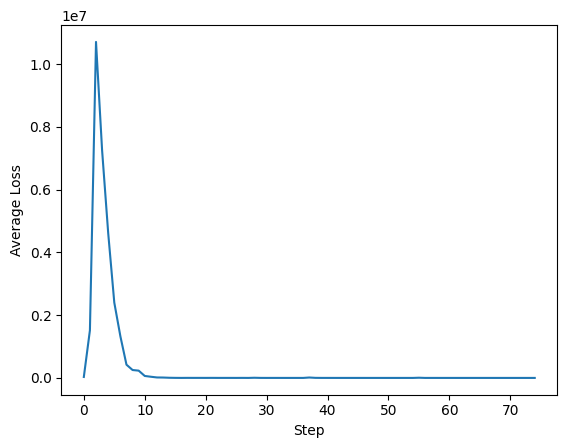

In [10]:
#@test {"skip": true}
import matplotlib.pyplot as plt

# steps = range(0, num_iterations, log_interval)
# plt.plot(steps, returns)
# plt.plot(steps, loss)
plt.plot(loss)
# plt.plot(returns)
plt.ylabel('Average Loss')
plt.xlabel('Step')
# plt.ylim(top=550)
plt.show()

### Videos

It is helpful to visualize the performance of an agent by rendering the environment at each step. Before we do that, let us first create a function to embed videos in this colab.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

The following code visualizes the agent's policy for a few episodes:

In [ ]:
num_episodes = 3
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_py_env.render())
    while not time_step.is_last():
      action_step = agent.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_py_env.render())

embed_mp4(video_filename)

## Keras-rl2 DQNAgent

In [ ]:
import tensorflow as tf
print(tf.__version__)
from keras import __version__
tf.keras.__version__ = __version__

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam

import matplotlib.pyplot as plt
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.callbacks import ModelIntervalCheckpoint, FileLogger


def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1, 2)))
    model.add(Dense(24, activation='relu', input_shape=states))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    # model.add(Flatten())
    return model
    
def build_callbacks(env_name):
    checkpoint_weights_filename = 'dqn_' + env_name + '_weights_{step}.h5f'
    log_filename = 'dqn_{}_log.json'.format(env_name)
    callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=5000)]
    callbacks += [FileLogger(log_filename, interval=100)]
    return callbacks

def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

LEARNING_RATE = 0.1
GAMMA = 0.9999

callbacks = build_callbacks("gc")

# policy = BoltzmannQPolicy()
policy = EpsGreedyQPolicy()
# memory = SequentialMemory(limit=50000, window_length=1)

# memory can help a model during training
# for this, we only consider a single malware sample (window_length=1) for each "experience"
memory = SequentialMemory(limit=50000, window_length=1)

# DQN agent as described in Mnih (2013) and Mnih (2015).
# http://arxiv.org/pdf/1312.5602.pdf
# http://arxiv.org/abs/1509.06461
dqn = DQNAgent(
    model=model, 
    memory=memory, 
    policy=policy,
    nb_actions=actions, 
    nb_steps_warmup=10, 
    target_model_update=1e-2, 
    batch_size=16,
    gamma=GAMMA
)

# keras-rl allows one to use and built-in keras optimizer
dqn.compile(Adam(lr=LEARNING_RATE), metrics=['mae'])

history = dqn.fit(env, nb_max_episode_steps=100, nb_steps=50000, visualize=False, verbose=1)

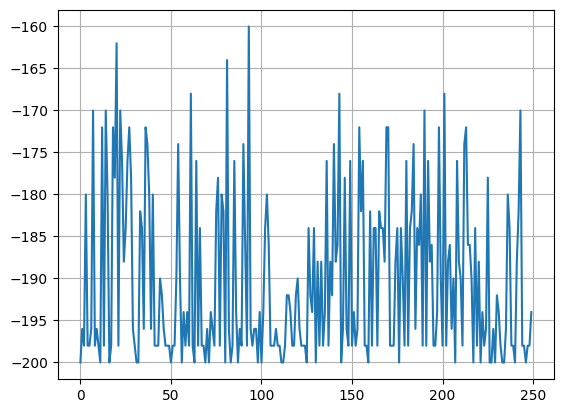

In [4]:
import matplotlib.pyplot as plt 
plt.grid(True)
plt.plot(history.history['episode_reward'])

In [6]:
# scores = dqn.test(env, nb_episodes=100, visualize=False)

# scores = dqn.test(
#     env, 
#     nb_episodes=1,
#     visualize=False, 
#     verbose=1
# )

scores = dqn.test(
    env,
    nb_episodes=100,
    action_repetition=1,
    nb_max_episode_steps=200,
    visualize=False,
    verbose=1
)

# print(np.mean(scores.history['episode_reward']))

Testing for 100 episodes ...
Episode 1: reward: -200.000, steps: 200
Episode 2: reward: -198.000, steps: 200
Episode 3: reward: -200.000, steps: 200
Episode 4: reward: -200.000, steps: 200
Episode 5: reward: -196.000, steps: 200
Episode 6: reward: -198.000, steps: 200
Episode 7: reward: -198.000, steps: 200
Episode 8: reward: -200.000, steps: 200
Episode 9: reward: -198.000, steps: 200
Episode 10: reward: -198.000, steps: 200
Episode 11: reward: -196.000, steps: 200
Episode 12: reward: -198.000, steps: 200
Episode 13: reward: -198.000, steps: 200
Episode 14: reward: -198.000, steps: 200
Episode 15: reward: -198.000, steps: 200
Episode 16: reward: -200.000, steps: 200
Episode 17: reward: -200.000, steps: 200
Episode 18: reward: -200.000, steps: 200
Episode 19: reward: -198.000, steps: 200
Episode 20: reward: -200.000, steps: 200
Episode 21: reward: -200.000, steps: 200
Episode 22: reward: -198.000, steps: 200
Episode 23: reward: -198.000, steps: 200
Episode 24: reward: -200.000, steps: 

KeyboardInterrupt: 

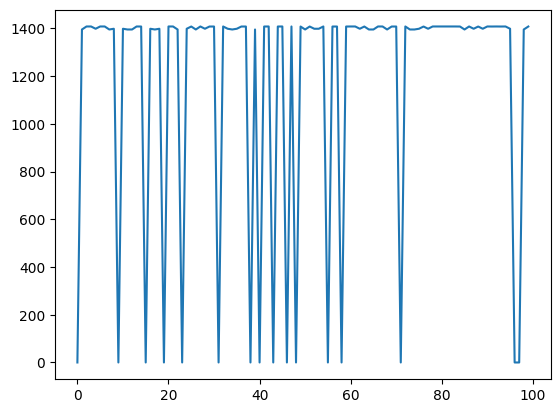

In [7]:
import matplotlib.pyplot as plt 
plt.plot(scores.history['episode_reward'])

In [ ]:
_ = dqn.test(env, nb_episodes=15, visualize=False)

DONE
{'agent': array([  2., -19.]), 'target': array([  1.99999998, -19.        ])}


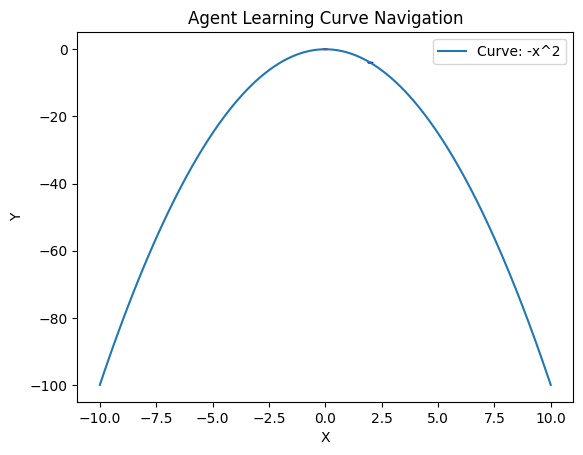

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [12]:
# from gym.envs.classic_control import rendering
import math

def visualize_learning_realtime(agent, env):
    plt.ion()  # Turn on interactive mode
    fig, ax = plt.subplots()

    x_vals = np.linspace(-10, 10, 400)
    y_vals = [2*math.pow(x, 3) - 3*math.pow(x, 2) - 12 * x + 1 for x in x_vals]
    target_x = 0

    agent_x = env._agent_location[0]

    line, = ax.plot(x_vals, y_vals, label="Curve: -x^2")
    target_circle = plt.Circle((target_x, 0), 0.1, color='red')
    agent_circle = plt.Circle((agent_x, -agent_x ** 2), 0.1, color='blue')

    ax.add_patch(target_circle)
    ax.add_patch(agent_circle)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Agent Learning Curve Navigation')
    ax.legend()

    plt.draw()

    for _ in range(200):
        action = agent.forward(env.observation_space.sample())  # Replace with your agent's action selection
        observation, reward, done, _ = env.step(action)

        agent_x = observation[0]

        agent_circle.center = (agent_x, -agent_x ** 2)
        plt.pause(0.01)
        plt.draw()

        if done:
            env.reset()

    plt.ioff()
    plt.show()

visualize_learning_realtime(dqn, env)

## Save and load

In [8]:
dqn.save_weights('dqn_weights.h5f', overwrite=True)

In [ ]:
# env = gym.make('CartPole-v0')
actions = env.action_space.n
states = env.observation_space.shape[0]
model = build_model(states, actions)
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [ ]:
dqn.load_weights('dqn_weights.h5f')

In [ ]:
_ = dqn.test(env, nb_episodes=5, visualize=True)

## Parameters

* ParallelGCThreads: int
* MaxGCPauseMillis: int
* GCTimeRatio: int
* MaxHeapSize: int
* InitialHeapSize: int
* YoungGenerationSizeIncrement: int
* TenuredGenerationSizeIncrement: int
* AdaptiveSizeDecrementScaleFactor: int
* ParallelGCBufferWastePct: int
* ParallelOldDeadWoodLimiterMean: int
* ParallelOldDeadWoodLimiterStdDev: int
* PreTouchParallelChunkSize: int

* UseGCOverheadLimit: bool
* ParallelRefProcBalancingEnabled: bool
* ParallelRefProcEnabled: bool
* AllowParallelDefineClass: bool
* CMSParallelInitialMarkEnabled: bool
* CMSParallelRemarkEnabled: bool
* CMSParallelSurvivorRemarkEnabled: bool
* GCParallelVerificationEnabled: bool